# RL Project Final Submission

# Installing Necessary Libs

In [ ]:
!pip install gym
!pip install gym_anytrading
!pip install stable-baselines3[extra]
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 20.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libs

In [ ]:
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3 import A2C, PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.env_util import make_vec_env
import numpy as np
from matplotlib import pyplot as plt
from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions
import tensorflow as tf
import gymnasium as gym
import gym_anytrading
from tensorflow.keras.layers import LSTM, Dense, Input, GRU, Dropout
from tensorflow.keras.models import Model
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objs as go
import plotly.subplots as subplots
import pandas as pd
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


In [ ]:
np.random.seed(2)

# Dataset And Env Prep

## Importing Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/RL/SMCI.csv')
df = df.reset_index(drop=True)
df = df.set_index('Date')

df_Train = df[:3200].copy().astype('float64')
df_Test = df[3101:].copy().astype('float64')

print(df_Train.head())
print(df_Test.head())

             Open   High    Low  Close     Volume
Date                                             
29-03-2007   8.85   9.31   8.66   8.76  6079800.0
30-03-2007   8.83   9.00   8.55   8.99   419500.0
02-04-2007   9.00  10.59   8.99  10.38   749100.0
03-04-2007  10.70  11.66  10.40  10.58   835700.0
04-04-2007  10.40  10.99  10.03  10.16   309500.0
                 Open       High    Low      Close   Volume
Date                                                       
24-07-2019  19.200001  19.420000  19.15  19.260000  19100.0
25-07-2019  18.600000  19.120001  18.60  18.900000  13800.0
26-07-2019  18.860001  18.860001  18.57  18.660000  17600.0
29-07-2019  18.750000  18.930000  18.50  18.719999  12700.0
30-07-2019  19.379999  19.379999  18.50  18.520000  21900.0


## Normalizing Dataset

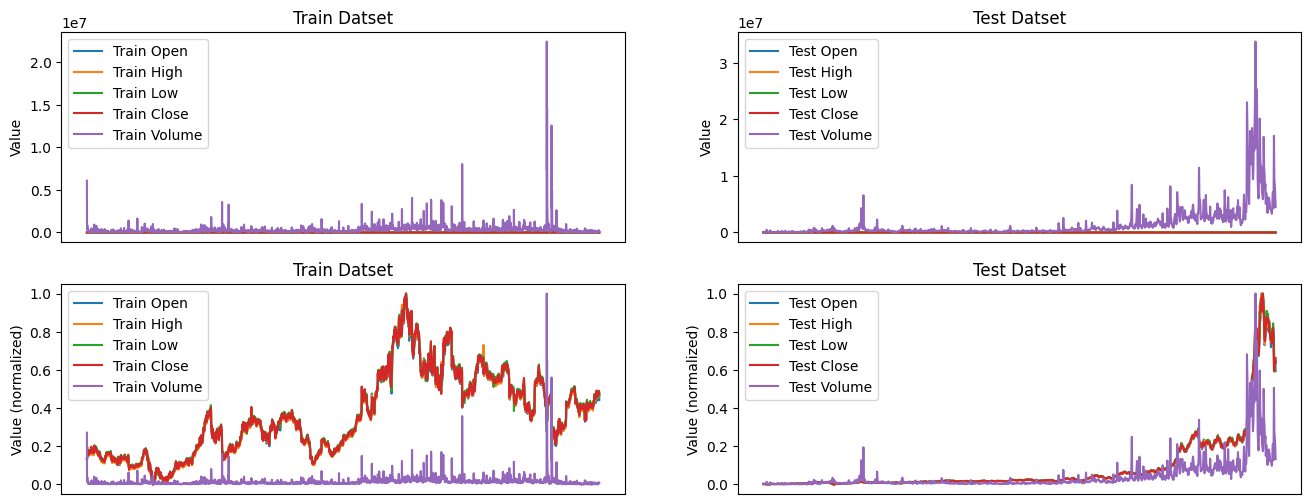

In [ ]:
plt.figure(figsize=(16, 6))

plt.subplot(2,2,1)
for column in df_Train.columns:
    plt.plot(df_Train.index, df_Train[column], label=f'Train {column}')
plt.title('Train Datset')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.subplot(2,2,2)
for column in df_Test.columns:
    plt.plot(df_Test.index, df_Test[column], label=f'Test {column}')
plt.title('Test Datset')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
ax = plt.gca()
ax.get_xaxis().set_visible(False)

scaler1 = MinMaxScaler()
df_Train_n = scaler1.fit_transform(df_Train)
df_Train_n = pd.DataFrame(df_Train_n, columns=df_Train.columns, index=df_Train.index)

scaler2 = MinMaxScaler()
df_Test_n = scaler2.fit_transform(df_Test)
df_Test_n = pd.DataFrame(df_Test_n, columns=df_Test.columns, index=df_Test.index)

plt.subplot(2,2,3)
for column in df_Test_n.columns:
    plt.plot(df_Train_n.index, df_Train_n[column], label=f'Train {column}')
plt.title('Train Datset')
plt.xlabel('Time Step')
plt.ylabel('Value (normalized)')
plt.legend()
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.subplot(2,2,4)
for column in df_Test_n.columns:
    plt.plot(df_Test_n.index, df_Test_n[column], label=f'Test {column}')
plt.title('Test Datset')
plt.xlabel('Time Step')
plt.ylabel('Value (normalized)')
plt.legend()
ax = plt.gca()
ax.get_xaxis().set_visible(False)

plt.show()

## Defining functions to create env from base env

In [ ]:
def my_process_data(df, df_n, window_size, frame_bound):
    start = frame_bound[0] - window_size
    end = frame_bound[1]
    prices = df.loc[:, 'Close'].to_numpy()[start:end]
    signal_features = df_n.loc[:, ['Close', 'Open', 'High', 'Low', 'Volume']].to_numpy()[start:end]
    return prices, signal_features


class MyStocksEnv(StocksEnv):
    def __init__(self, prices, signal_features, **kwargs):
        self._prices = prices
        self._signal_features = signal_features
        super().__init__(**kwargs)

    def _process_data(self):
        return self._prices, self._signal_features


def create_env(prices, signal_features, df, start_index, end_index, window_size):
    env = MyStocksEnv(prices, signal_features, df=df, window_size=window_size, frame_bound=(start_index, end_index))
    env.trade_fee = 0
    return env

def env_maker(prices, signal_features, df, start_index, end_index, window_size):
    return create_env(prices, signal_features, df, start_index, end_index, window_size)

## Creating test and train Envs

### Envs for baseline model

#### Train Env





In [ ]:
prices_train, signal_features_train = my_process_data(df=df_Train, df_n=df_Train_n, window_size=100, frame_bound=(100, len(df_Train_n)))
env_train_b = make_vec_env(lambda: env_maker(prices_train, signal_features_train, df_Train, 100, len(df_Train), 100), n_envs=10)

#### Test Env





In [ ]:
prices_test, signal_features_test = my_process_data(df=df_Test, df_n=df_Test_n, window_size=100, frame_bound=(100, len(df_Test_n)))
env_test_b = env_maker(prices_test, signal_features_test, df_Test, 100, len(df_Test), 100)

### Envs for custom model

#### Train Env

In [ ]:
prices_train, signal_features_train = my_process_data(df=df_Train, df_n=df_Train_n, window_size=100, frame_bound=(100, len(df_Train_n)))
env_train = MyStocksEnv(prices_train, signal_features_train, df=df_Train, window_size=100, frame_bound=(100, len(df_Train_n)))
env_train.trade_fee = 0

print("custom_env information:")
print("> shape:", env_train.unwrapped.shape)
print("> df.shape:", env_train.unwrapped.df.shape)
print("> prices.shape:", env_train.unwrapped.prices.shape)
print("> signal_features.shape:", env_train.unwrapped.signal_features.shape)
print("> Action Space:", env_train.unwrapped.action_space)

custom_env information:
> shape: (100, 5)
> df.shape: (3200, 5)
> prices.shape: (3200,)
> signal_features.shape: (3200, 5)
> Action Space: Discrete(2)


#### Test Env





In [ ]:
prices_test, signal_features_test = my_process_data(df=df_Test, df_n=df_Test_n, window_size=100, frame_bound=(100, len(df_Test_n)))
env_test = MyStocksEnv(prices_test, signal_features_test, df=df_Test, window_size=100, frame_bound=(100, len(df_Test_n)))
env_test.trade_fee = 0

print("custom_env information:")
print("> shape:", env_test.unwrapped.shape)
print("> df.shape:", env_test.unwrapped.df.shape)
print("> prices.shape:", env_test.unwrapped.prices.shape)
print("> signal_features.shape:", env_test.unwrapped.signal_features.shape)
print("> Action Space:", env_test.unwrapped.action_space)

custom_env information:
> shape: (100, 5)
> df.shape: (1198, 5)
> prices.shape: (1198,)
> signal_features.shape: (1198, 5)
> Action Space: Discrete(2)


# Training and Testing Baseline Model

## Defining Model Evlauation Function

In [ ]:
def plot_eval_results(results, df_test, title, xlabel, ylabel):
    data = np.array(list(results.values()))
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    x_range = list(range(len(means)))

    trace1 = go.Scatter(
        x=x_range,
        y=means,
        mode='markers',
        name='Mean Values',
        marker=dict(color='red'),
        error_y=dict(type='data', array=stds, visible=True, color='blue', thickness=1.5)
    )

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
    fig.add_trace(trace1, row=1, col=1)

    for index, result_set in enumerate(data):
        trace2 = go.Scatter(
            x=x_range,
            y=result_set,
            mode='lines',
            name=f'Result Set {index + 1}'
        )
        fig.add_trace(trace2, row=2, col=1)


    fig.update_layout(
        xaxis1=dict(title=xlabel, tickangle=-45),
        yaxis1=dict(title=ylabel),
        xaxis2=dict(title='Time Step'),
        yaxis2=dict(title='Quality'),
        showlegend=True,
        title_text=title
    )

    fig.show()

def evla_baseline_model(env, model):
  result = {0: [],1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
  for i in range(10):
    obs, *info = env.reset()
    total_reward = 0
    while True:
        obs_array = obs if isinstance(obs, np.ndarray) else obs[0]
        obs_array = obs_array[np.newaxis, ...]
        action, _ = model.predict(obs_array)
        obs, reward, done, t, info = env.step(action)
        total_reward += reward
        result[i].append(total_reward)
        if done or t:
            break
    plt.figure(figsize=(30, 5))
    env.render_all()
    plt.show()

  plot_eval_results(result, df_Test_n, title='Quality Plot', xlabel='Time Step', ylabel='Quality')

## Training Baseline Model

In [ ]:
baseline_model = PPO(MlpPolicy, env_train_b, verbose=1)
baseline_model.learn(total_timesteps=500000, progress_bar=True)

Using cpu device


Output()

------------------------------
| time/              |       |
|    fps             | 4624  |
|    iterations      | 1     |
|    time_elapsed    | 4     |
|    total_timesteps | 20480 |
------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3.1e+03     |
|    ep_rew_mean          | 0.462       |
| time/                   |             |
|    fps                  | 1304        |
|    iterations           | 2           |
|    time_elapsed         | 31          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.013417592 |
|    clip_fraction        | 0.0174      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.683      |
|    explained_variance   | 2.96e-05    |
|    learning_rate        | 0.0003      |
|    loss                 | 0.318       |
|    n_updates            | 10          |
|    policy_gradient_loss |

## Testing Baseline Model

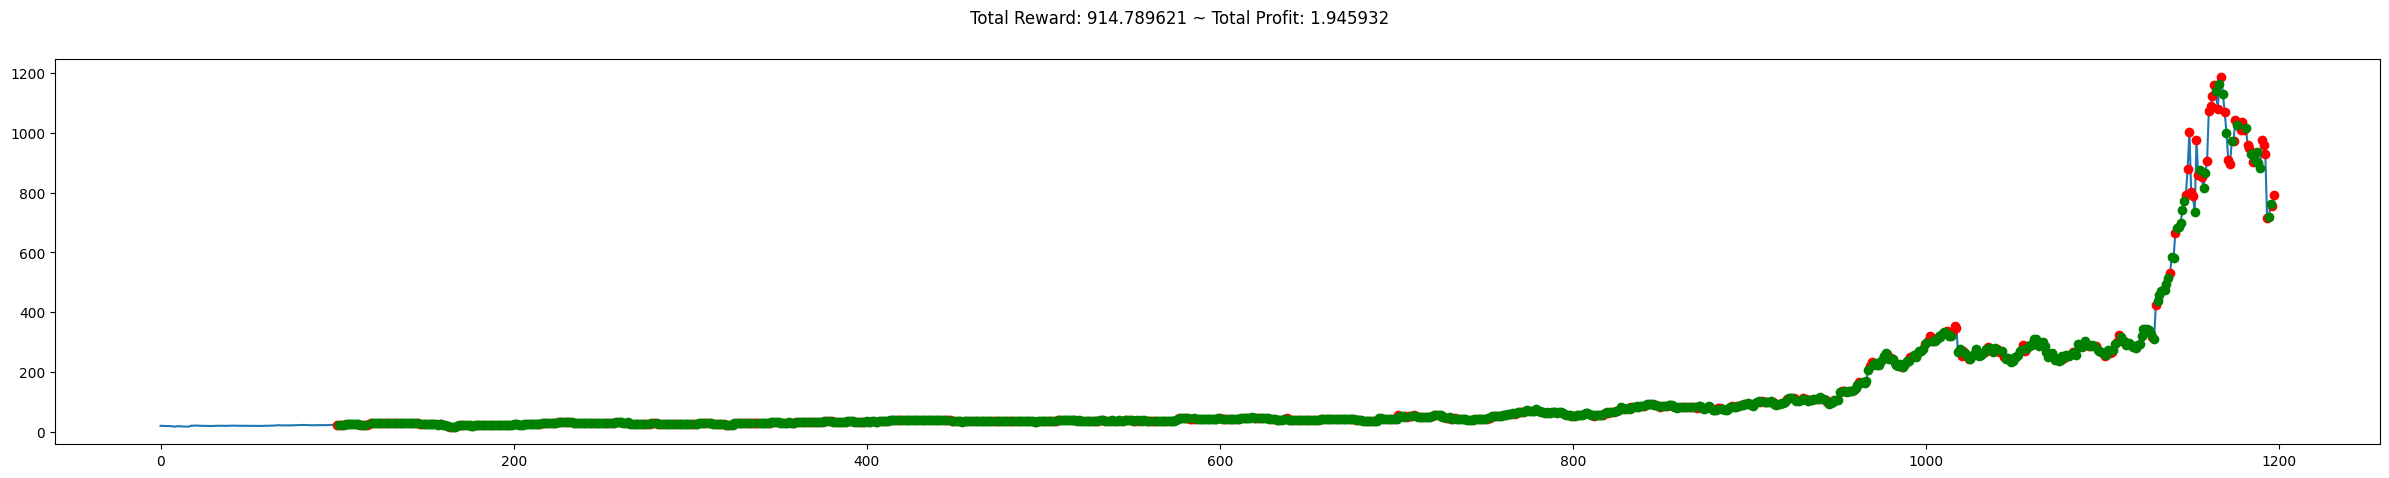

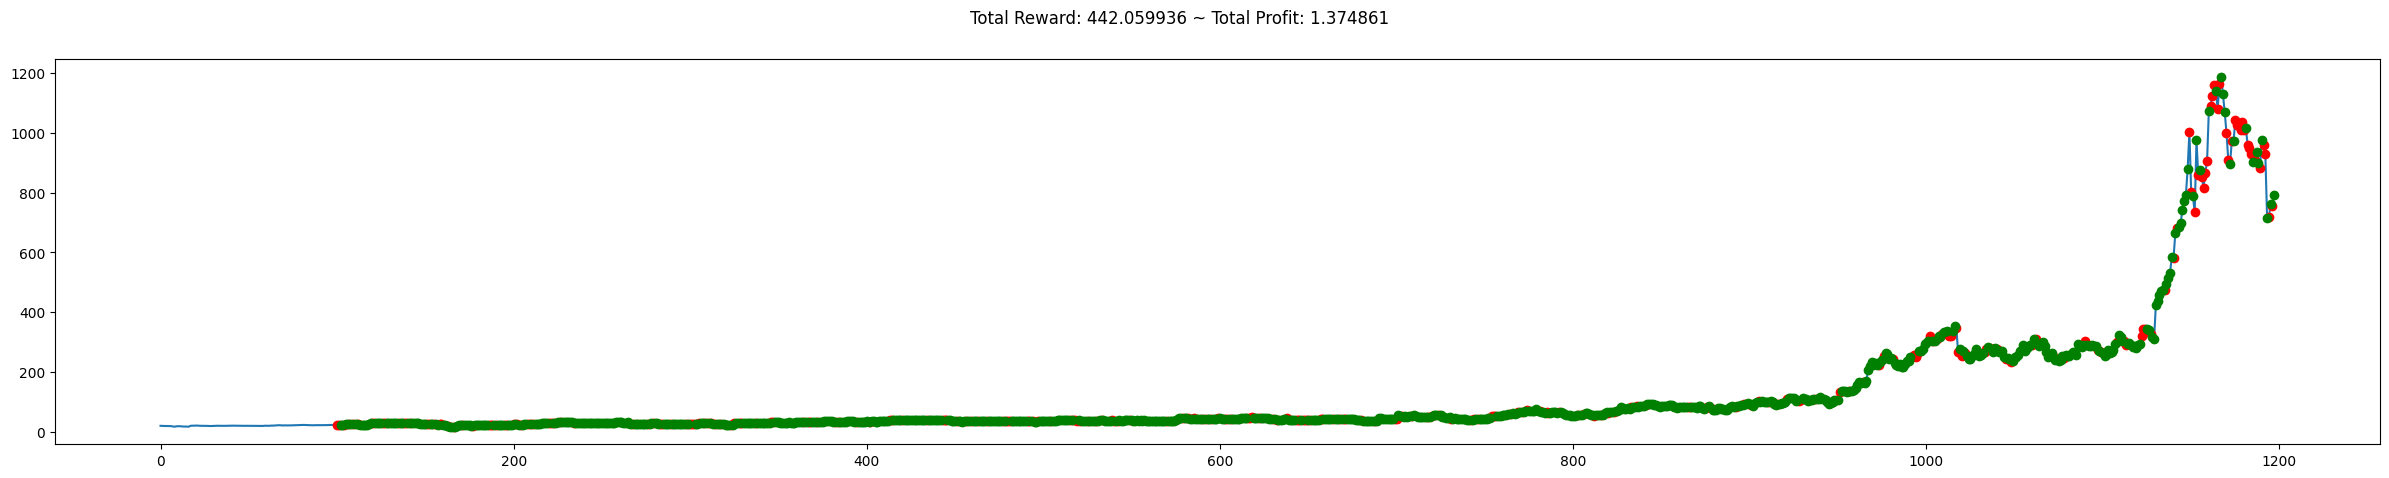

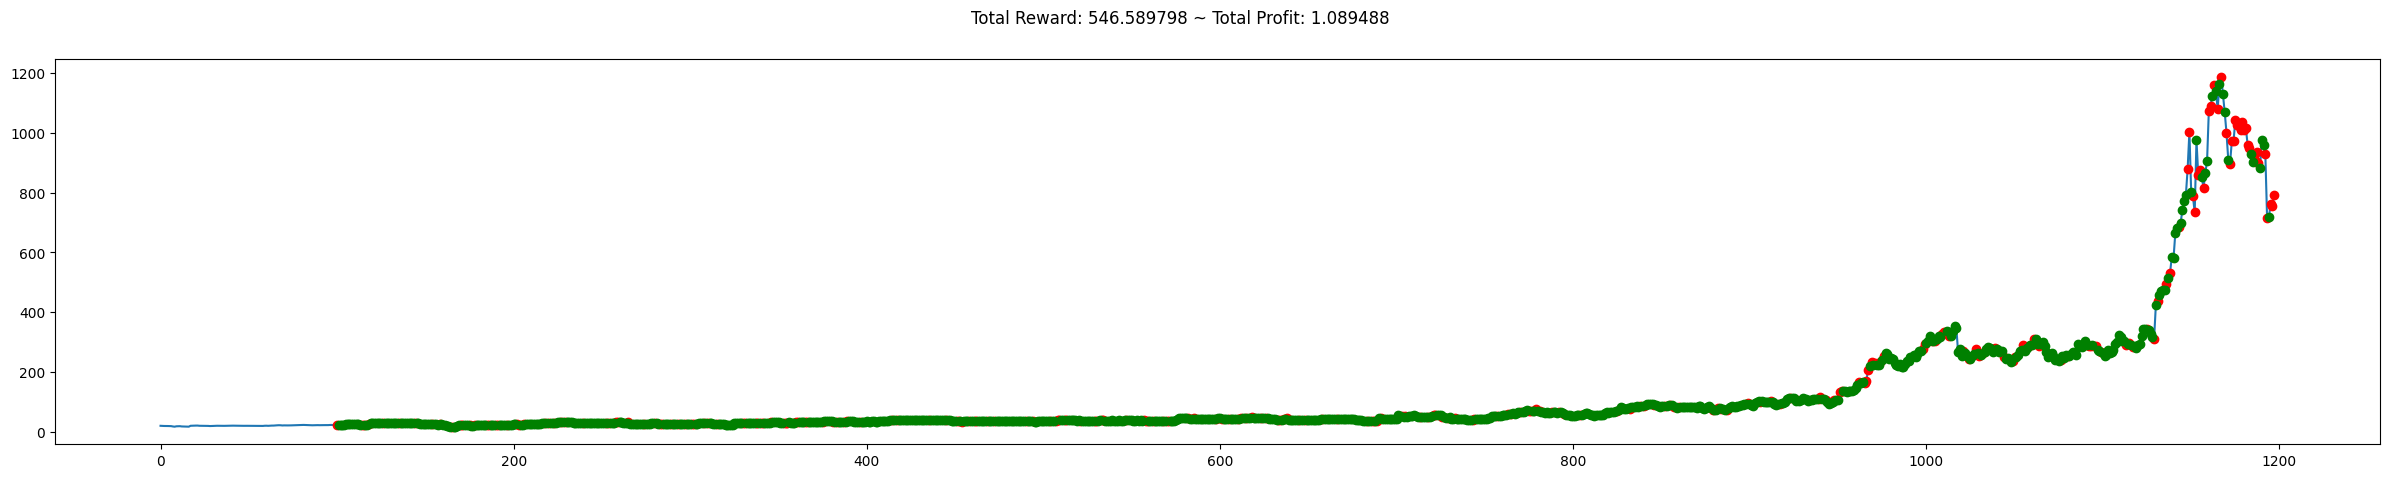

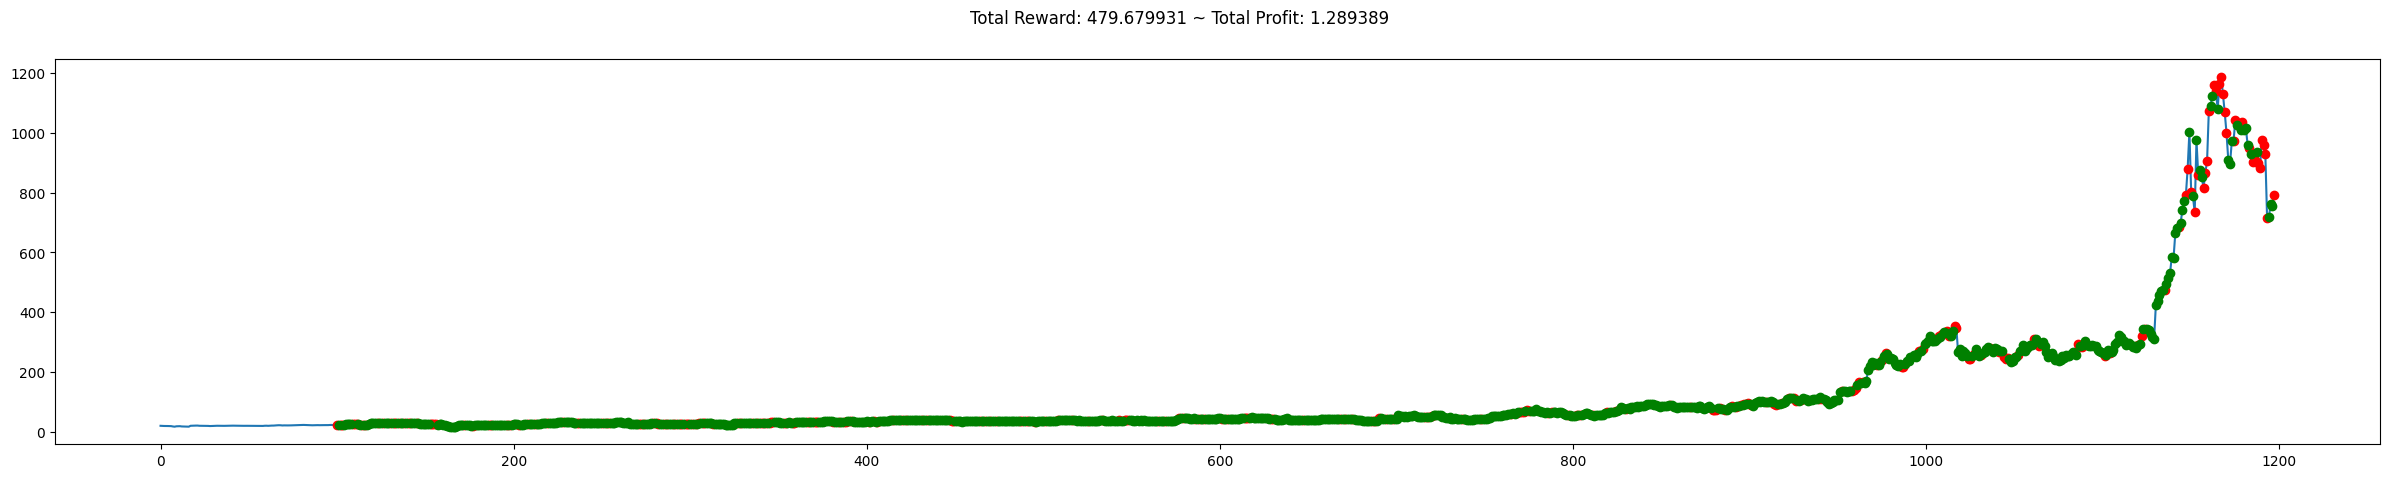

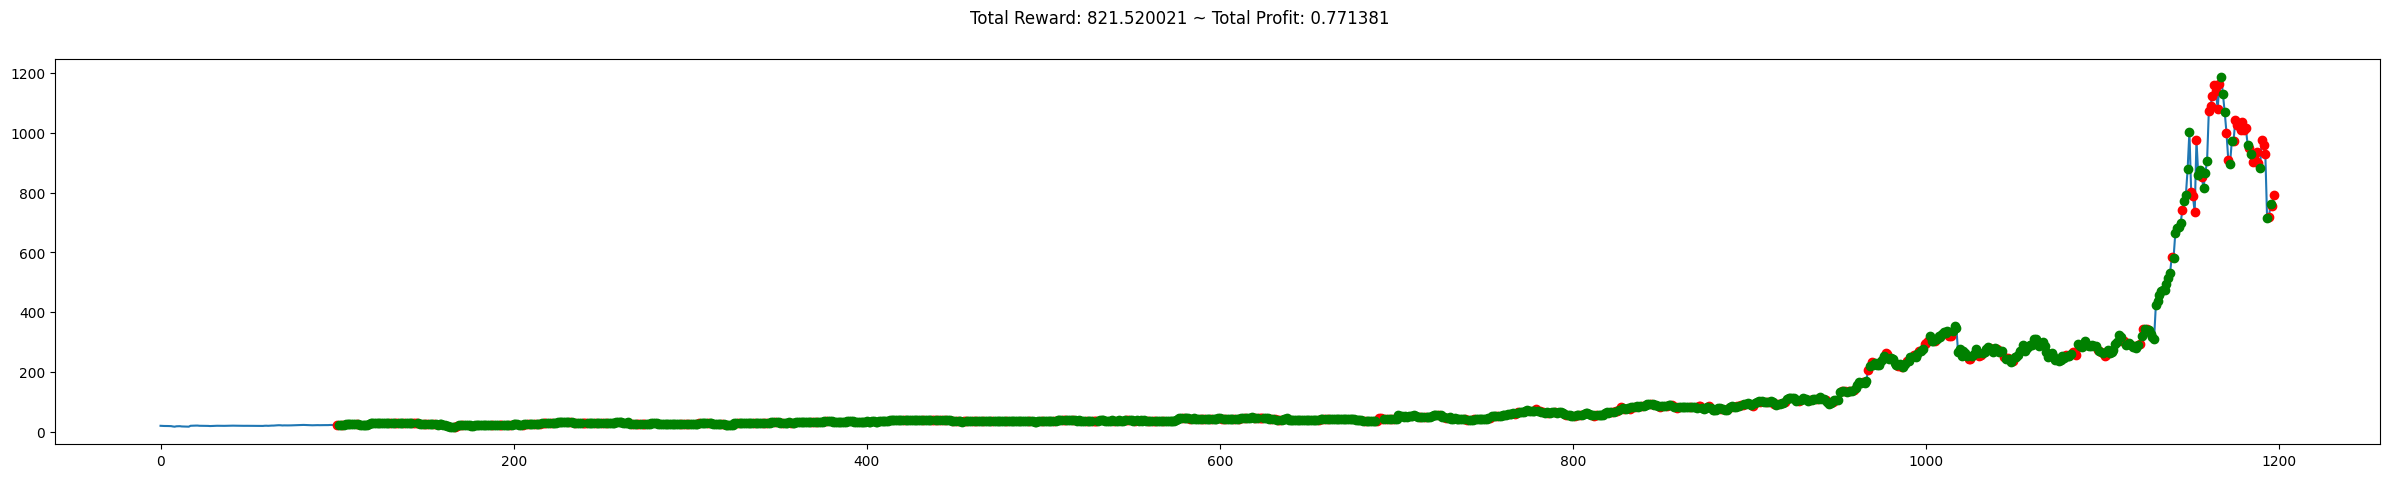

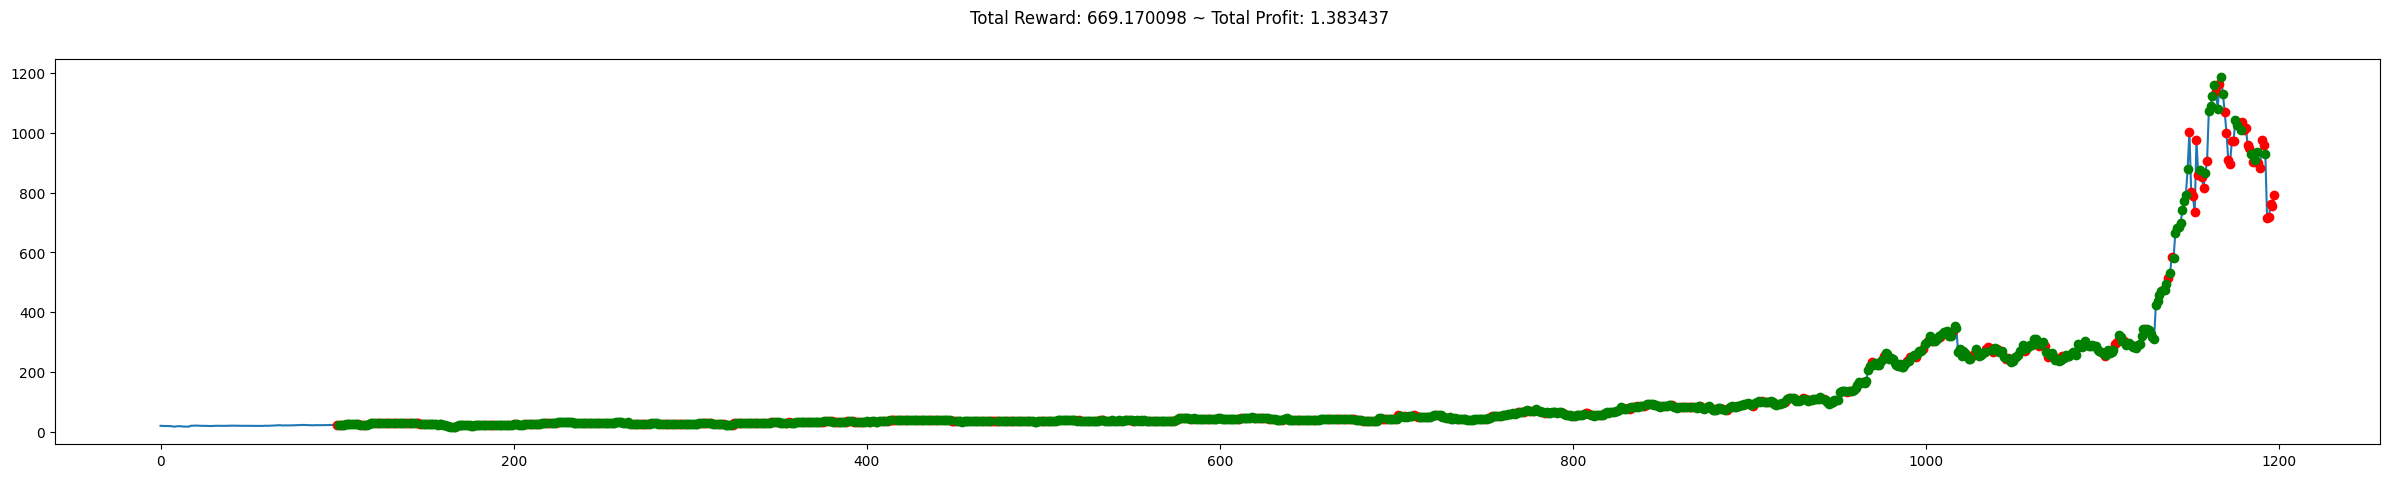

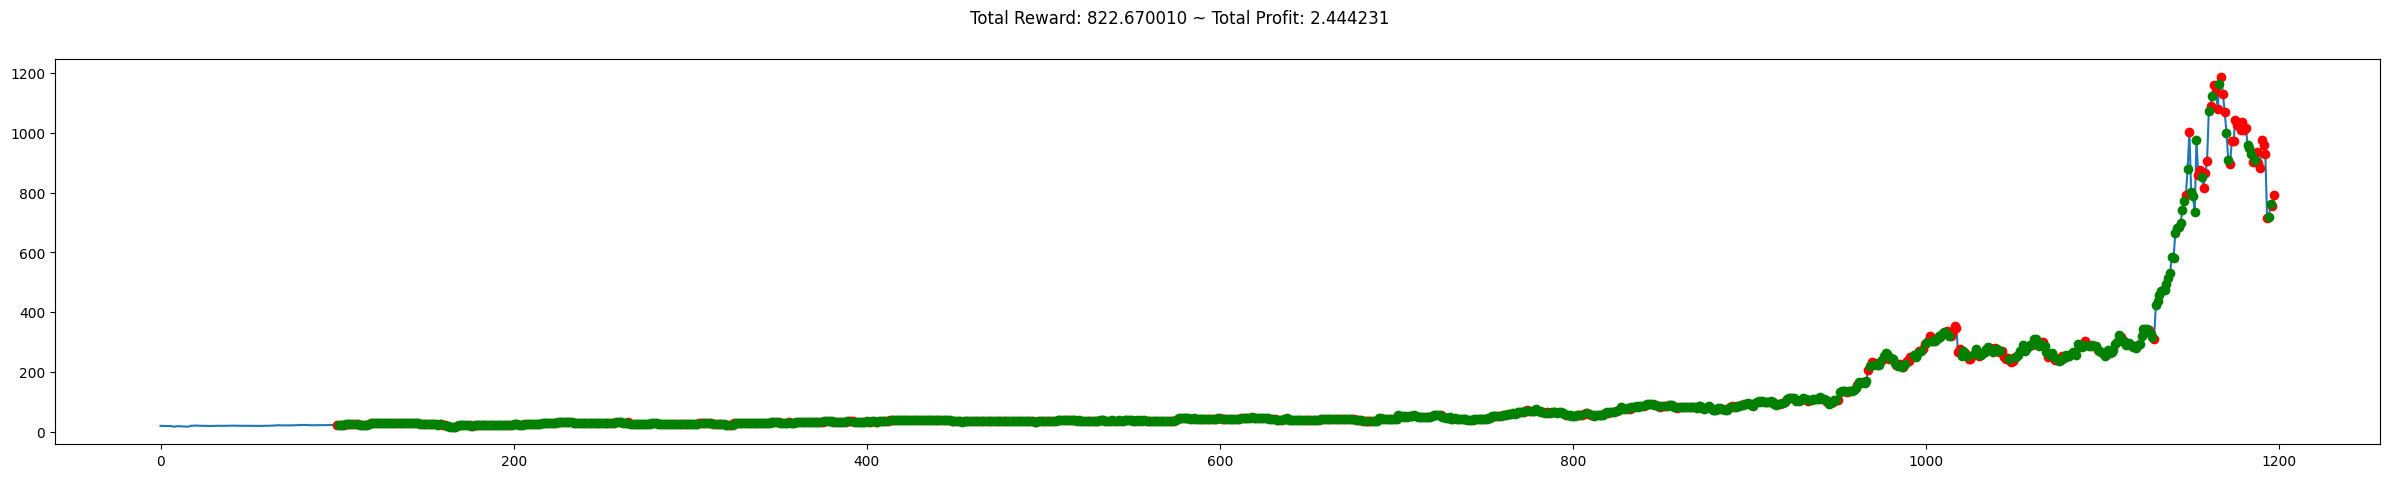

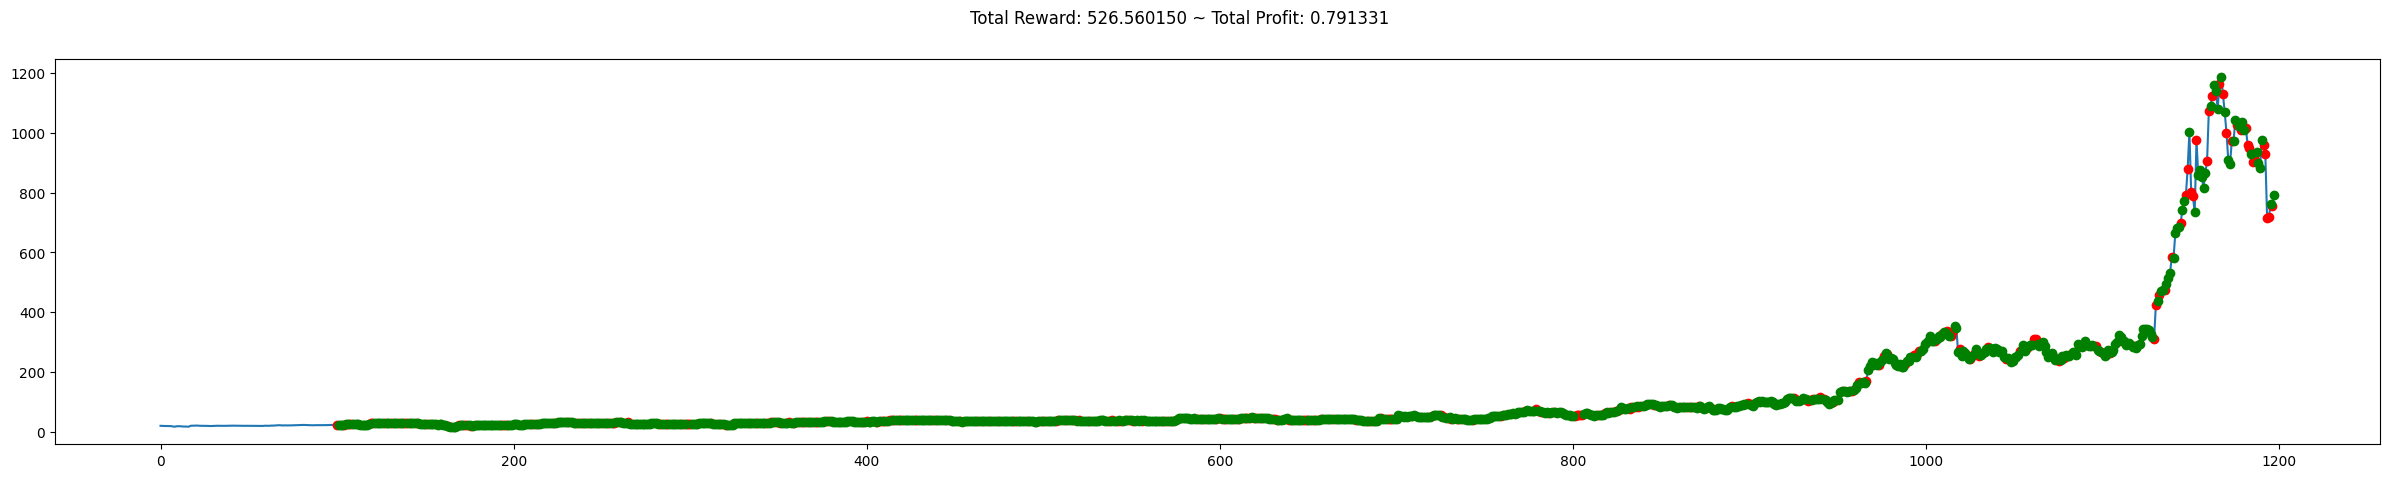

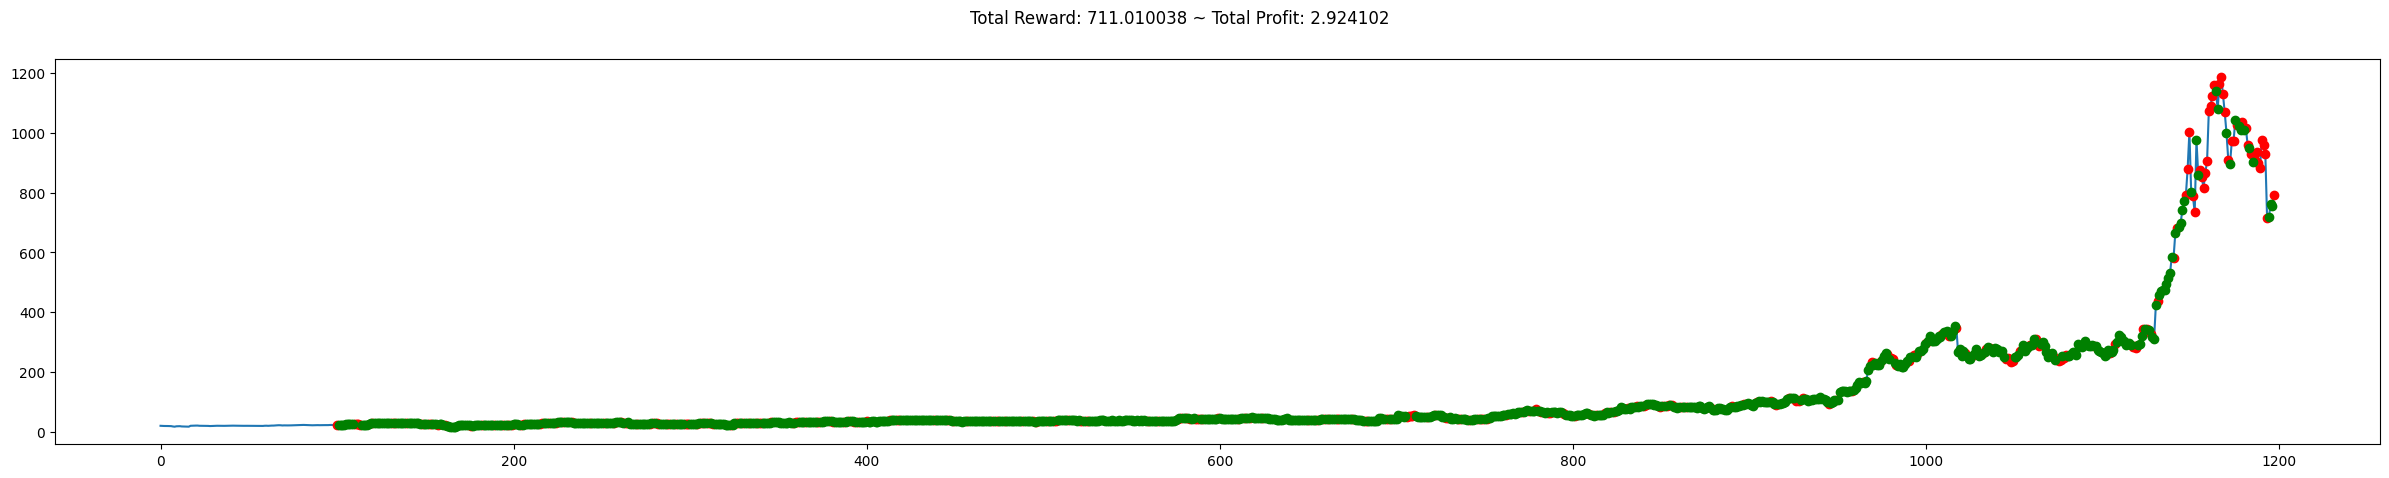

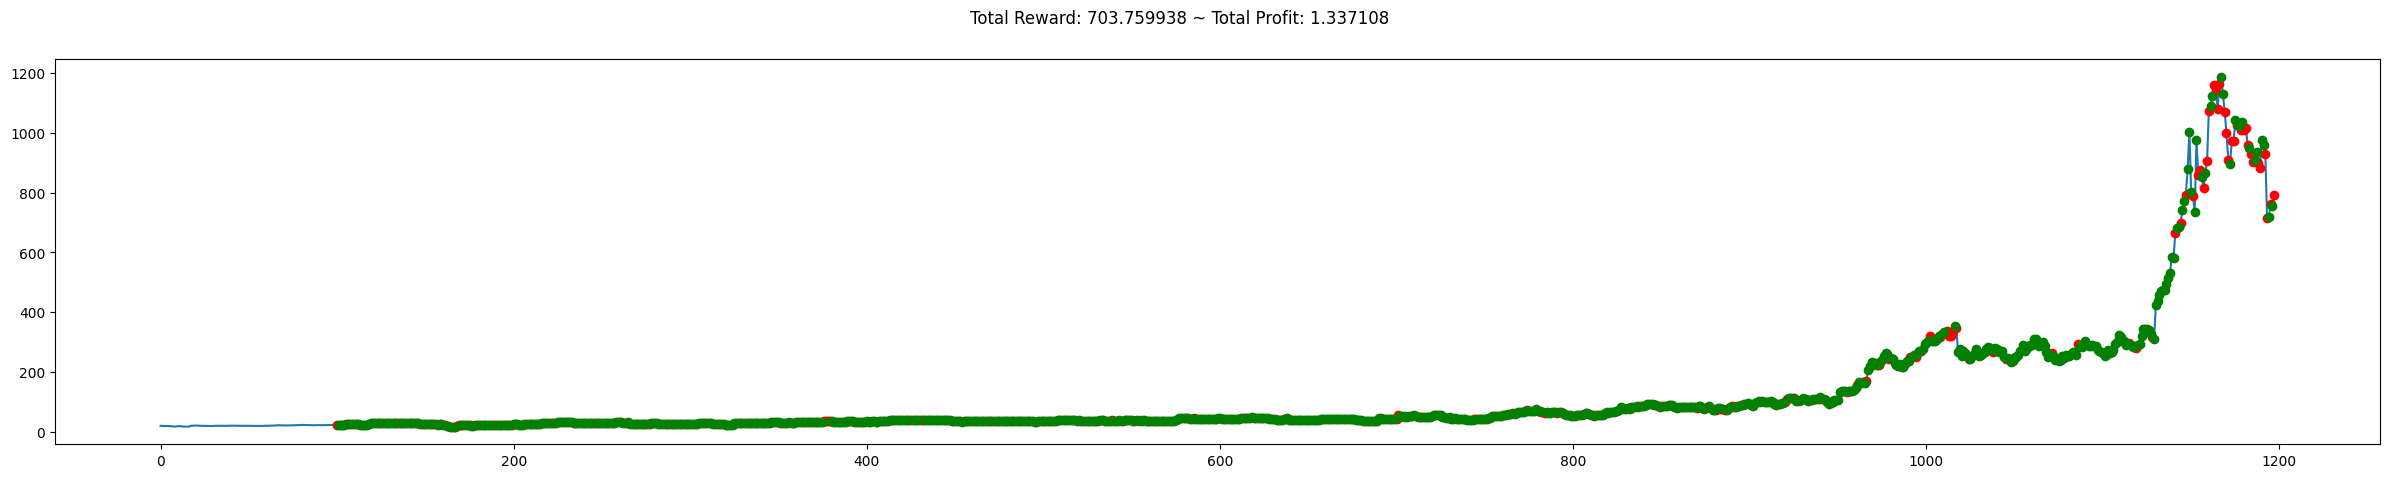

In [ ]:
evla_baseline_model(env_test_b, baseline_model)

# Training and Testing Custom Model

## Defining Model Evlauation Function

In [ ]:
def plot_eval_results(results, df_test, title, xlabel, ylabel):
    data = np.array(list(results.values()))
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)

    x_range = list(range(len(means)))

    trace1 = go.Scatter(
        x=x_range,
        y=means,
        mode='markers',
        name='Mean Values',
        marker=dict(color='red'),
        error_y=dict(type='data', array=stds, visible=True, color='blue', thickness=1.5)
    )

    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)
    fig.add_trace(trace1, row=1, col=1)

    for index, result_set in enumerate(data):
        trace2 = go.Scatter(
            x=x_range,
            y=result_set,
            mode='lines',
            name=f'Result Set {index + 1}'
        )
        fig.add_trace(trace2, row=2, col=1)


    fig.update_layout(
        xaxis1=dict(title=xlabel, tickangle=-45),
        yaxis1=dict(title=ylabel),
        xaxis2=dict(title='Time Step'),
        yaxis2=dict(title='Quality'),
        showlegend=True,
        title_text=title
    )

    fig.show()


def evla_custom_model(env, actor, num_eval=10):
  result = {}
  for i in tqdm(range(num_eval)):
    state, _ = env.reset()
    total_reward = 0
    done = False
    result[i] = []
    while not done:
        state = np.expand_dims(state, axis=0)
        logits = actor(state)
        action_probs = tf.nn.softmax(logits, axis=-1)
        action_probs = tf.reduce_sum(action_probs, axis=0)
        action_probs = tf.reduce_sum(action_probs, axis=0)
        action_probs = action_probs.numpy()
        action_probs /= np.sum(action_probs)
        action = action = np.random.choice(env.action_space.n, p=action_probs)
        next_state, reward, truncated, done, info = env.step(action)
        total_reward += reward
        result[i].append(total_reward)
        state = next_state

        if done or truncated:
            break

    print(f"Total reward accumulated during the test: {total_reward}")
    plt.figure(figsize=(30, 5))
    env.render_all()
    plt.show()

  plot_eval_results(result, df_Test_n, title='Quality Plot', xlabel='Time Step', ylabel='Quality')

## Defining Actor Network, Crtic Network and PPO Algorithm

In [ ]:
## Actor Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
logits = Dense(env_train.action_space.n, activation='sigmoid')(dense)
actor = Model(inputs=inputs, outputs=logits)

## Critic Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
values = Dense(1, activation='sigmoid')(dense)
critic = Model(inputs=inputs, outputs=values)

## PPO Algorithm
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
huber_loss = tf.keras.losses.Huber()
entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

## Defining Custom training loop

In [ ]:
def train_ppo(env, actor, critic, num_episodes):
    total_reward = []
    for episode in tqdm(range(num_episodes)):
        state, info = env.reset()
        episode_rewards = []
        states, actions, rewards, values, dones, old_probs = [], [], [], [], [], []

        while True:
            state = np.expand_dims(state, axis=0)
            logits = actor(state)
            action_probs = tf.nn.softmax(logits, axis=-1)
            action_probs = tf.reduce_sum(action_probs, axis=0)
            action_probs = tf.reduce_sum(action_probs, axis=0)
            action_probs = action_probs.numpy()
            action_probs /= np.sum(action_probs)


            action = np.random.choice(env.action_space.n, p=action_probs)
            chosen_prob = action_probs[action]

            value = critic(state)
            next_state, reward, truncated, done, info = env.step(action)

            states.append(state[0])
            actions.append(action)
            rewards.append(reward)
            values.append(value[0][0])
            dones.append(done or truncated)
            old_probs.append([chosen_prob, 1-chosen_prob])

            state = next_state
            episode_rewards.append(reward)

            if done or truncated:
                break

        returns, advantages = calculate_returns_and_advantages(rewards, values, dones)

        actions = tf.convert_to_tensor(actions, dtype=tf.int32)
        old_probs = tf.convert_to_tensor(old_probs, dtype=tf.float32)
        advantages = tf.convert_to_tensor(advantages, dtype=tf.float32)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)
        values = tf.convert_to_tensor(values, dtype=tf.float32)

        with tf.GradientTape() as tape:
            new_logits = actor(tf.convert_to_tensor(states))
            new_probs = tf.nn.softmax(new_logits, axis=-1)
            new_probs = tf.gather_nd(new_probs, tf.stack([tf.range(actions.shape[0]), actions], axis=1))
            loss = ppo_loss(old_probs, values, returns, actions, advantages, new_probs)

        gradients = tape.gradient(loss, actor.trainable_variables + critic.trainable_variables)
        optimizer.apply_gradients(zip(gradients, actor.trainable_variables + critic.trainable_variables))
        total_reward.append(sum(episode_rewards))
        print(f"Episode: {episode}, Total Reward: {sum(episode_rewards)}, loss: {loss}")
    print("total_reward: ",total_reward)
    return actor

def ppo_loss(old_probs, values, returns, actions, advantages, new_probs):
    old_probs = tf.reshape(old_probs, new_probs.shape)
    ratio = new_probs / old_probs
    p1 = ratio * tf.expand_dims(advantages, axis=-1)
    p2 = tf.clip_by_value(ratio, 2 - 0.4, 2 + 0.4) * tf.expand_dims(advantages, axis=-1)
    surrogate_loss = -tf.reduce_mean(tf.minimum(p1, p2))
    value_loss = huber_loss(values, returns)
    total_loss = surrogate_loss + 0.5 * value_loss
    return total_loss

def calculate_returns_and_advantages(rewards, values, dones, discount_factor=0.99, lambda_=0.95):
    num_steps = len(rewards)
    returns = np.zeros(num_steps)
    advantages = np.zeros(num_steps)
    next_value = 0
    gae = 0

    for t in reversed(range(num_steps)):
        if dones[t]:
            delta = rewards[t] - values[t]
            next_value = 0
            gae = 0
        else:
            delta = rewards[t] + discount_factor * next_value - values[t]
        gae = delta + discount_factor * lambda_ * gae
        advantages[t] = gae
        returns[t] = gae + values[t]
        next_value = values[t]

    return returns, advantages

## Training Custom Model

In [ ]:
train_ppo(env_train, actor, critic, num_episodes=20)

  5%|▌         | 1/20 [02:26<46:18, 146.21s/it]

Episode: 0, Total Reward: 5.8400170000000475, loss: 0.5117167830467224


 10%|█         | 2/20 [04:38<41:24, 138.01s/it]

Episode: 1, Total Reward: 14.939992, loss: 0.4521518647670746


 15%|█▌        | 3/20 [06:52<38:37, 136.35s/it]

Episode: 2, Total Reward: 15.149969000000027, loss: 0.4703340530395508


 20%|██        | 4/20 [09:02<35:36, 133.56s/it]

Episode: 3, Total Reward: 33.140009999999975, loss: 0.35889869928359985


 25%|██▌       | 5/20 [11:11<33:02, 132.17s/it]

Episode: 4, Total Reward: -15.219998999999962, loss: 0.6318269371986389


 30%|███       | 6/20 [13:20<30:35, 131.12s/it]

Episode: 5, Total Reward: -8.069973999999979, loss: 0.6283610463142395


 35%|███▌      | 7/20 [15:30<28:16, 130.49s/it]

Episode: 6, Total Reward: 12.739983000000047, loss: 0.5750101208686829


 40%|████      | 8/20 [17:37<25:55, 129.59s/it]

Episode: 7, Total Reward: -4.200023999999985, loss: 0.5414688587188721


 45%|████▌     | 9/20 [19:48<23:49, 129.95s/it]

Episode: 8, Total Reward: 15.150013000000047, loss: 0.4514697194099426


 50%|█████     | 10/20 [21:54<21:27, 128.71s/it]

Episode: 9, Total Reward: -3.99002100000002, loss: 0.566950261592865


 55%|█████▌    | 11/20 [23:59<19:08, 127.65s/it]

Episode: 10, Total Reward: -14.559975999999935, loss: 0.6688265800476074


 60%|██████    | 12/20 [26:04<16:54, 126.81s/it]

Episode: 11, Total Reward: -4.499999996454562e-05, loss: 0.5626095533370972


 65%|██████▌   | 13/20 [28:09<14:43, 126.23s/it]

Episode: 12, Total Reward: -10.309969000000079, loss: 0.659400463104248


 70%|███████   | 14/20 [30:15<12:37, 126.21s/it]

Episode: 13, Total Reward: 3.7599809999999945, loss: 0.5410973429679871


 75%|███████▌  | 15/20 [32:20<10:28, 125.77s/it]

Episode: 14, Total Reward: 15.389992000000023, loss: 0.43975818157196045


 80%|████████  | 16/20 [34:23<08:19, 124.92s/it]

Episode: 15, Total Reward: -1.5600109999999976, loss: 0.6513776779174805


 85%|████████▌ | 17/20 [36:27<06:13, 124.62s/it]

Episode: 16, Total Reward: 12.300035000000069, loss: 0.5106614828109741


 90%|█████████ | 18/20 [38:30<04:08, 124.27s/it]

Episode: 17, Total Reward: -27.679998999999977, loss: 0.7200788259506226


 95%|█████████▌| 19/20 [40:34<02:04, 124.25s/it]

Episode: 18, Total Reward: -8.330025999999968, loss: 0.5951420068740845


100%|██████████| 20/20 [42:38<00:00, 127.91s/it]

Episode: 19, Total Reward: -11.020001000000041, loss: 0.6545081734657288
total_reward:  [5.8400170000000475, 14.939992, 15.149969000000027, 33.140009999999975, -15.219998999999962, -8.069973999999979, 12.739983000000047, -4.200023999999985, 15.150013000000047, -3.99002100000002, -14.559975999999935, -4.499999996454562e-05, -10.309969000000079, 3.7599809999999945, 15.389992000000023, -1.5600109999999976, 12.300035000000069, -27.679998999999977, -8.330025999999968, -11.020001000000041]


## Testing Custom Model

  0%|          | 0/10 [00:00<?, ?it/s]

Total reward accumulated during the test: 191.4698739999999


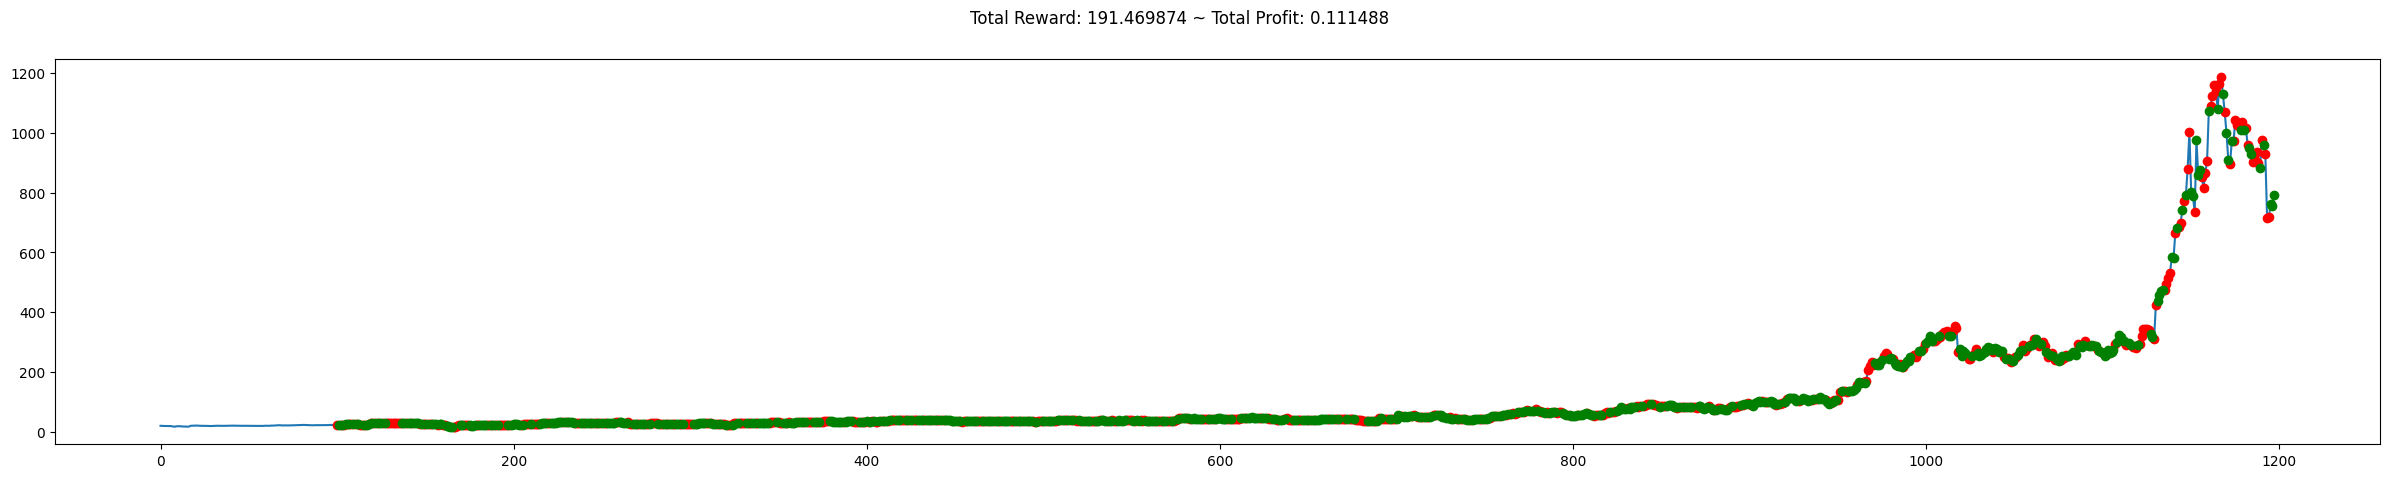

 10%|█         | 1/10 [00:22<03:19, 22.22s/it]

Total reward accumulated during the test: 183.5098150000003


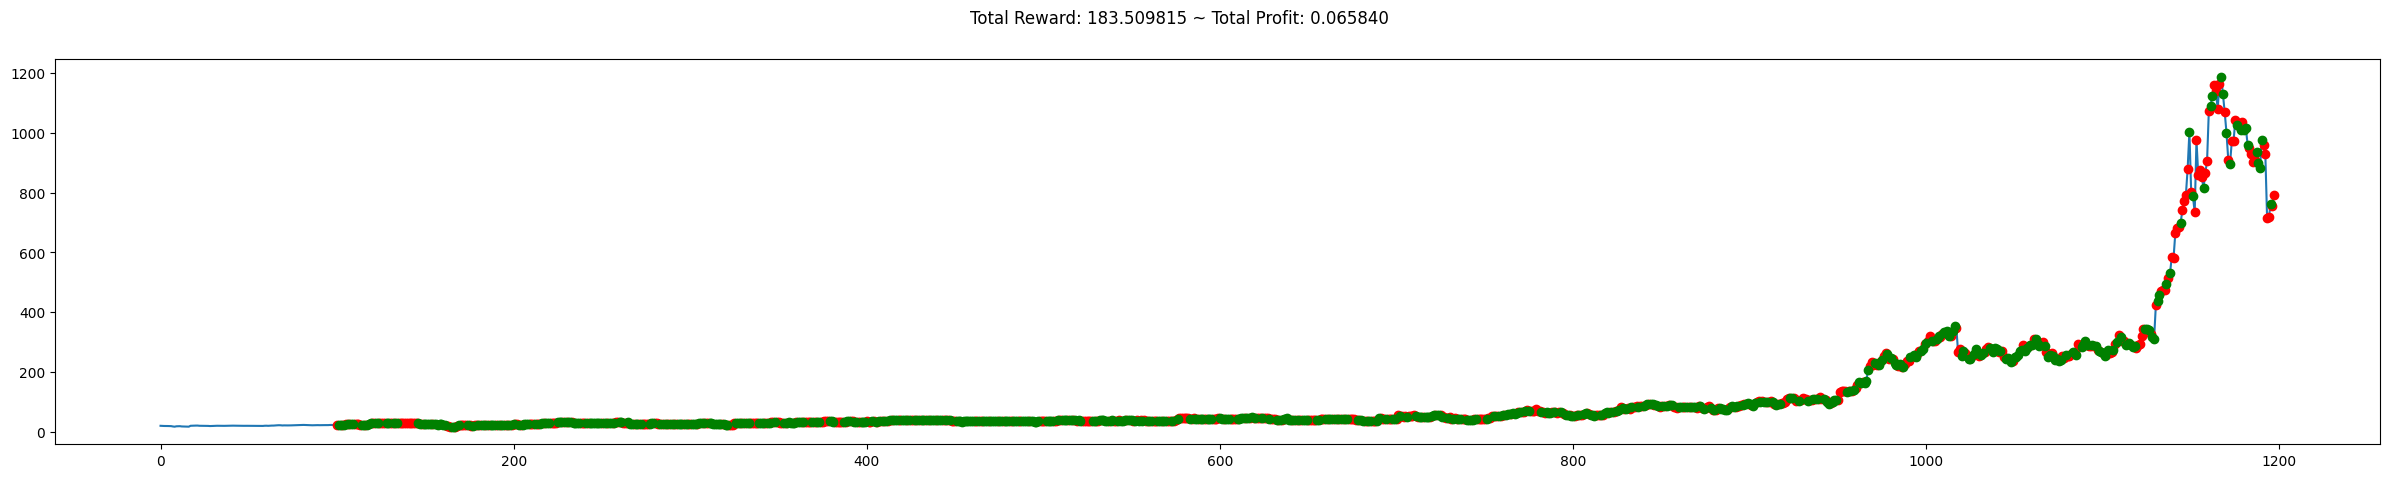

 20%|██        | 2/10 [00:44<02:57, 22.13s/it]

Total reward accumulated during the test: 359.3498910000002


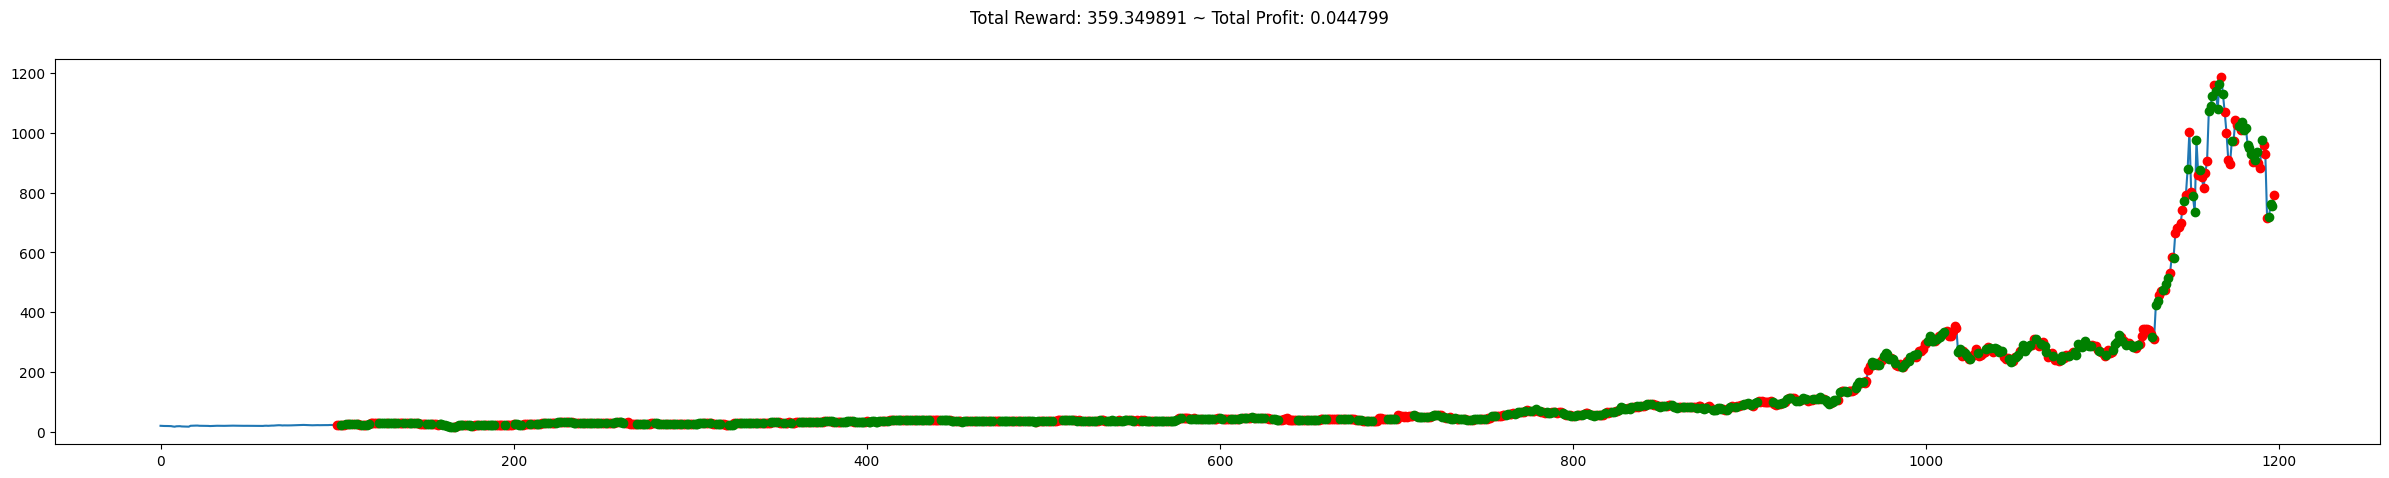

 30%|███       | 3/10 [01:06<02:34, 22.11s/it]

Total reward accumulated during the test: 613.0300009999999


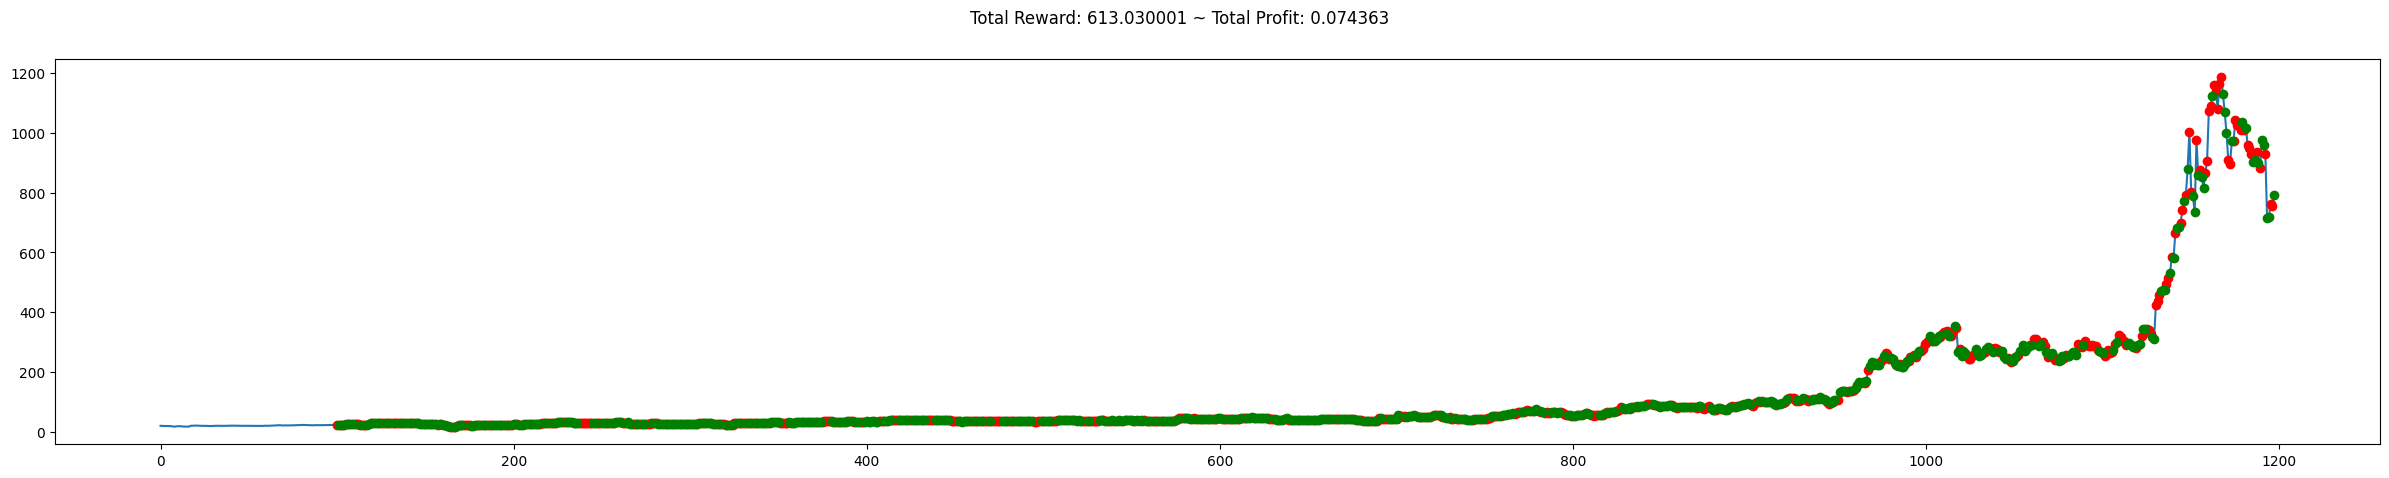

 40%|████      | 4/10 [01:27<02:10, 21.83s/it]

Total reward accumulated during the test: 443.4100340000002


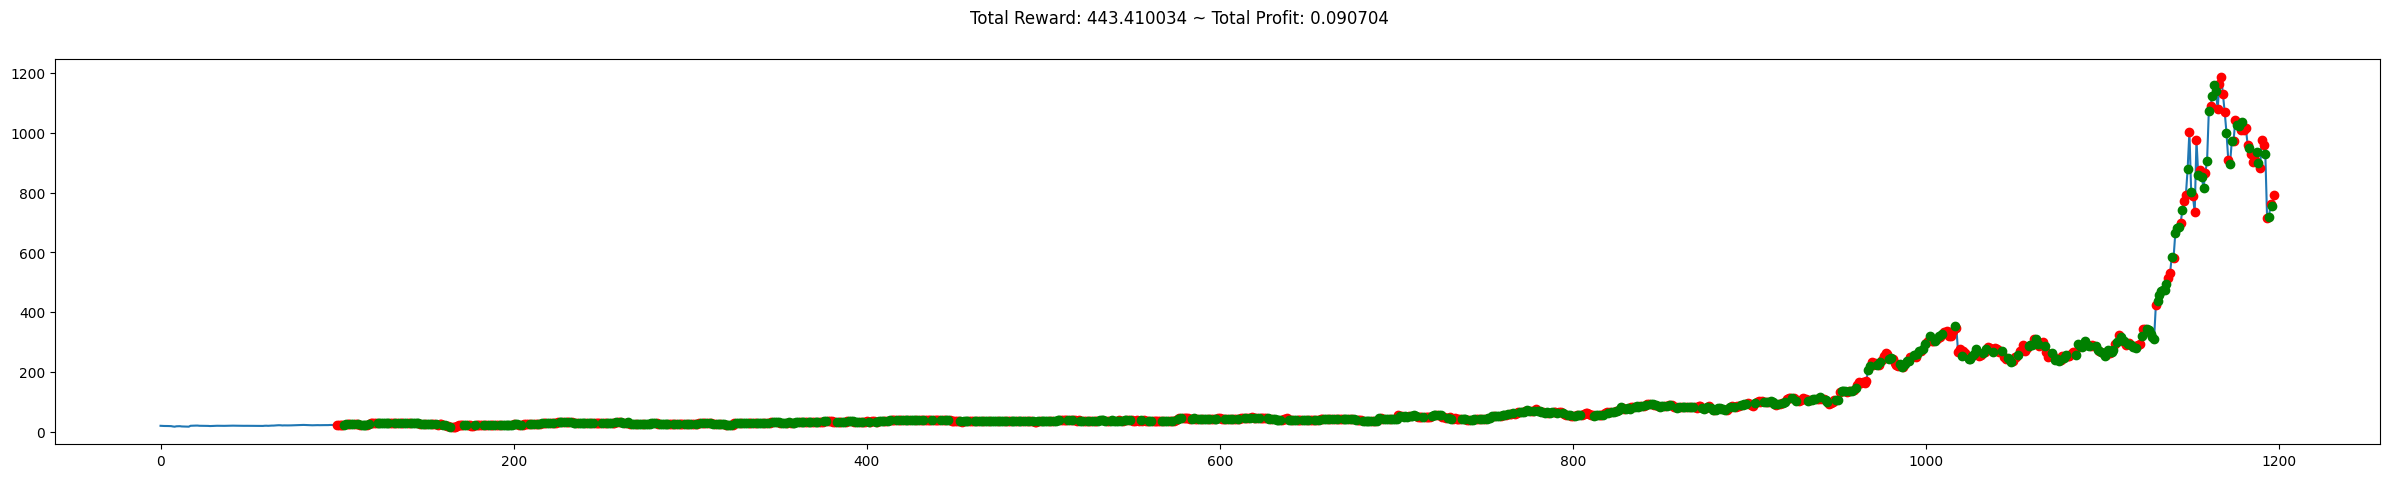

 50%|█████     | 5/10 [01:49<01:48, 21.74s/it]

Total reward accumulated during the test: 499.59007299999996


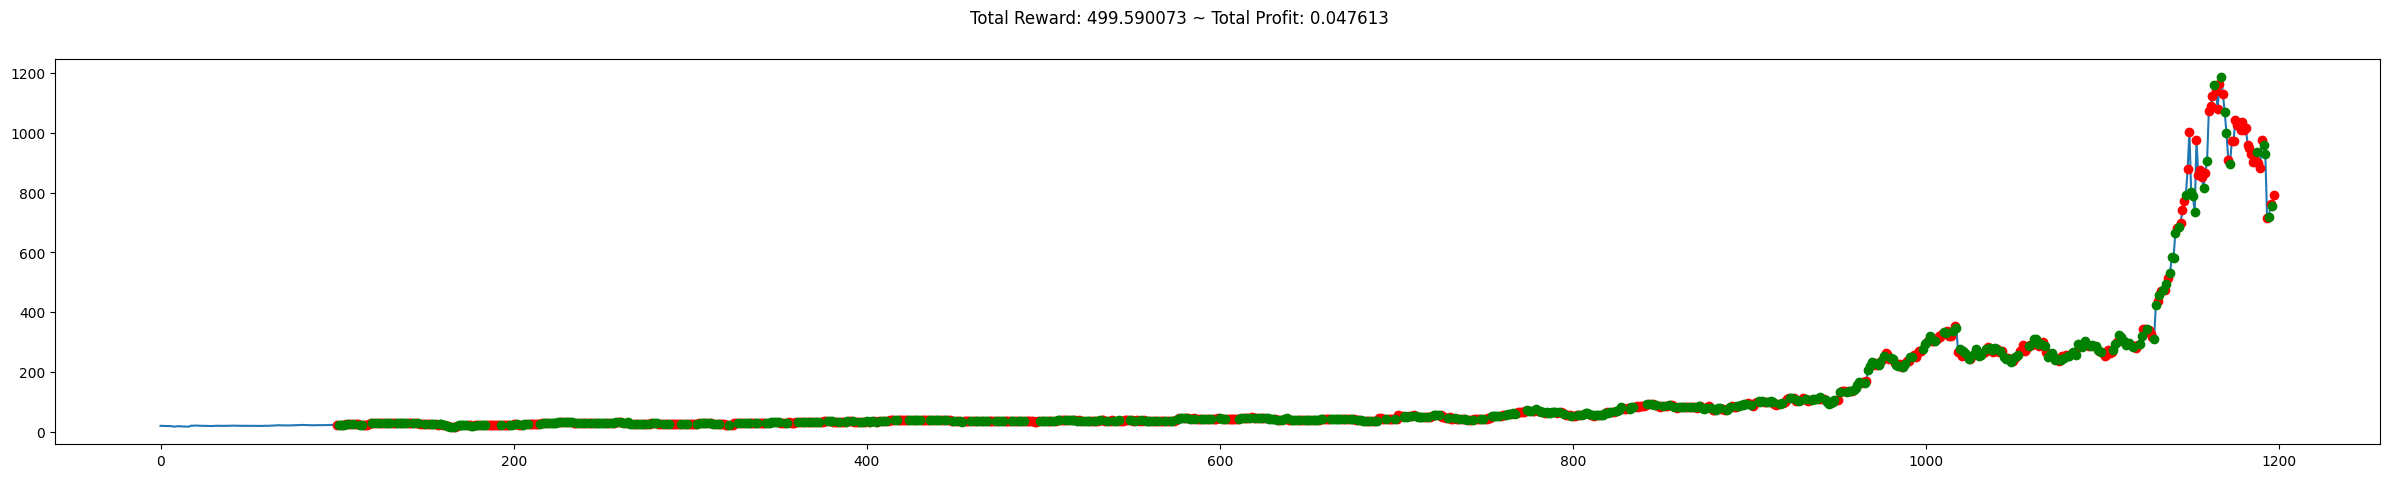

 60%|██████    | 6/10 [02:11<01:27, 21.81s/it]

Total reward accumulated during the test: 427.50011700000005


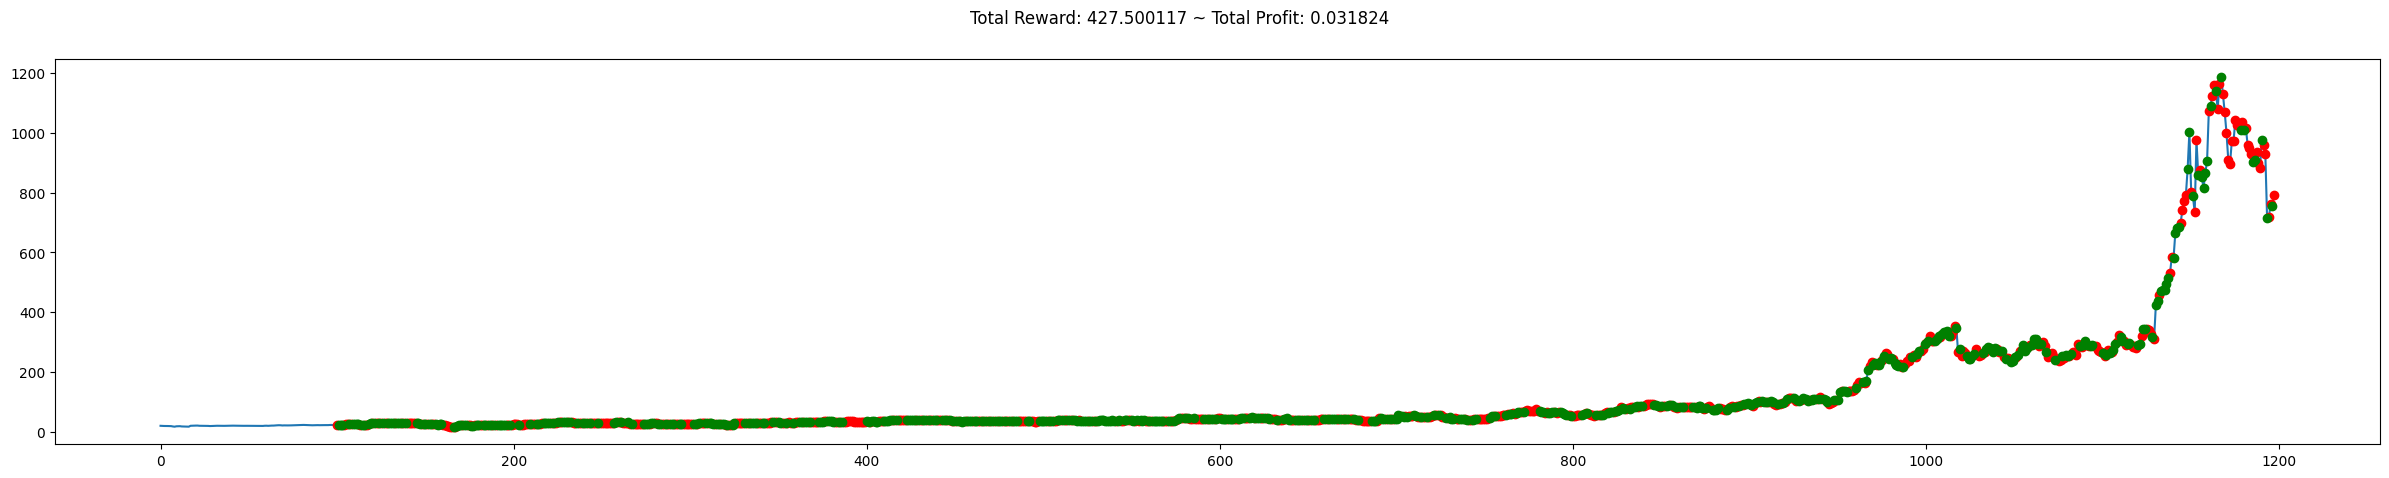

 70%|███████   | 7/10 [02:33<01:05, 21.82s/it]

Total reward accumulated during the test: 546.7297930000004


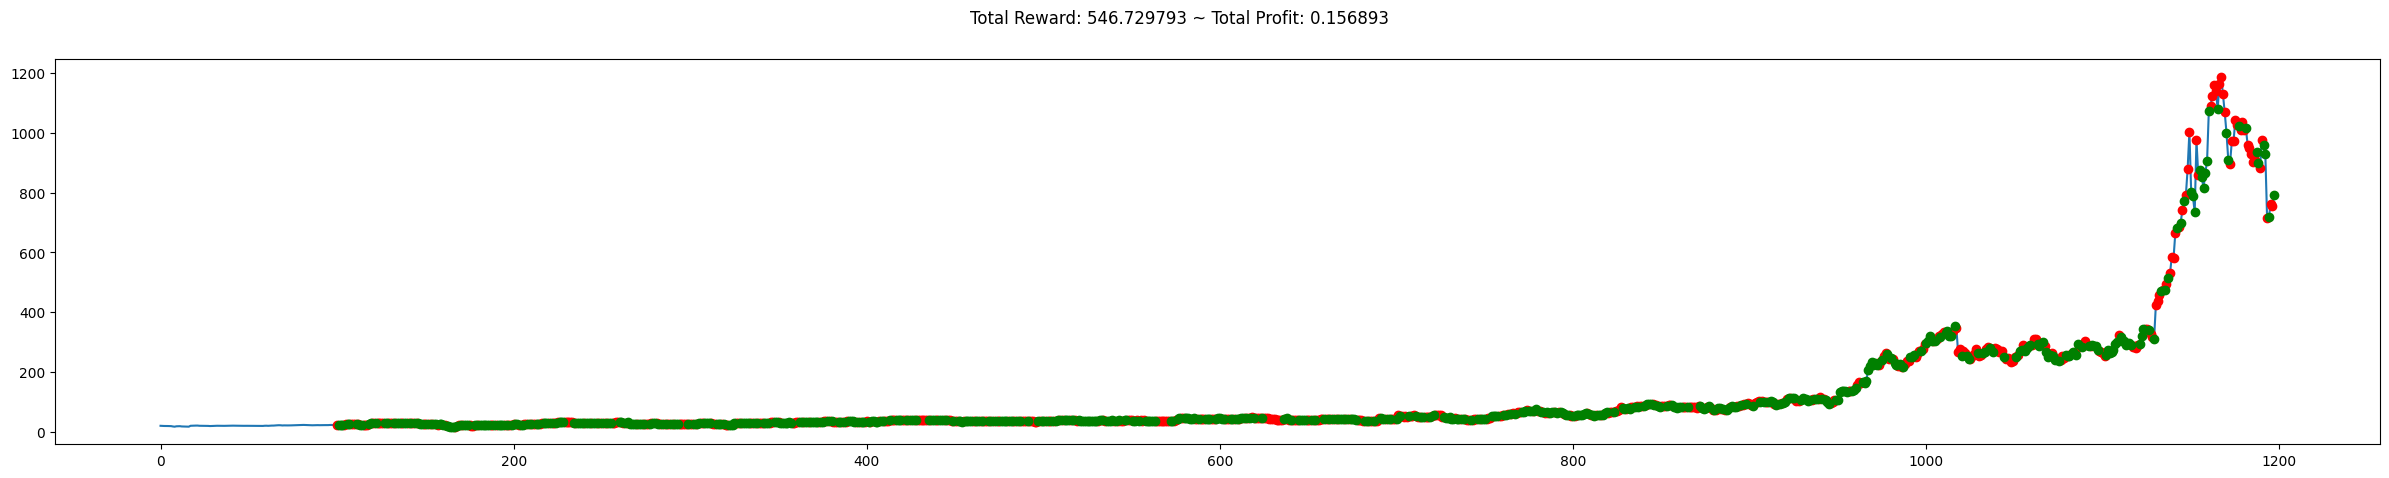

 80%|████████  | 8/10 [02:54<00:43, 21.70s/it]

Total reward accumulated during the test: 10.229783000000054


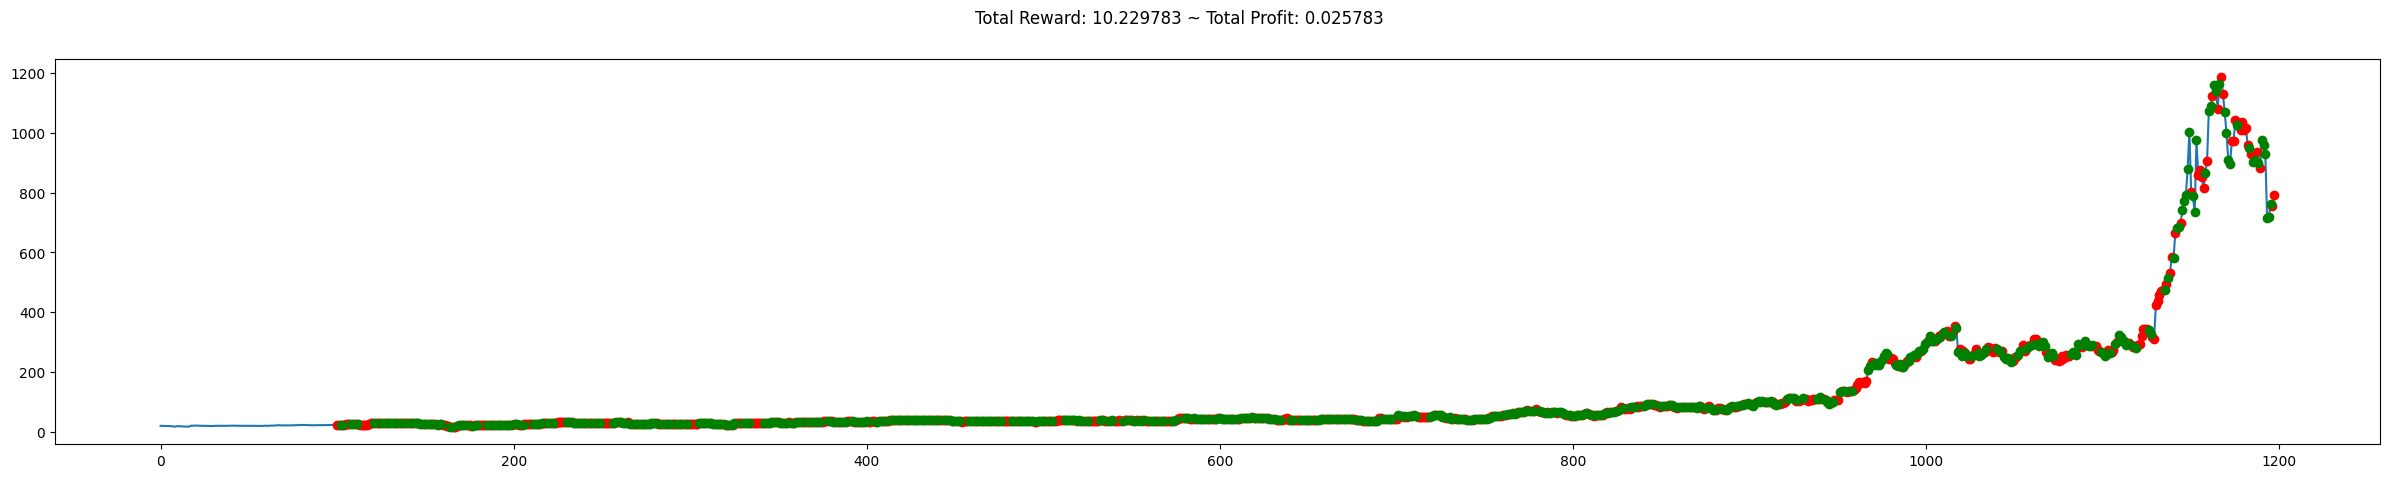

 90%|█████████ | 9/10 [03:16<00:21, 21.74s/it]

Total reward accumulated during the test: 421.04964799999993


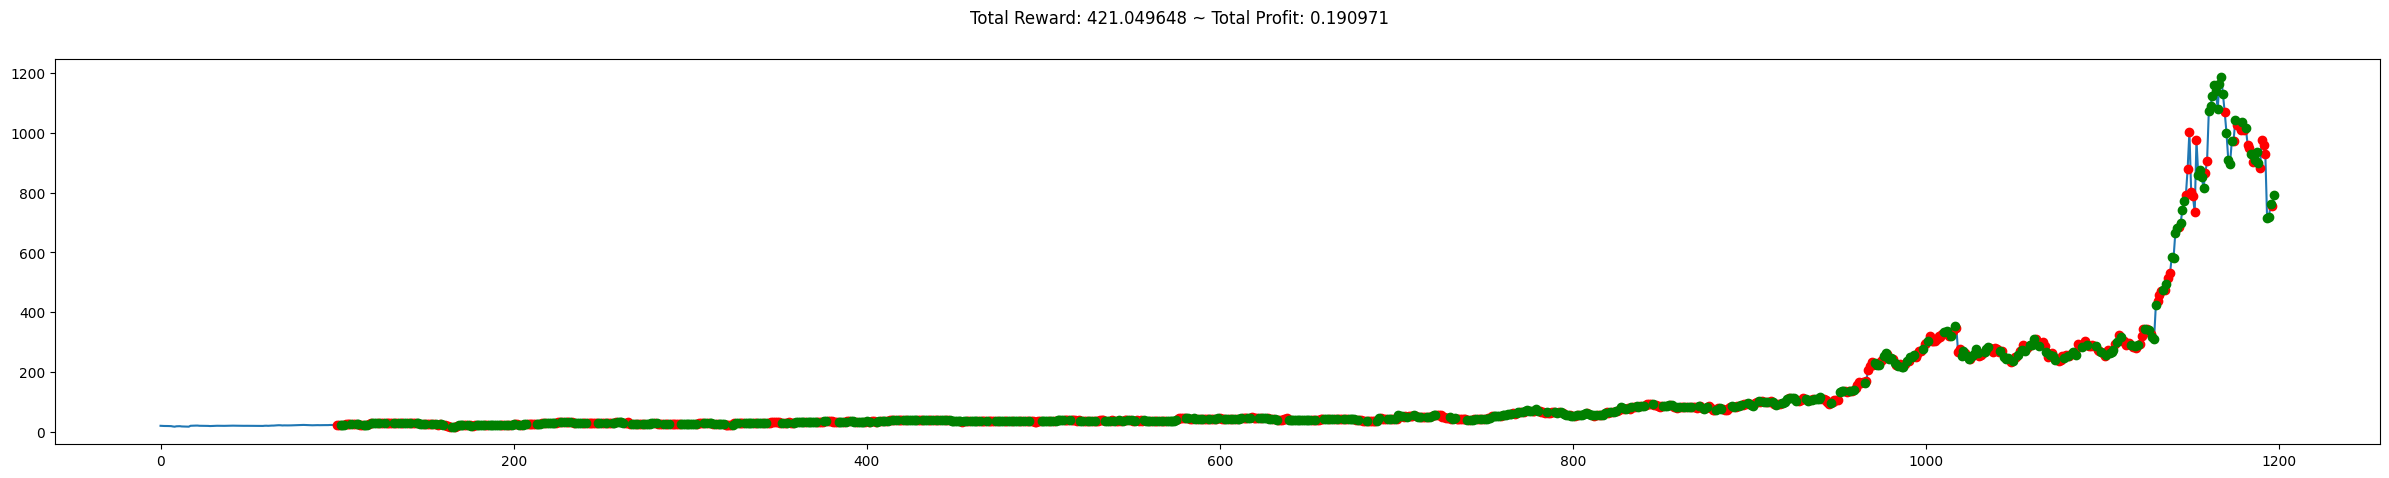

100%|██████████| 10/10 [03:38<00:00, 21.83s/it]


In [ ]:
evla_custom_model(env_test, actor, num_eval=10)

# Modifying Custom Model Hyperparameters

* Increasing No of layers
* Increasing No of LSTM Units
* Training longer
* Training shorter

All the Hyperparameters tweaking is done on Custom Baseline model

## Increasing No of layers

### Defining Custom Model - Increasing No of layers

In [ ]:
## Actor Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(512, activation='relu')(lstm)
dense = Dense(256, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
logits = Dense(env_train.action_space.n, activation='sigmoid')(dense)
actor = Model(inputs=inputs, outputs=logits)

## Critic Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(512, activation='relu')(lstm)
dense = Dense(256, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
values = Dense(1, activation='relu')(dense)
critic = Model(inputs=inputs, outputs=values)

## PPO Algorithm
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
huber_loss = tf.keras.losses.Huber()
entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

### Training Custom Model

In [ ]:
train_ppo(env_train, actor, critic, num_episodes=20)

  5%|▌         | 1/20 [02:59<56:50, 179.48s/it]

Episode: 0, Total Reward: -4.390004000000015, loss: 0.44227227568626404


 10%|█         | 2/20 [05:49<52:12, 174.02s/it]

Episode: 1, Total Reward: 15.270002999999996, loss: 0.38792622089385986


 15%|█▌        | 3/20 [08:38<48:36, 171.56s/it]

Episode: 2, Total Reward: 24.90998300000003, loss: 0.2210298776626587


 20%|██        | 4/20 [11:25<45:20, 170.03s/it]

Episode: 3, Total Reward: 13.510009999999978, loss: 0.3497237265110016


 25%|██▌       | 5/20 [14:13<42:15, 169.04s/it]

Episode: 4, Total Reward: 6.879970000000036, loss: 0.45089390873908997


 30%|███       | 6/20 [16:59<39:11, 168.00s/it]

Episode: 5, Total Reward: -12.229985000000042, loss: 0.5277112126350403


 35%|███▌      | 7/20 [19:44<36:11, 167.02s/it]

Episode: 6, Total Reward: -2.590012000000014, loss: 0.4419667720794678


 40%|████      | 8/20 [22:32<33:28, 167.36s/it]

Episode: 7, Total Reward: 10.979991000000012, loss: 0.3544512689113617


 45%|████▌     | 9/20 [25:20<30:43, 167.64s/it]

Episode: 8, Total Reward: 2.459999000000016, loss: 0.4068896770477295


 50%|█████     | 10/20 [28:08<27:56, 167.66s/it]

Episode: 9, Total Reward: 24.290053999999976, loss: 0.30147692561149597


 55%|█████▌    | 11/20 [30:56<25:11, 167.94s/it]

Episode: 10, Total Reward: 31.420024999999974, loss: 0.2348366677761078


 60%|██████    | 12/20 [33:47<22:29, 168.63s/it]

Episode: 11, Total Reward: -17.95002199999996, loss: 0.5707041025161743


 65%|██████▌   | 13/20 [36:33<19:35, 167.90s/it]

Episode: 12, Total Reward: 5.499960999999978, loss: 0.4200875163078308


 70%|███████   | 14/20 [39:23<16:51, 168.51s/it]

Episode: 13, Total Reward: 6.210011000000053, loss: 0.40043097734451294


 75%|███████▌  | 15/20 [42:13<14:05, 169.10s/it]

Episode: 14, Total Reward: -12.11001499999998, loss: 0.5856578350067139


 80%|████████  | 16/20 [45:02<11:15, 168.92s/it]

Episode: 15, Total Reward: 18.859965999999996, loss: 0.40071356296539307


 85%|████████▌ | 17/20 [47:53<08:28, 169.56s/it]

Episode: 16, Total Reward: 17.12999799999997, loss: 0.2822642922401428


 90%|█████████ | 18/20 [50:42<05:39, 169.59s/it]

Episode: 17, Total Reward: 20.72998900000003, loss: 0.27989059686660767


 95%|█████████▌| 19/20 [53:28<02:48, 168.54s/it]

Episode: 18, Total Reward: -2.739996000000005, loss: 0.5321180820465088


100%|██████████| 20/20 [56:17<00:00, 168.87s/it]

Episode: 19, Total Reward: -5.019986000000049, loss: 0.5035529136657715
total_reward:  [-4.390004000000015, 15.270002999999996, 24.90998300000003, 13.510009999999978, 6.879970000000036, -12.229985000000042, -2.590012000000014, 10.979991000000012, 2.459999000000016, 24.290053999999976, 31.420024999999974, -17.95002199999996, 5.499960999999978, 6.210011000000053, -12.11001499999998, 18.859965999999996, 17.12999799999997, 20.72998900000003, -2.739996000000005, -5.019986000000049]


### Testing Custom Model

  0%|          | 0/10 [00:00<?, ?it/s]

Total reward accumulated during the test: 157.15979900000002


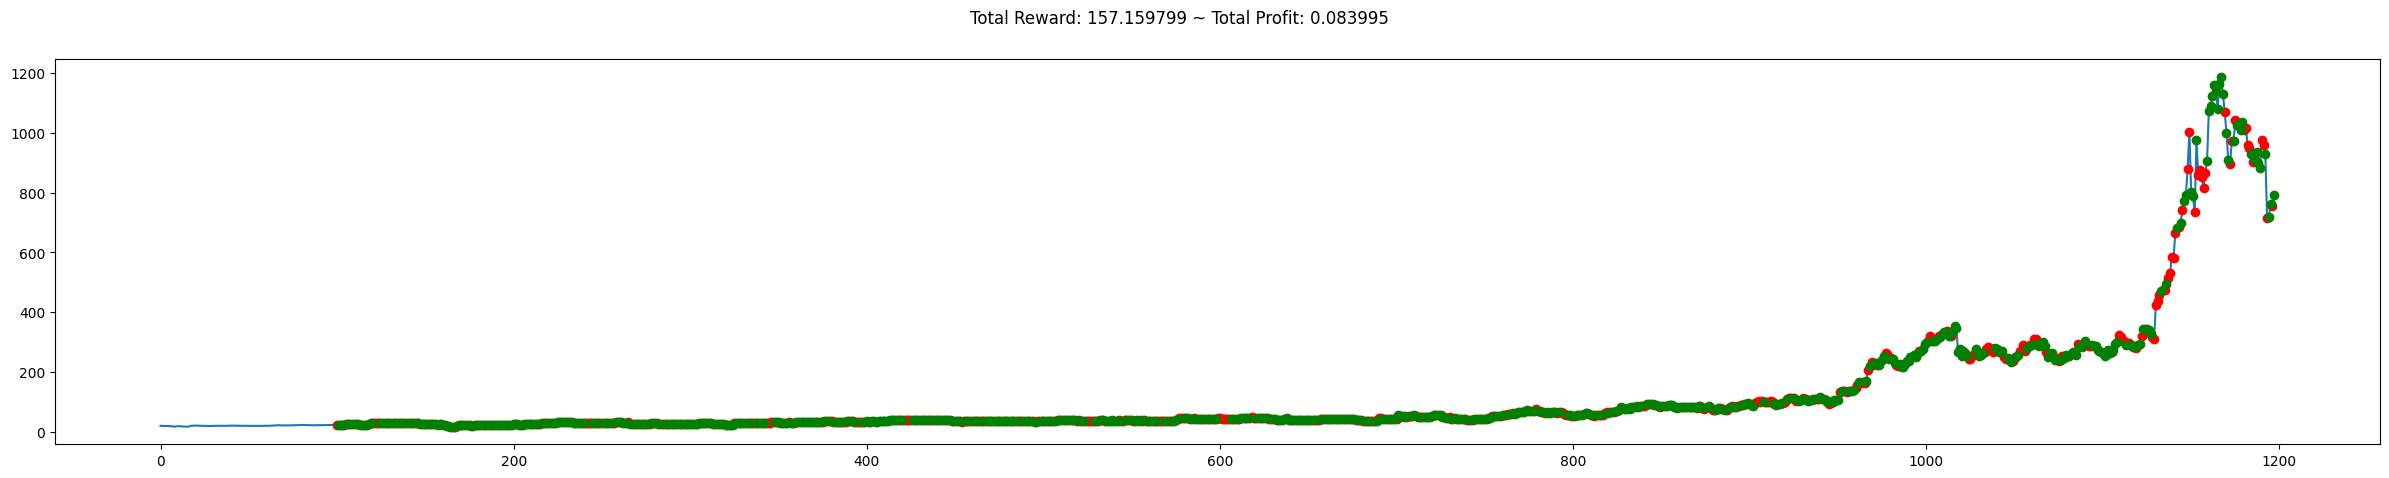

 10%|█         | 1/10 [00:29<04:21, 29.05s/it]

Total reward accumulated during the test: 1012.7599969999999


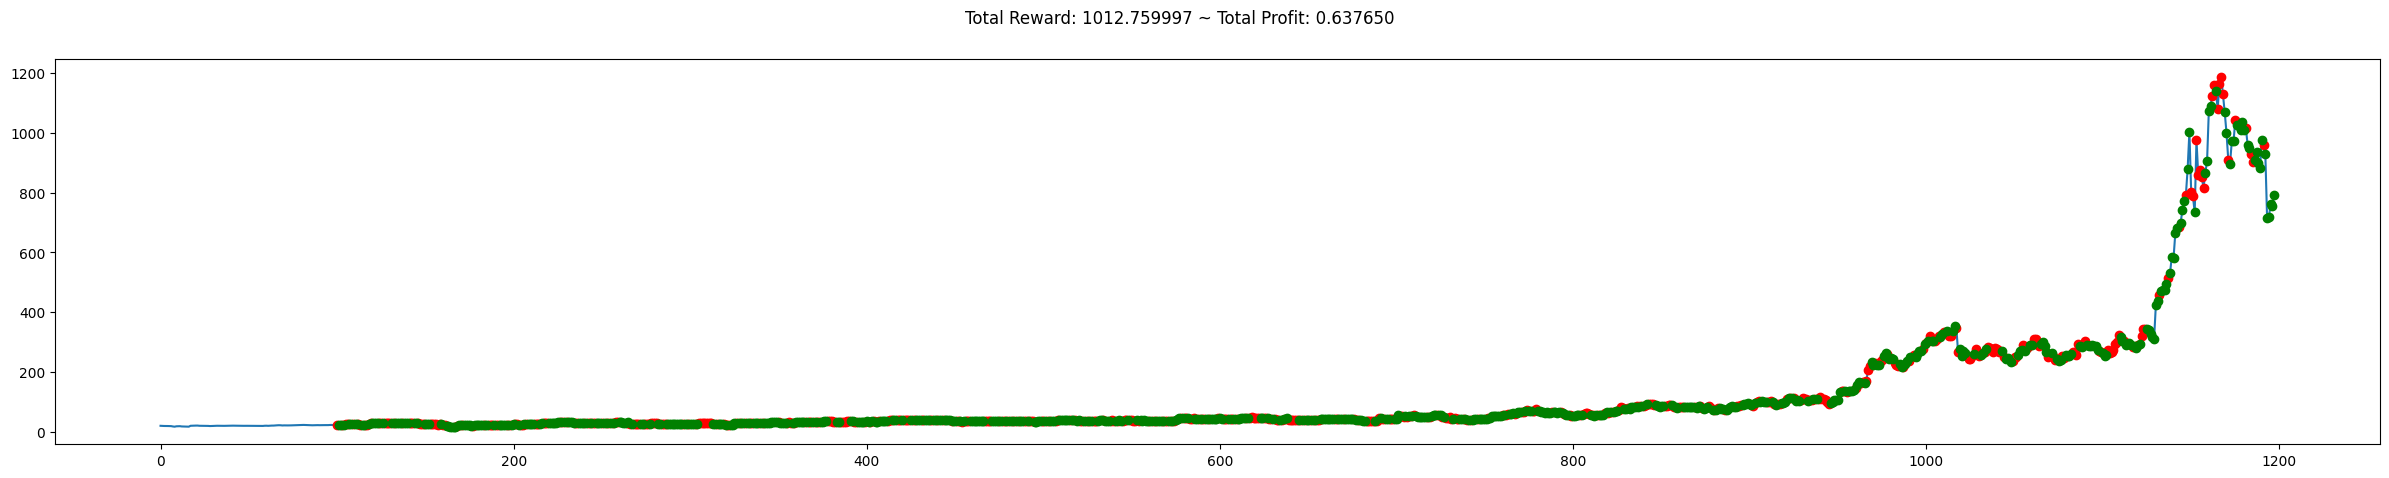

 20%|██        | 2/10 [00:58<03:56, 29.51s/it]

Total reward accumulated during the test: 165.0298560000001


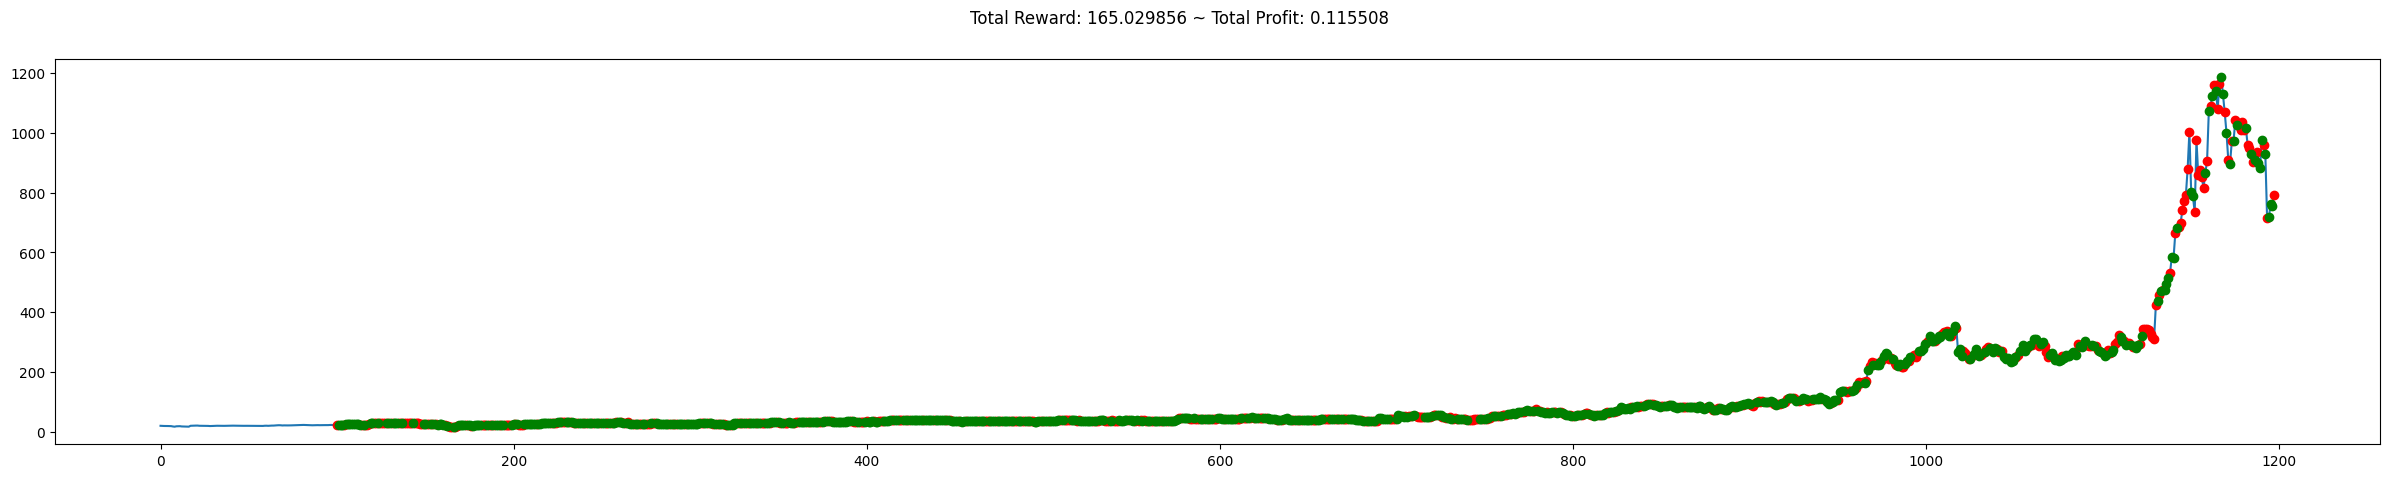

 30%|███       | 3/10 [01:27<03:25, 29.30s/it]

Total reward accumulated during the test: 342.90997900000013


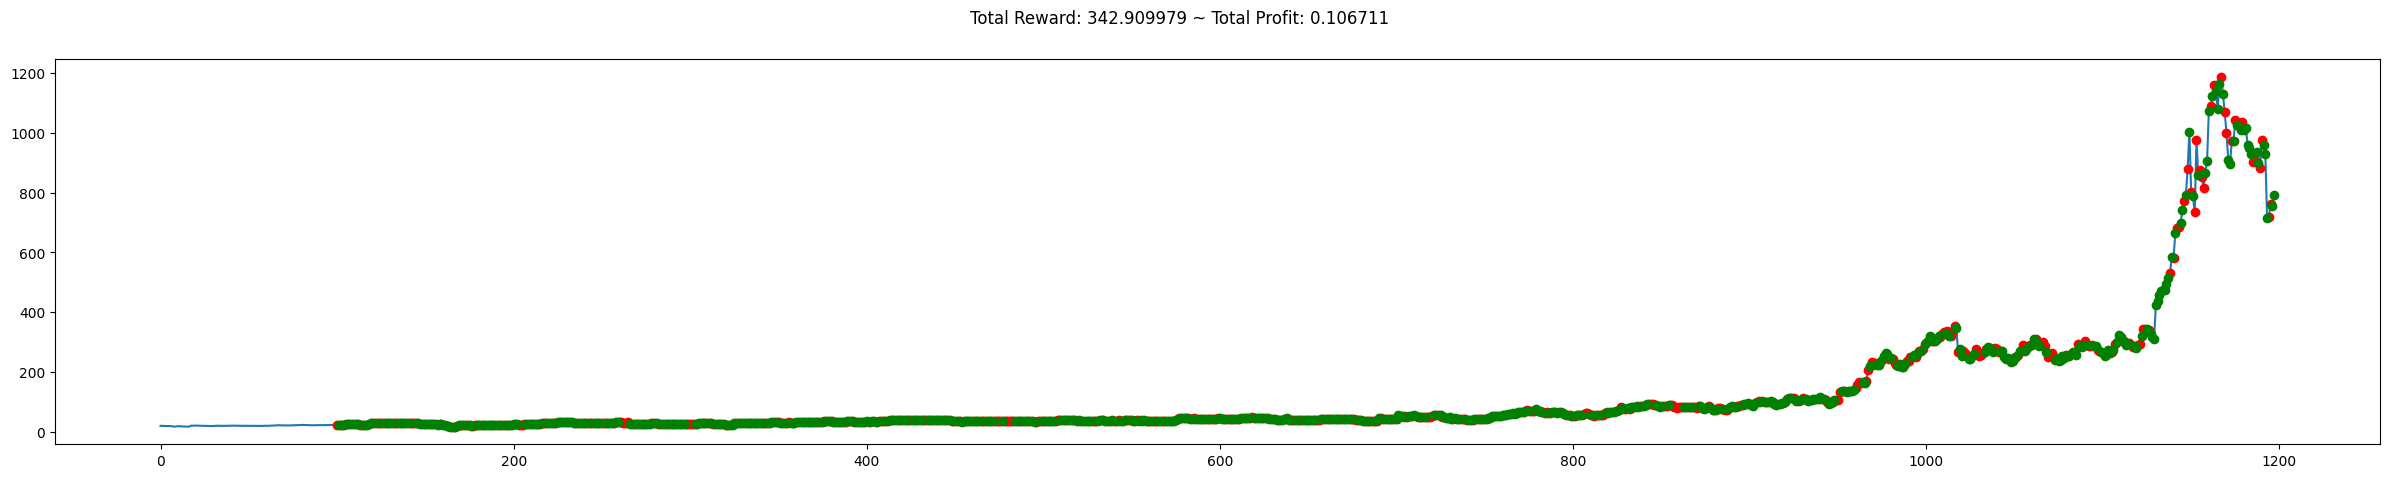

 40%|████      | 4/10 [01:57<02:56, 29.48s/it]

Total reward accumulated during the test: 376.01996199999985


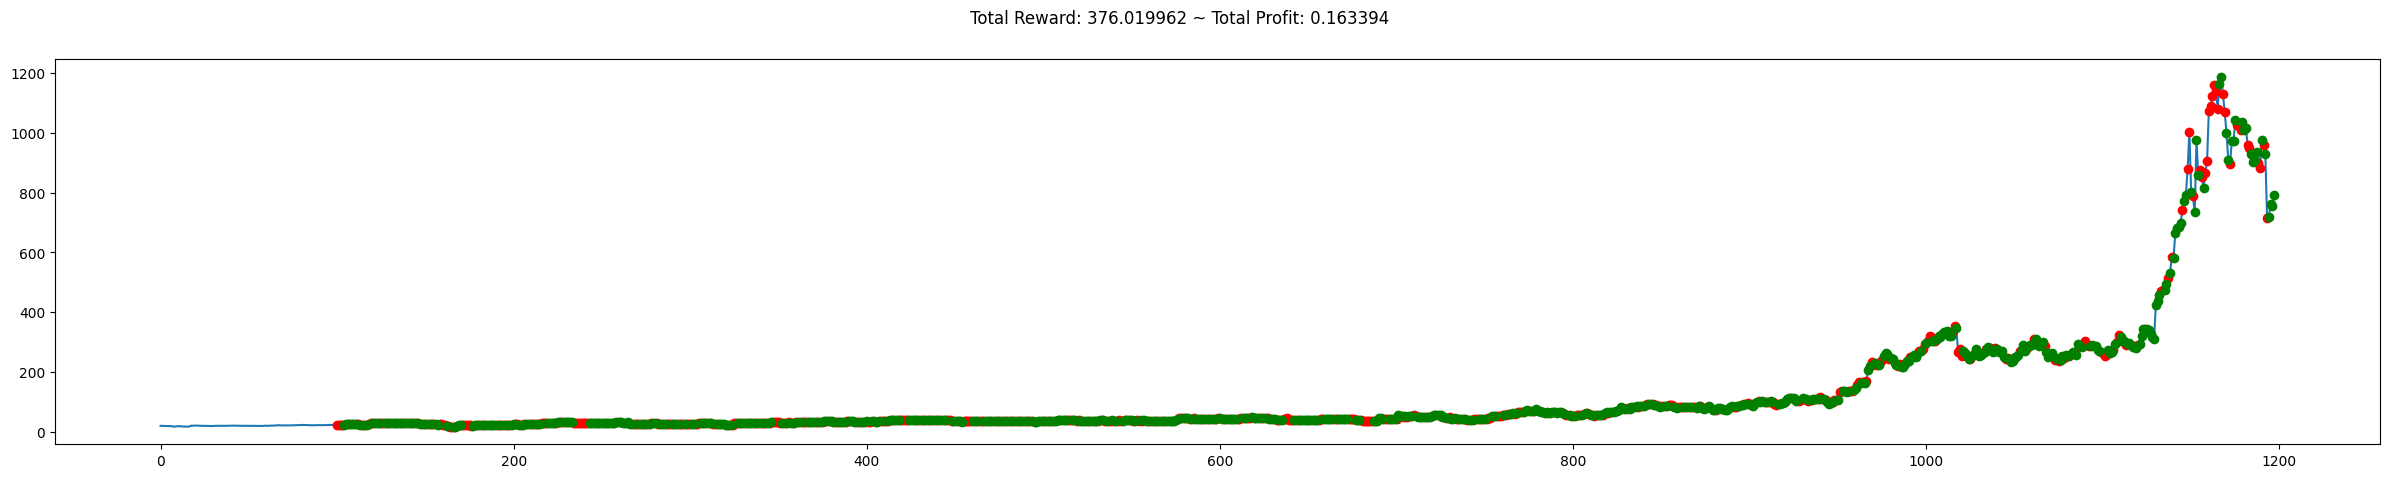

 50%|█████     | 5/10 [02:27<02:27, 29.59s/it]

Total reward accumulated during the test: 645.0299630000003


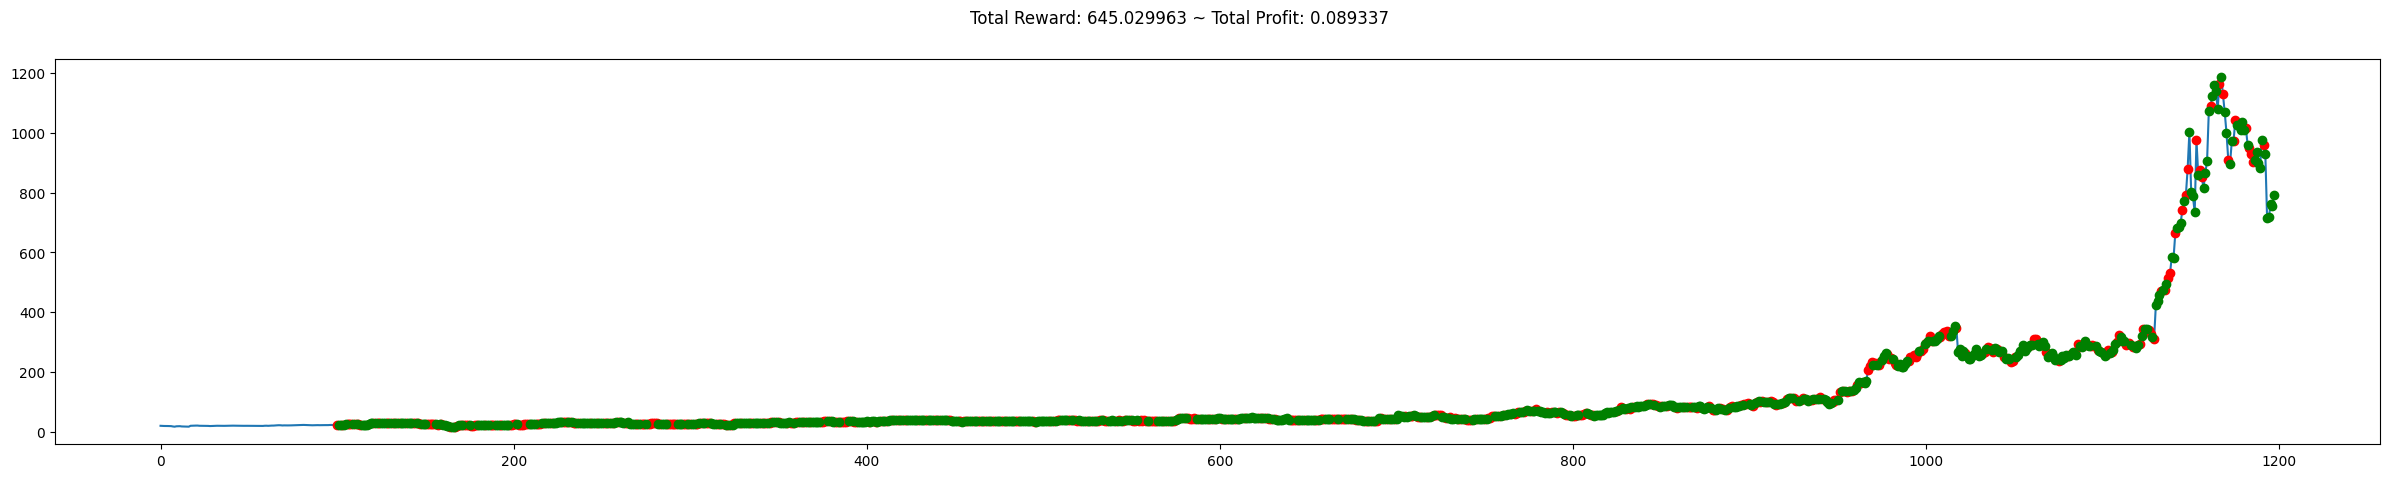

 60%|██████    | 6/10 [02:56<01:58, 29.50s/it]

Total reward accumulated during the test: 339.6802120000002


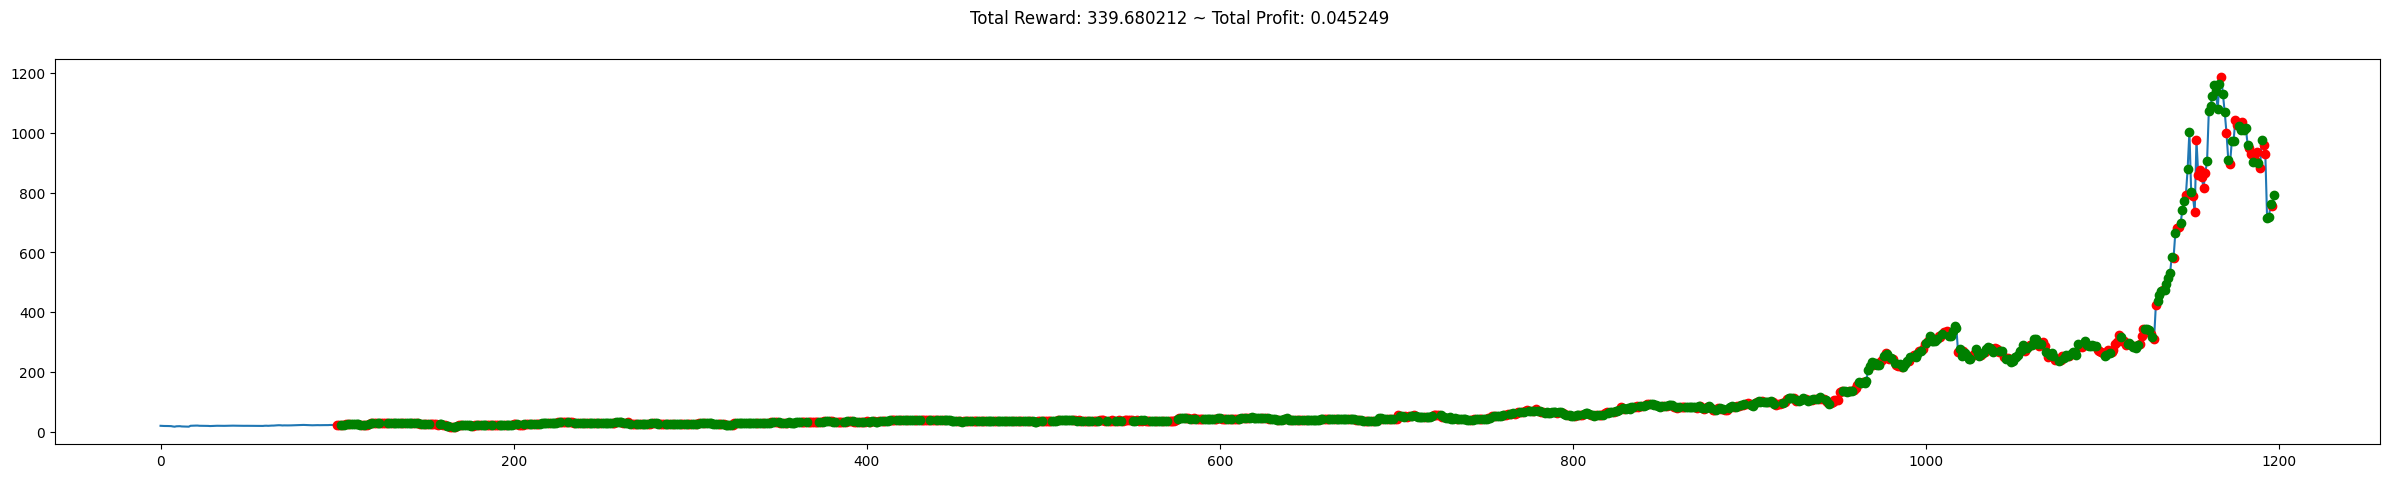

 70%|███████   | 7/10 [03:26<01:28, 29.63s/it]

Total reward accumulated during the test: 207.65978200000018


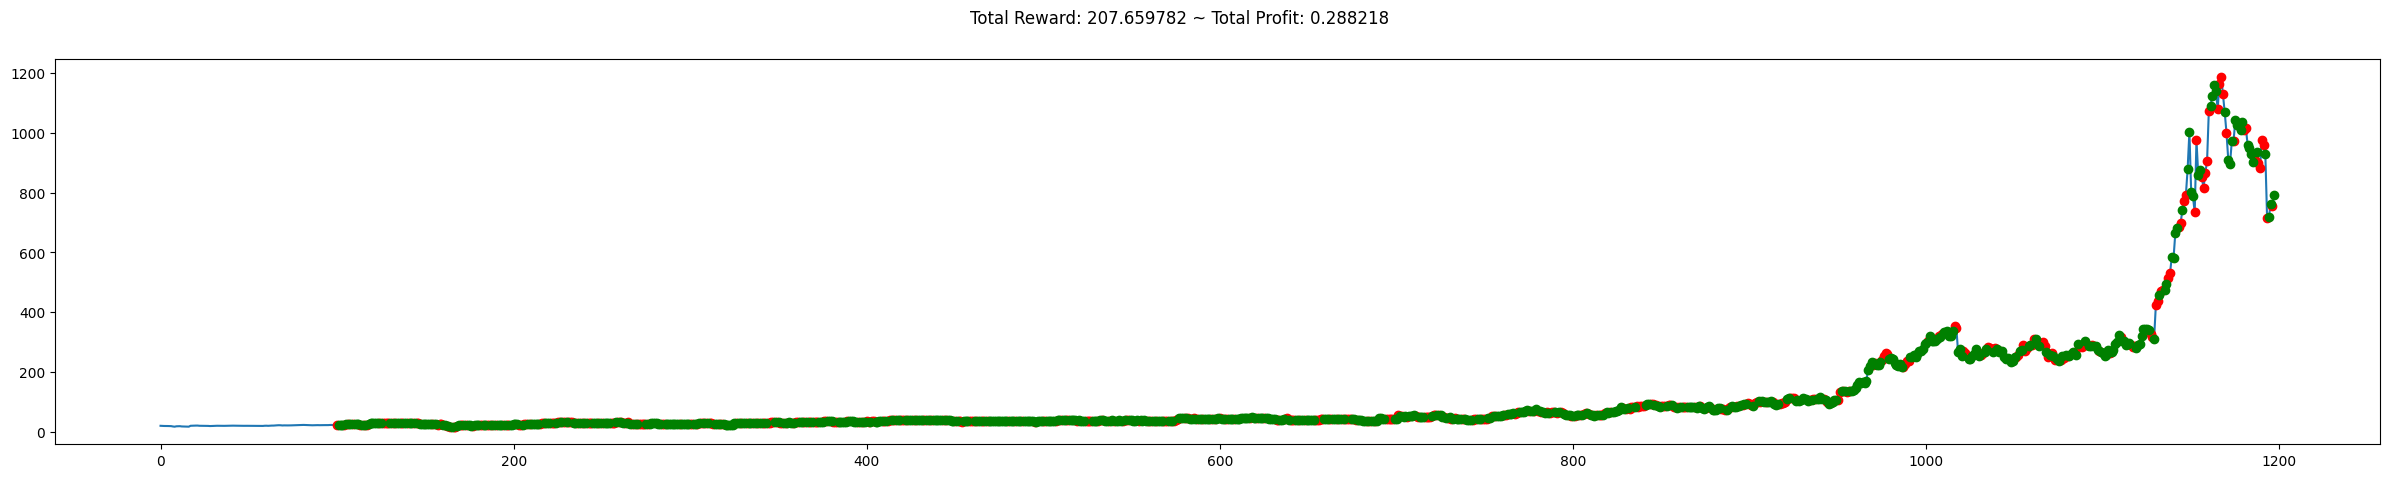

 80%|████████  | 8/10 [03:56<00:59, 29.70s/it]

Total reward accumulated during the test: 127.40964199999996


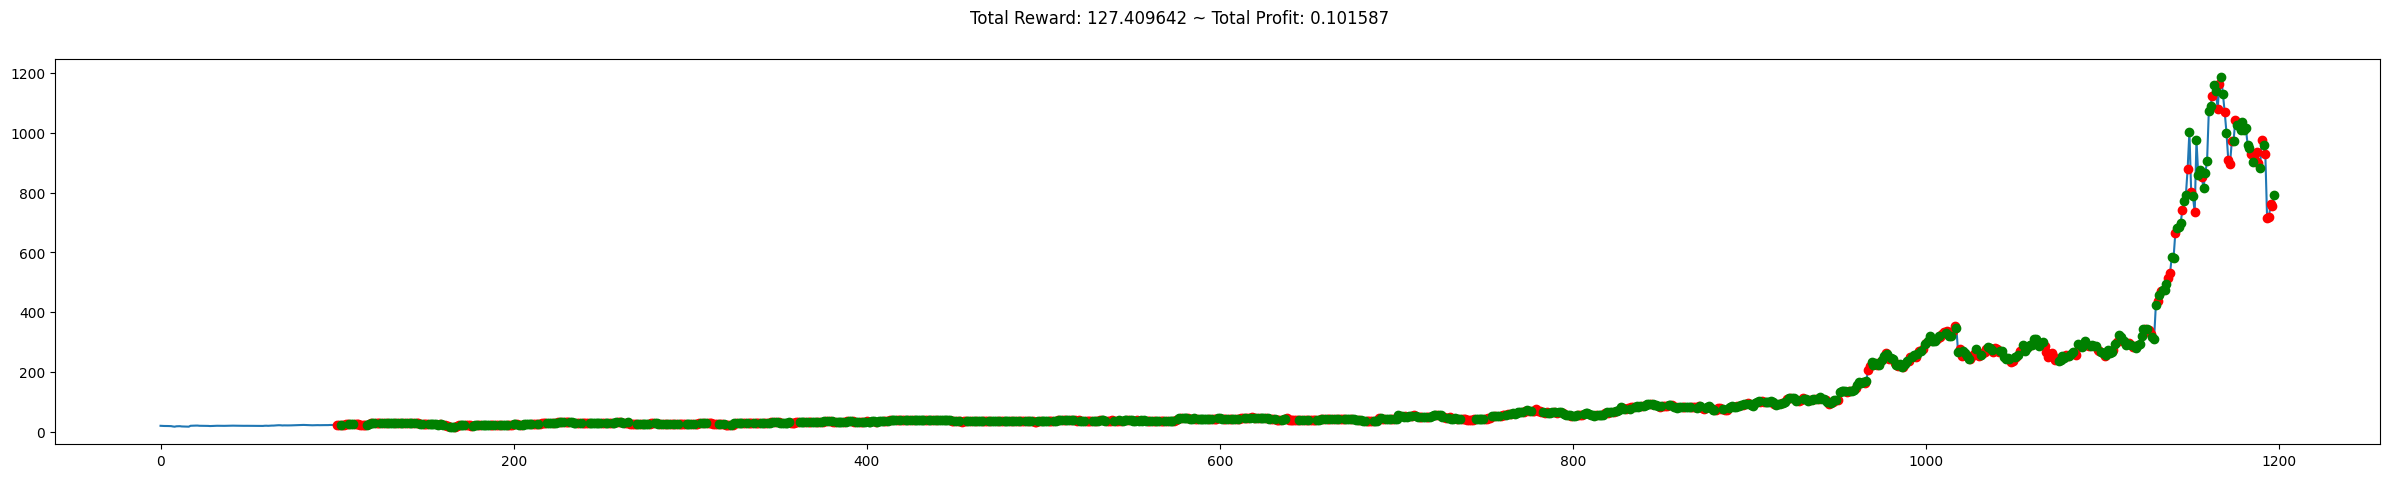

 90%|█████████ | 9/10 [04:25<00:29, 29.50s/it]

Total reward accumulated during the test: 116.57996700000024


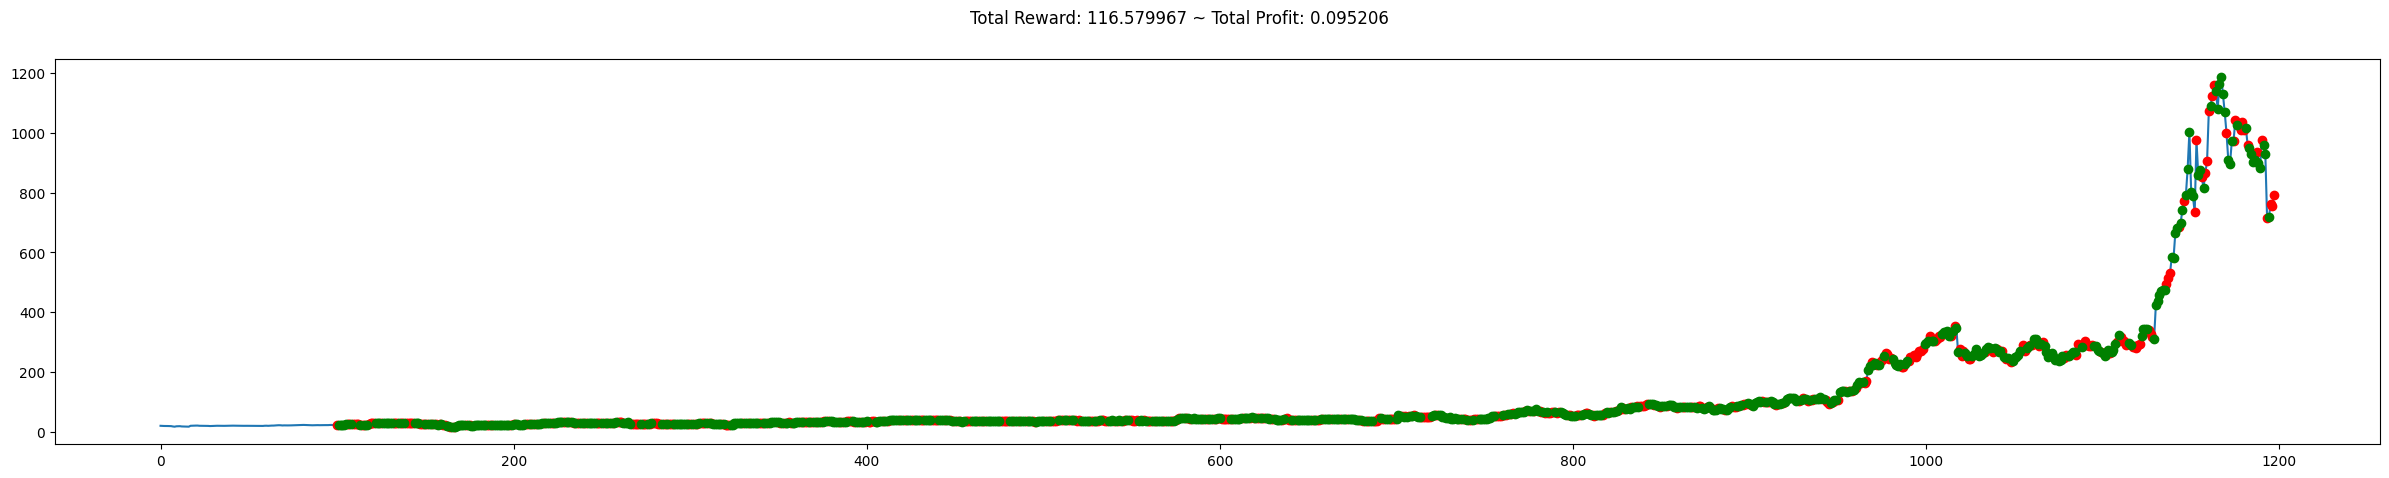

100%|██████████| 10/10 [04:54<00:00, 29.47s/it]


In [ ]:
evla_custom_model(env_test, actor)

## Increasing No of LSTM Units

### Defining Custom Model - Increasing No of LSTM Units

In [ ]:
## Actor Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(512, return_sequences=True)(inputs)
dense = Dense(1024, activation='relu')(lstm)
logits = Dense(env_train.action_space.n, activation='sigmoid')(dense)
actor = Model(inputs=inputs, outputs=logits)

## Critic Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(512, return_sequences=True)(inputs)
dense = Dense(1024, activation='relu')(lstm)
values = Dense(1, activation='relu')(dense)
critic = Model(inputs=inputs, outputs=values)

## PPO Algorithm
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
huber_loss = tf.keras.losses.Huber()
entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

### Training Custom Model

In [ ]:
train_ppo(env_train, actor, critic, num_episodes=20)

  5%|▌         | 1/20 [01:17<24:24, 77.07s/it]

Episode: 0, Total Reward: 6.7100200000000445, loss: 0.39601731300354004


 10%|█         | 2/20 [02:24<21:27, 71.55s/it]

Episode: 1, Total Reward: 13.869992000000003, loss: 0.3534773588180542


 15%|█▌        | 3/20 [03:32<19:49, 69.95s/it]

Episode: 2, Total Reward: 15.009967000000024, loss: 0.3627122938632965


 20%|██        | 4/20 [04:40<18:27, 69.19s/it]

Episode: 3, Total Reward: 32.230009999999965, loss: 0.2624994218349457


 25%|██▌       | 5/20 [05:47<17:06, 68.45s/it]

Episode: 4, Total Reward: -16.84000399999997, loss: 0.5275692939758301


 30%|███       | 6/20 [06:56<15:56, 68.31s/it]

Episode: 5, Total Reward: 0.190033000000005, loss: 0.4636978507041931


 35%|███▌      | 7/20 [08:04<14:49, 68.44s/it]

Episode: 6, Total Reward: 12.239983000000029, loss: 0.47243666648864746


 40%|████      | 8/20 [09:12<13:39, 68.31s/it]

Episode: 7, Total Reward: -5.080016999999993, loss: 0.4415082335472107


 45%|████▌     | 9/20 [10:20<12:28, 68.04s/it]

Episode: 8, Total Reward: 5.500012000000057, loss: 0.44219329953193665


 50%|█████     | 10/20 [11:26<11:16, 67.61s/it]

Episode: 9, Total Reward: -16.53003399999999, loss: 0.5773617029190063


 55%|█████▌    | 11/20 [12:34<10:09, 67.70s/it]

Episode: 10, Total Reward: -21.17997699999997, loss: 0.6345918774604797


 60%|██████    | 12/20 [13:42<09:02, 67.84s/it]

Episode: 11, Total Reward: 0.8899790000000252, loss: 0.4651573896408081


 65%|██████▌   | 13/20 [14:49<07:53, 67.58s/it]

Episode: 12, Total Reward: -15.159967000000101, loss: 0.6235677003860474


 70%|███████   | 14/20 [15:58<06:47, 67.87s/it]

Episode: 13, Total Reward: 13.399994999999977, loss: 0.431792676448822


 75%|███████▌  | 15/20 [17:05<05:38, 67.61s/it]

Episode: 14, Total Reward: 5.170013999999972, loss: 0.4786030054092407


 80%|████████  | 16/20 [18:13<04:31, 67.76s/it]

Episode: 15, Total Reward: -8.61998999999998, loss: 0.5601773262023926


 85%|████████▌ | 17/20 [19:21<03:23, 67.88s/it]

Episode: 16, Total Reward: 7.130034000000041, loss: 0.47186121344566345


 90%|█████████ | 18/20 [20:28<02:14, 67.50s/it]

Episode: 17, Total Reward: -15.979999999999961, loss: 0.5426326990127563


 95%|█████████▌| 19/20 [21:36<01:07, 67.63s/it]

Episode: 18, Total Reward: -2.9899979999999964, loss: 0.5255581140518188


100%|██████████| 20/20 [22:42<00:00, 68.10s/it]

Episode: 19, Total Reward: 0.9099979999999448, loss: 0.4919619560241699
total_reward:  [6.7100200000000445, 13.869992000000003, 15.009967000000024, 32.230009999999965, -16.84000399999997, 0.190033000000005, 12.239983000000029, -5.080016999999993, 5.500012000000057, -16.53003399999999, -21.17997699999997, 0.8899790000000252, -15.159967000000101, 13.399994999999977, 5.170013999999972, -8.61998999999998, 7.130034000000041, -15.979999999999961, -2.9899979999999964, 0.9099979999999448]


### Testing Custom Model

  0%|          | 0/10 [00:00<?, ?it/s]

Total reward accumulated during the test: 1089.7700300000001


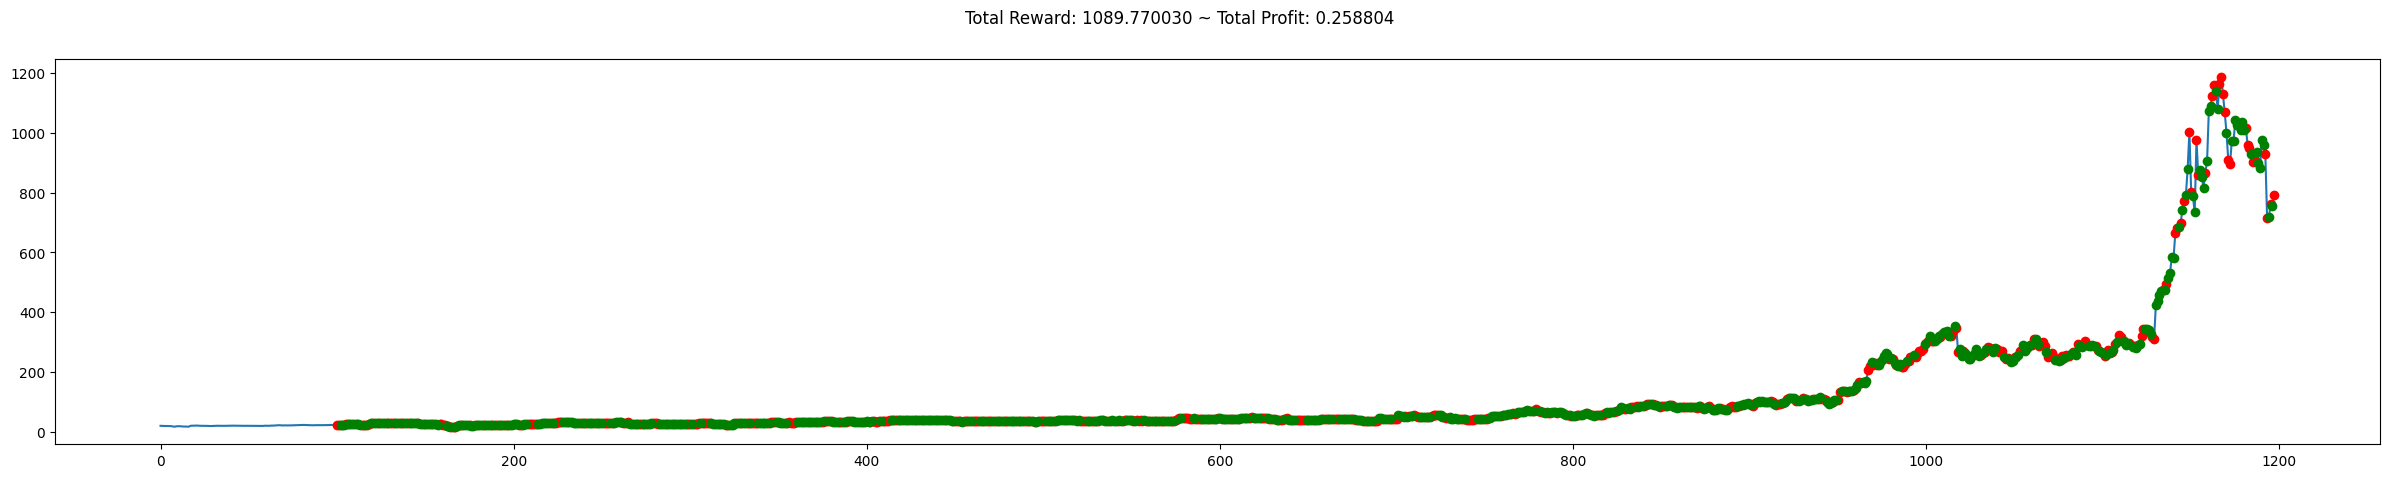

 10%|█         | 1/10 [00:11<01:40, 11.21s/it]

Total reward accumulated during the test: 628.2201220000002


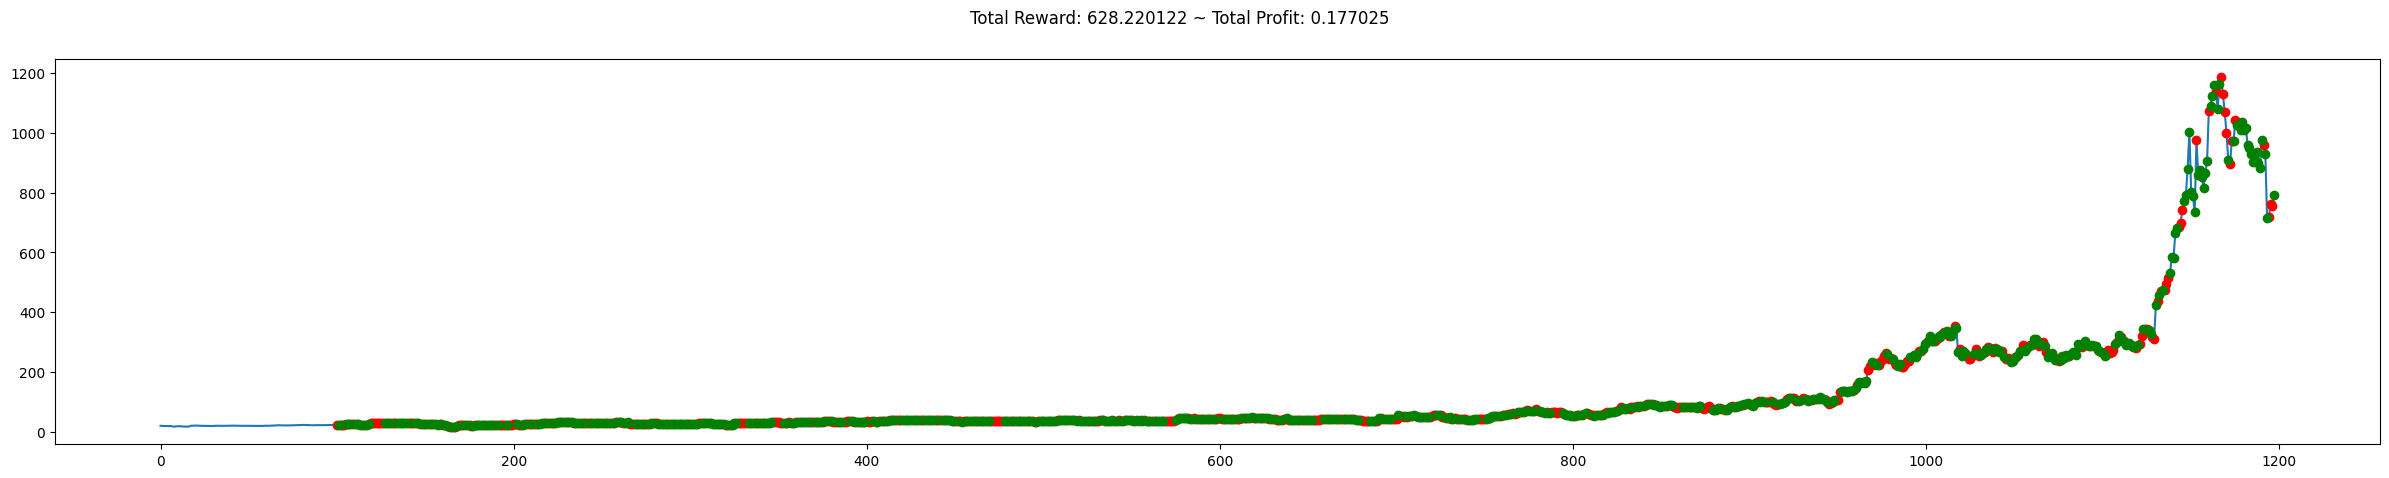

 20%|██        | 2/10 [00:22<01:30, 11.30s/it]

Total reward accumulated during the test: -72.69002199999966


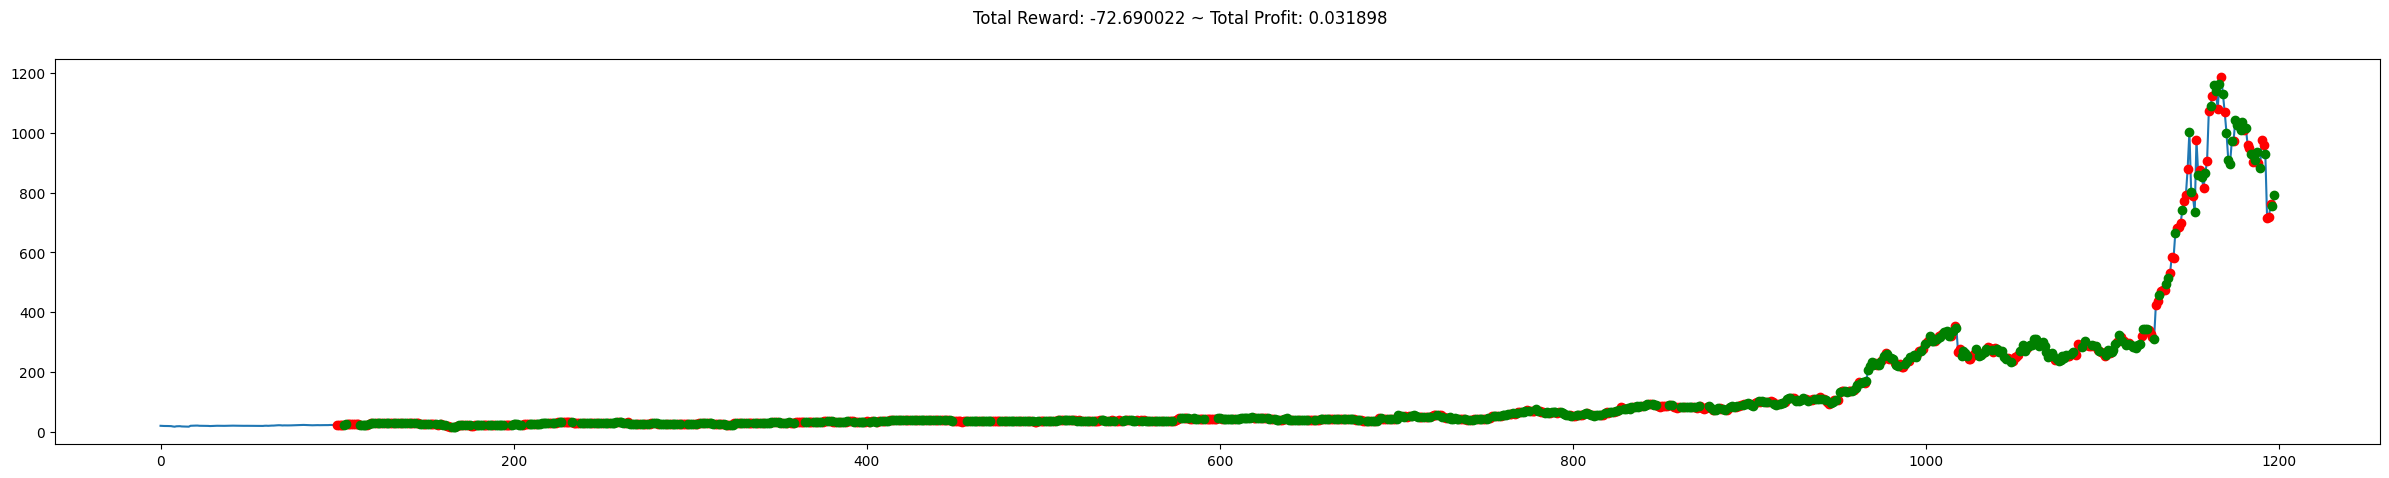

 30%|███       | 3/10 [00:34<01:19, 11.38s/it]

Total reward accumulated during the test: 803.0297840000002


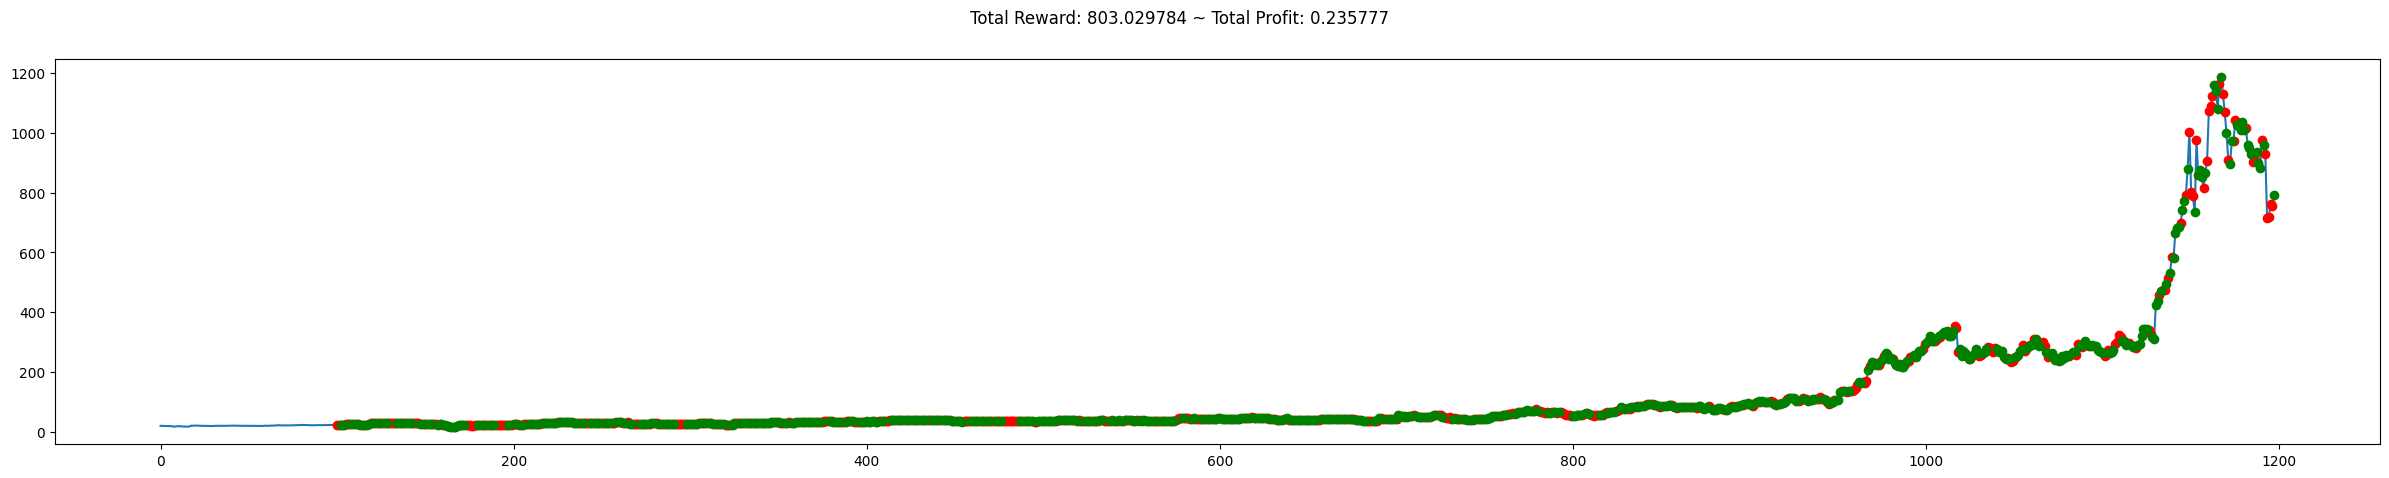

 40%|████      | 4/10 [00:45<01:08, 11.41s/it]

Total reward accumulated during the test: 488.109958


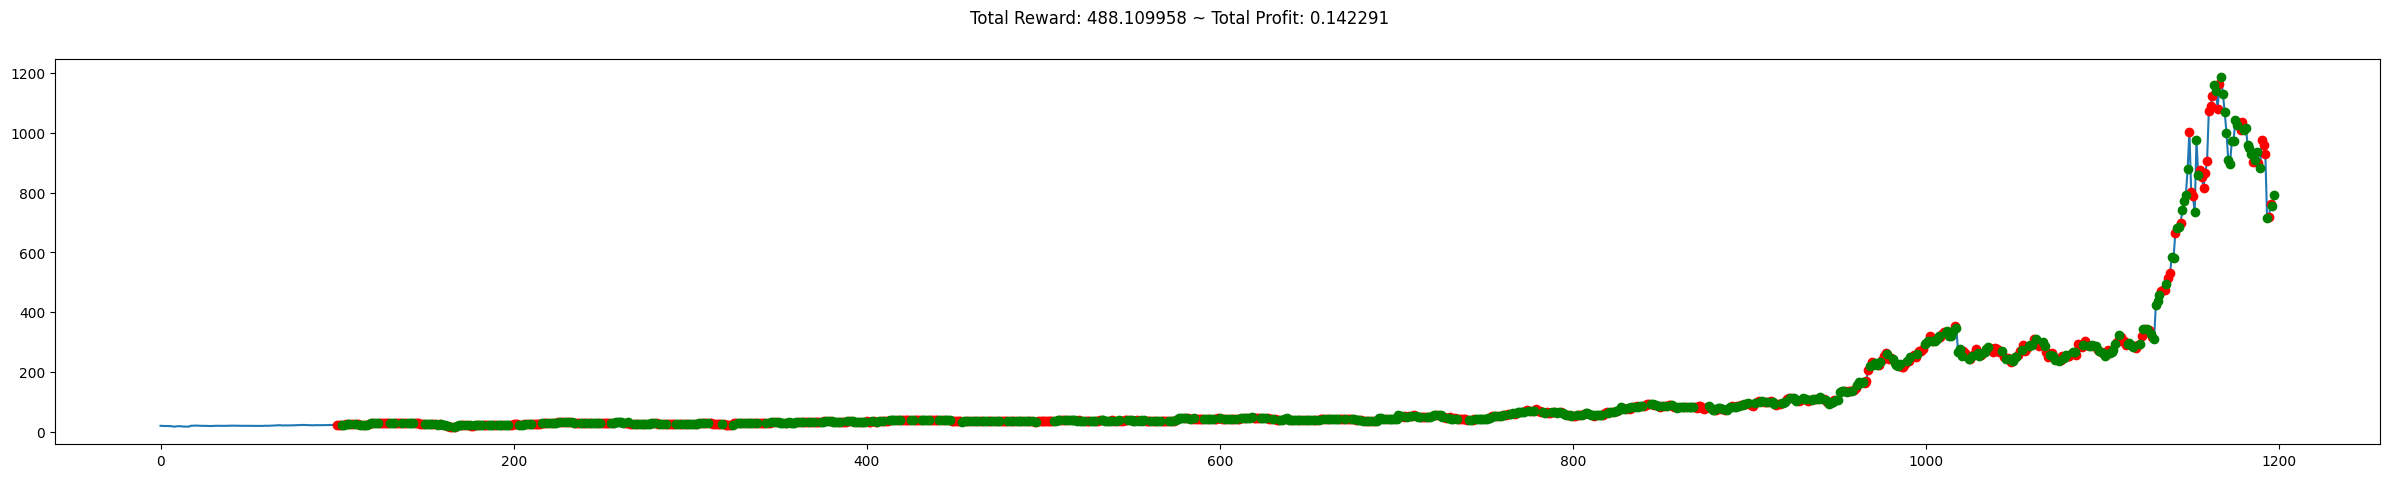

 50%|█████     | 5/10 [00:56<00:55, 11.17s/it]

Total reward accumulated during the test: 580.7200459999999


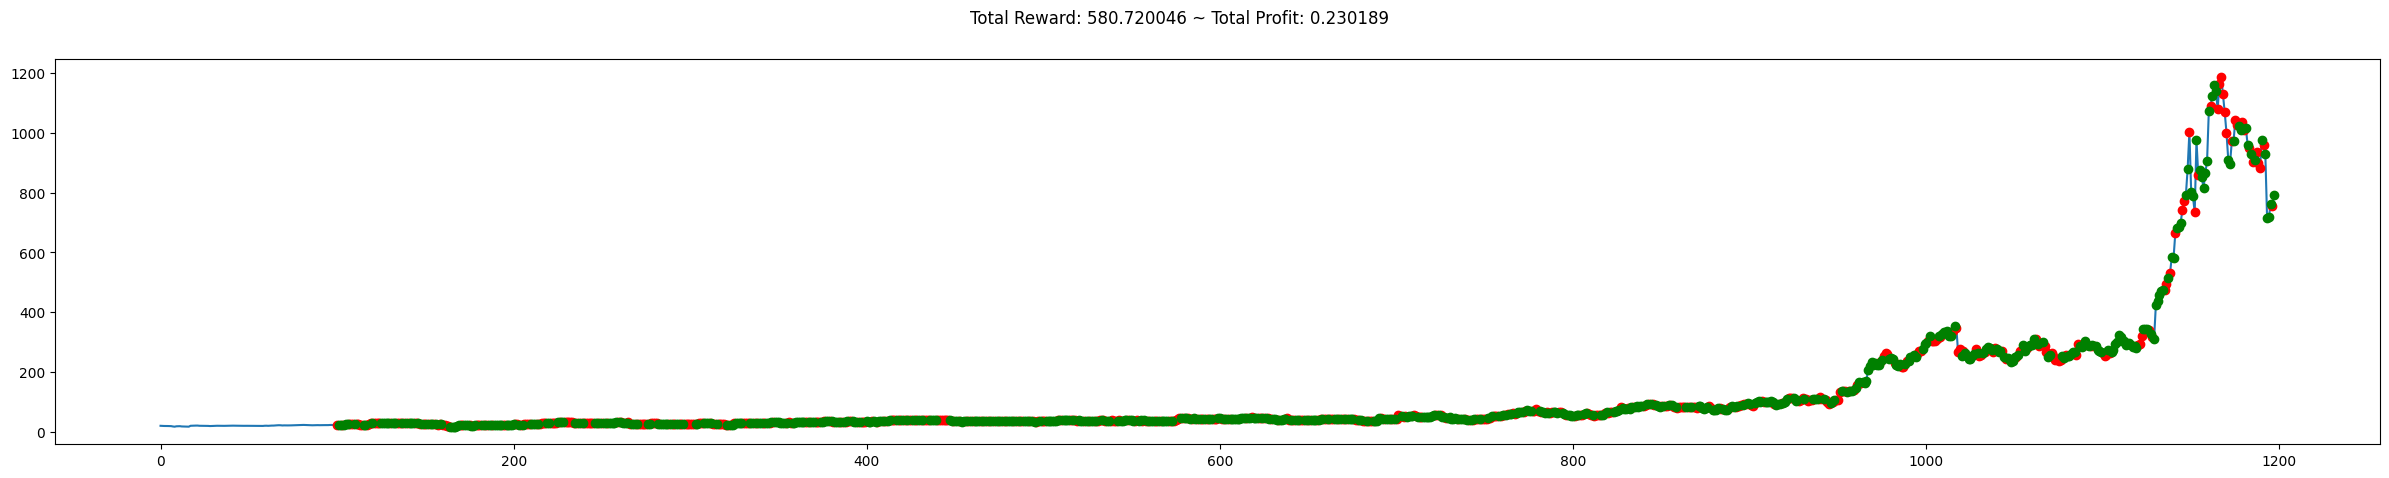

 60%|██████    | 6/10 [01:07<00:44, 11.12s/it]

Total reward accumulated during the test: 888.919986


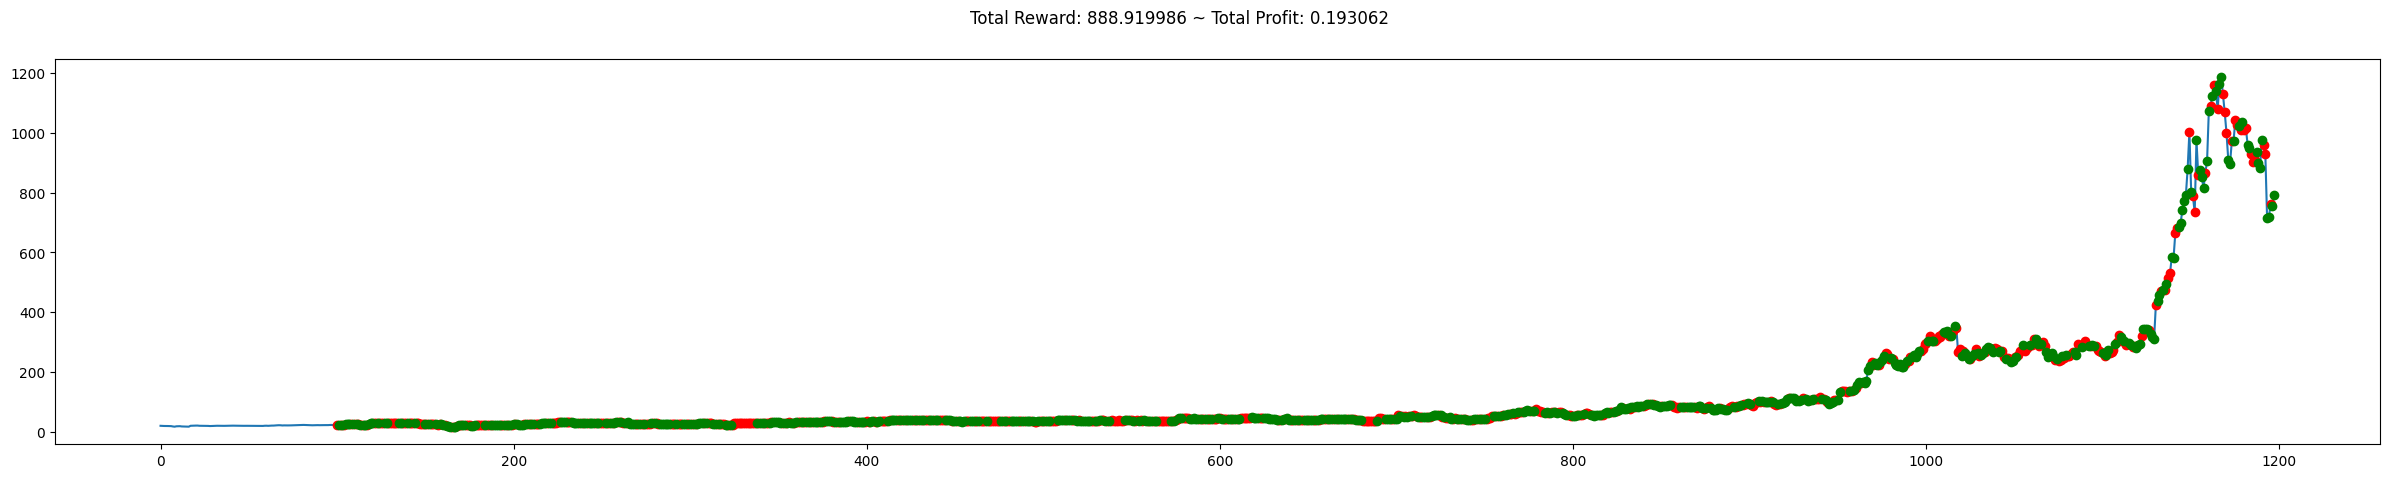

 70%|███████   | 7/10 [01:18<00:33, 11.18s/it]

Total reward accumulated during the test: 477.42019300000027


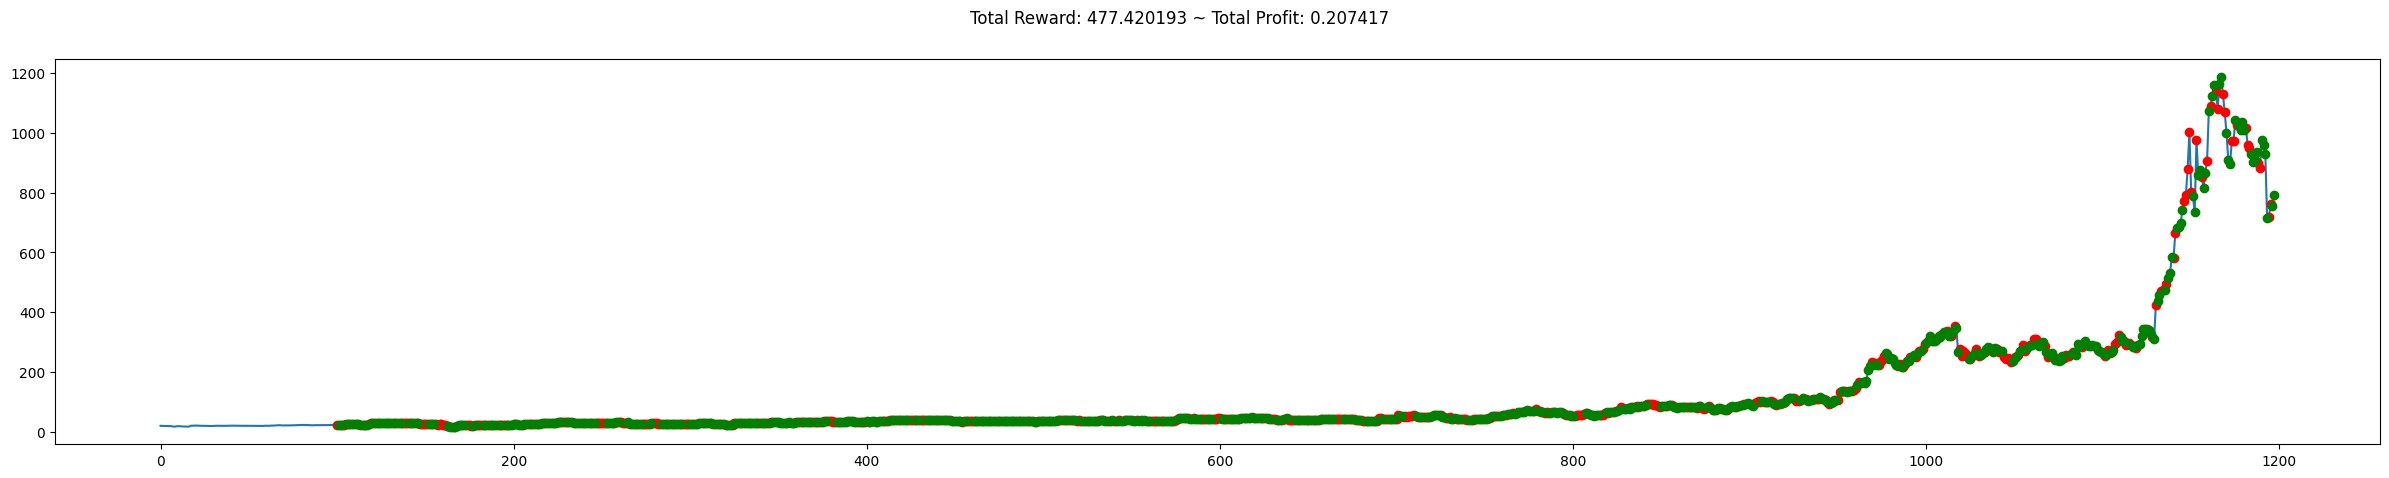

 80%|████████  | 8/10 [01:30<00:22, 11.45s/it]

Total reward accumulated during the test: 456.119954


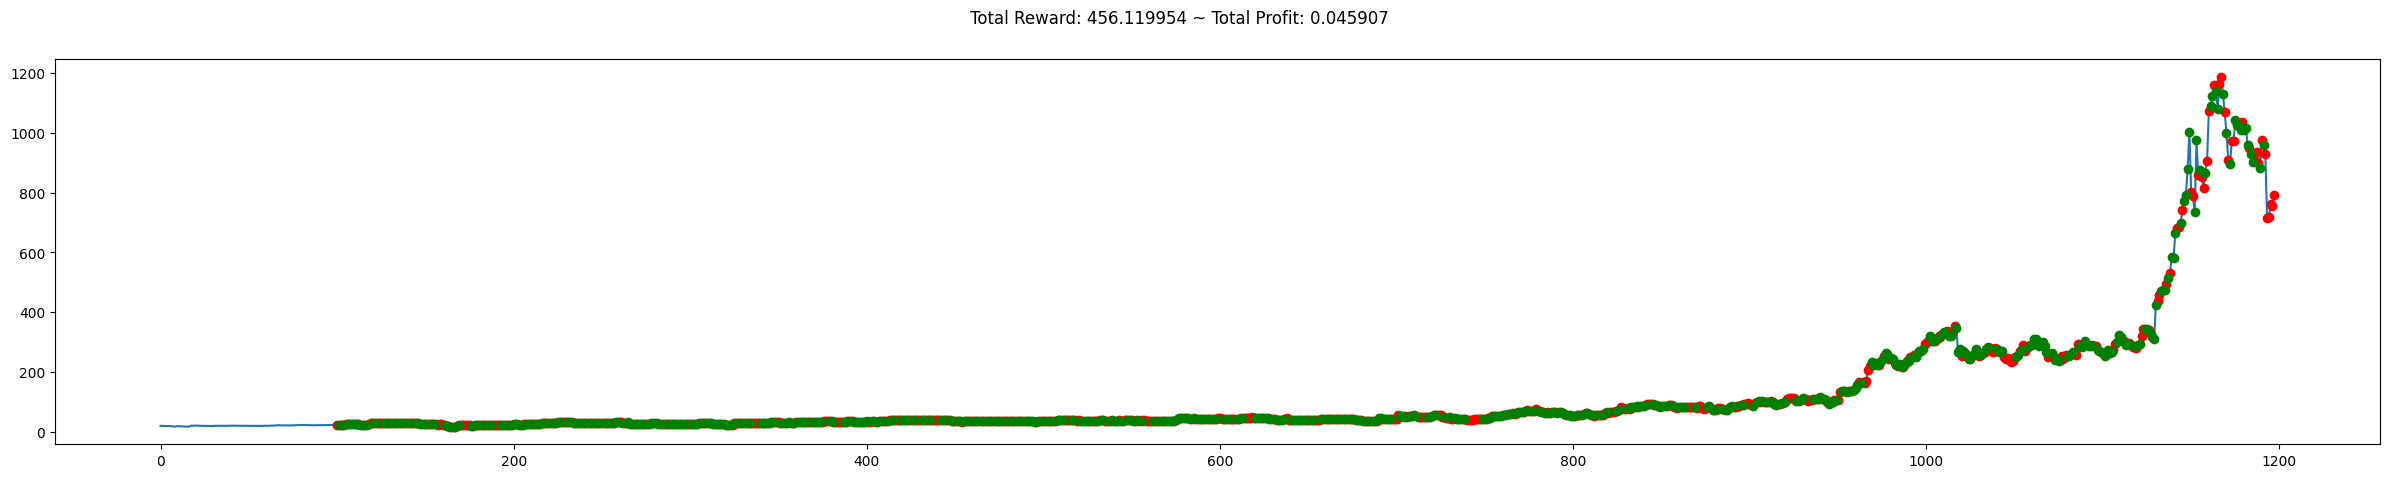

 90%|█████████ | 9/10 [01:42<00:11, 11.60s/it]

Total reward accumulated during the test: 560.8498909999995


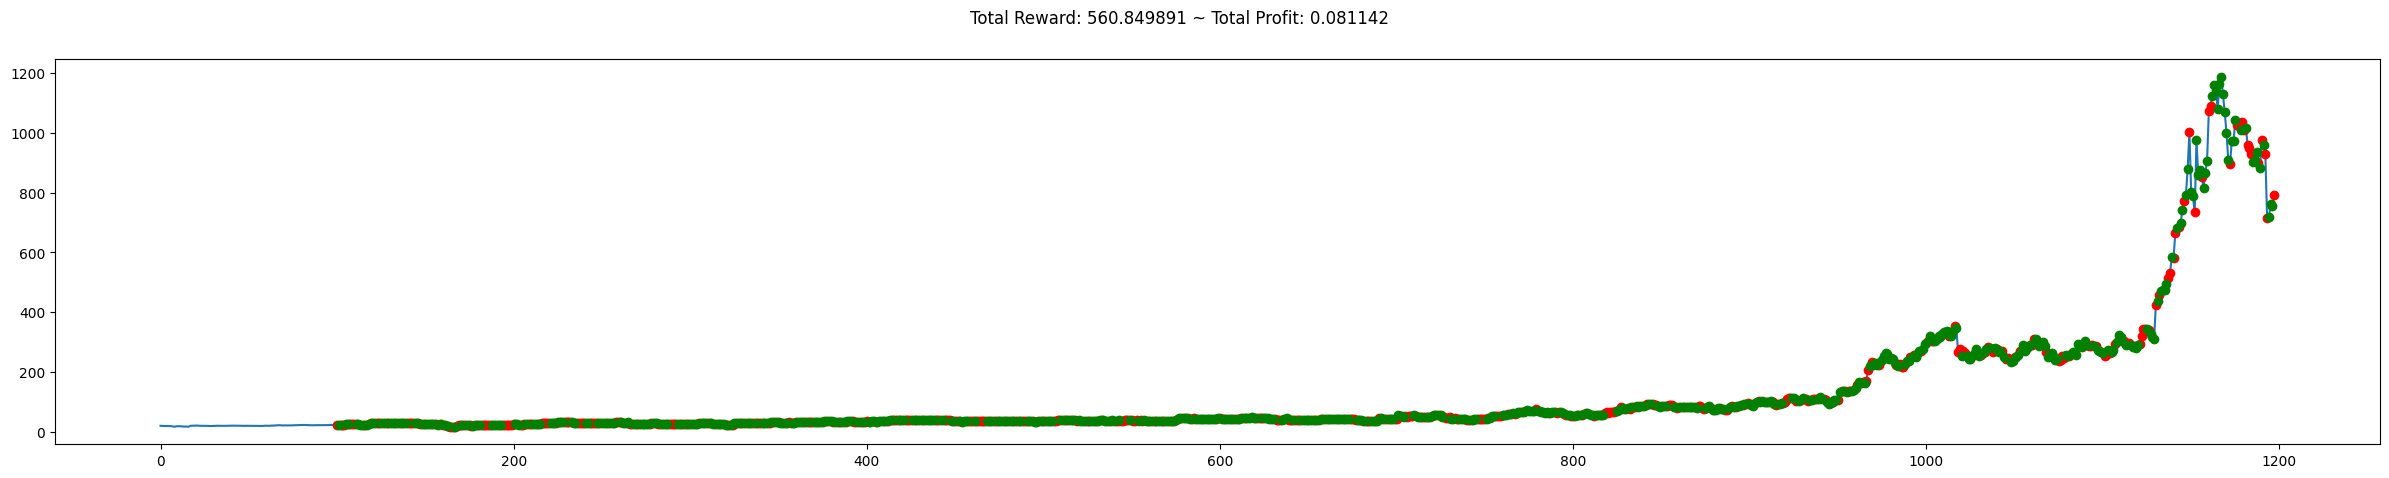

100%|██████████| 10/10 [01:53<00:00, 11.39s/it]


In [ ]:
evla_custom_model(env_test, actor)

## Training the model shorter duration (epoch = 5)

### Defining Custom Model - shorter training duration

In [ ]:
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
logits = Dense(env_train.action_space.n, activation='sigmoid')(dense)
actor = Model(inputs=inputs, outputs=logits)

## Critic Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
values = Dense(1, activation='sigmoid')(dense)
critic = Model(inputs=inputs, outputs=values)

## PPO Algorithm
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
huber_loss = tf.keras.losses.Huber()
entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

### Training Custom Model

In [ ]:
train_ppo(env_train, actor, critic, num_episodes=5)

 20%|██        | 1/5 [02:06<08:24, 126.25s/it]

Episode: 0, Total Reward: 21.089999999999975, loss: 0.487326443195343


 40%|████      | 2/5 [04:12<06:19, 126.53s/it]

Episode: 1, Total Reward: 18.33000999999997, loss: 0.43726909160614014


 60%|██████    | 3/5 [06:16<04:10, 125.32s/it]

Episode: 2, Total Reward: 18.229991000000023, loss: 0.425104022026062


 80%|████████  | 4/5 [08:21<02:05, 125.01s/it]

Episode: 3, Total Reward: 0.3900449999999971, loss: 0.5854349732398987


100%|██████████| 5/5 [10:25<00:00, 125.12s/it]

Episode: 4, Total Reward: 3.1999689999999514, loss: 0.6066490411758423
total_reward:  [21.089999999999975, 18.33000999999997, 18.229991000000023, 0.3900449999999971, 3.1999689999999514]


### Testing Custom Model

  0%|          | 0/10 [00:00<?, ?it/s]

Total reward accumulated during the test: 520.4299410000001


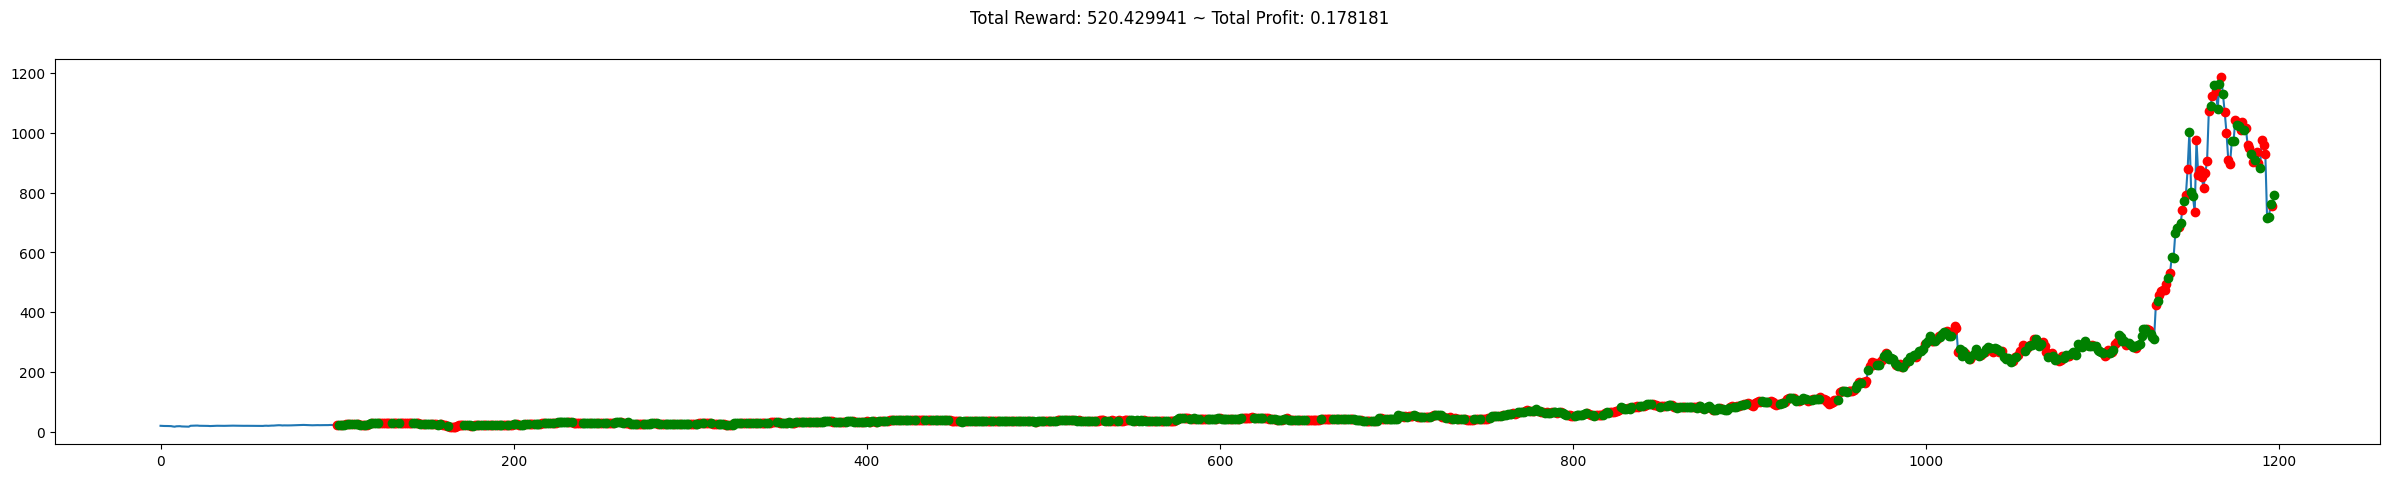

 10%|█         | 1/10 [00:22<03:26, 22.94s/it]

Total reward accumulated during the test: 147.5597770000001


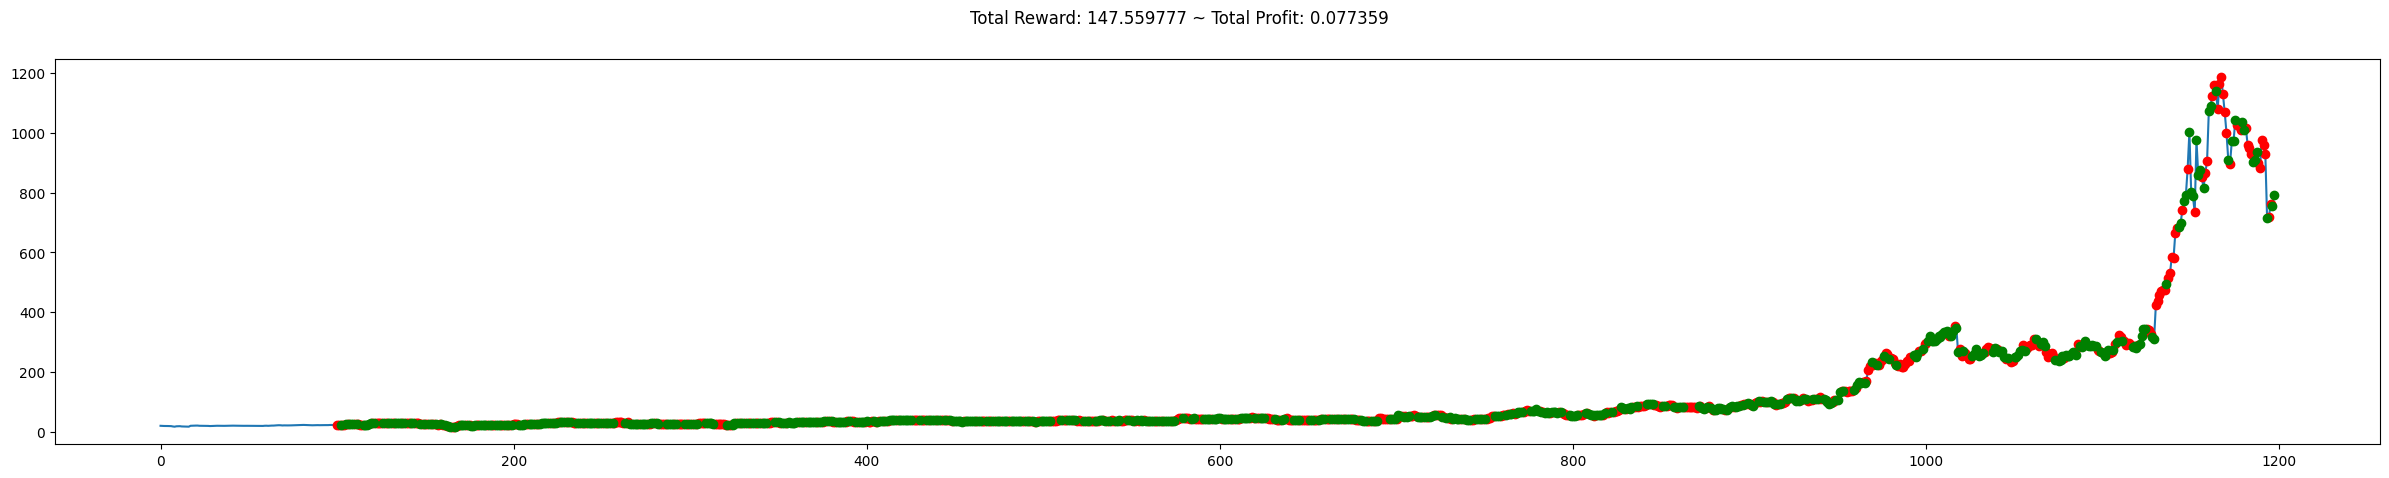

 20%|██        | 2/10 [00:44<02:55, 21.91s/it]

Total reward accumulated during the test: 344.6801079999999


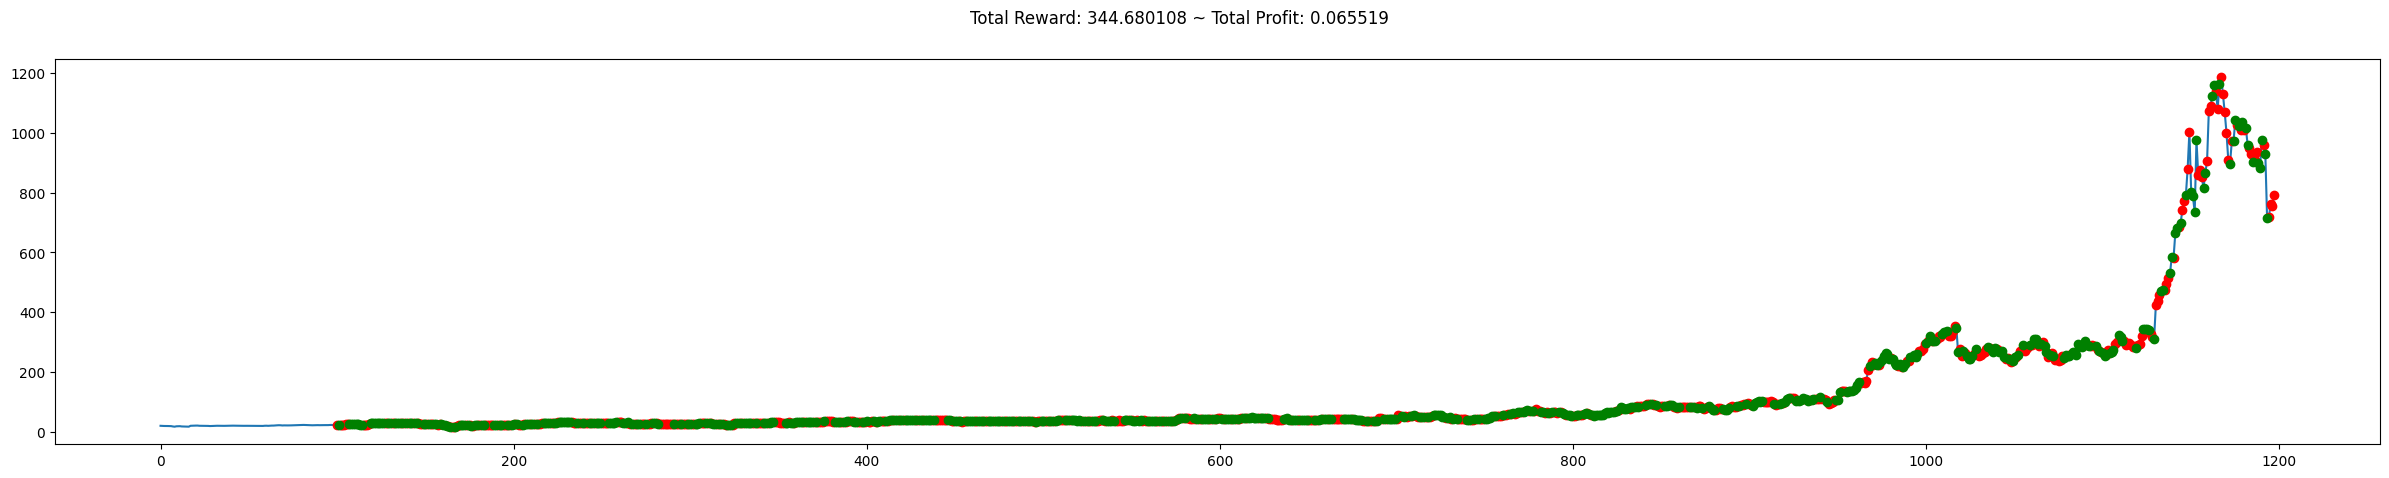

 30%|███       | 3/10 [01:05<02:33, 21.88s/it]

Total reward accumulated during the test: -178.07014199999975


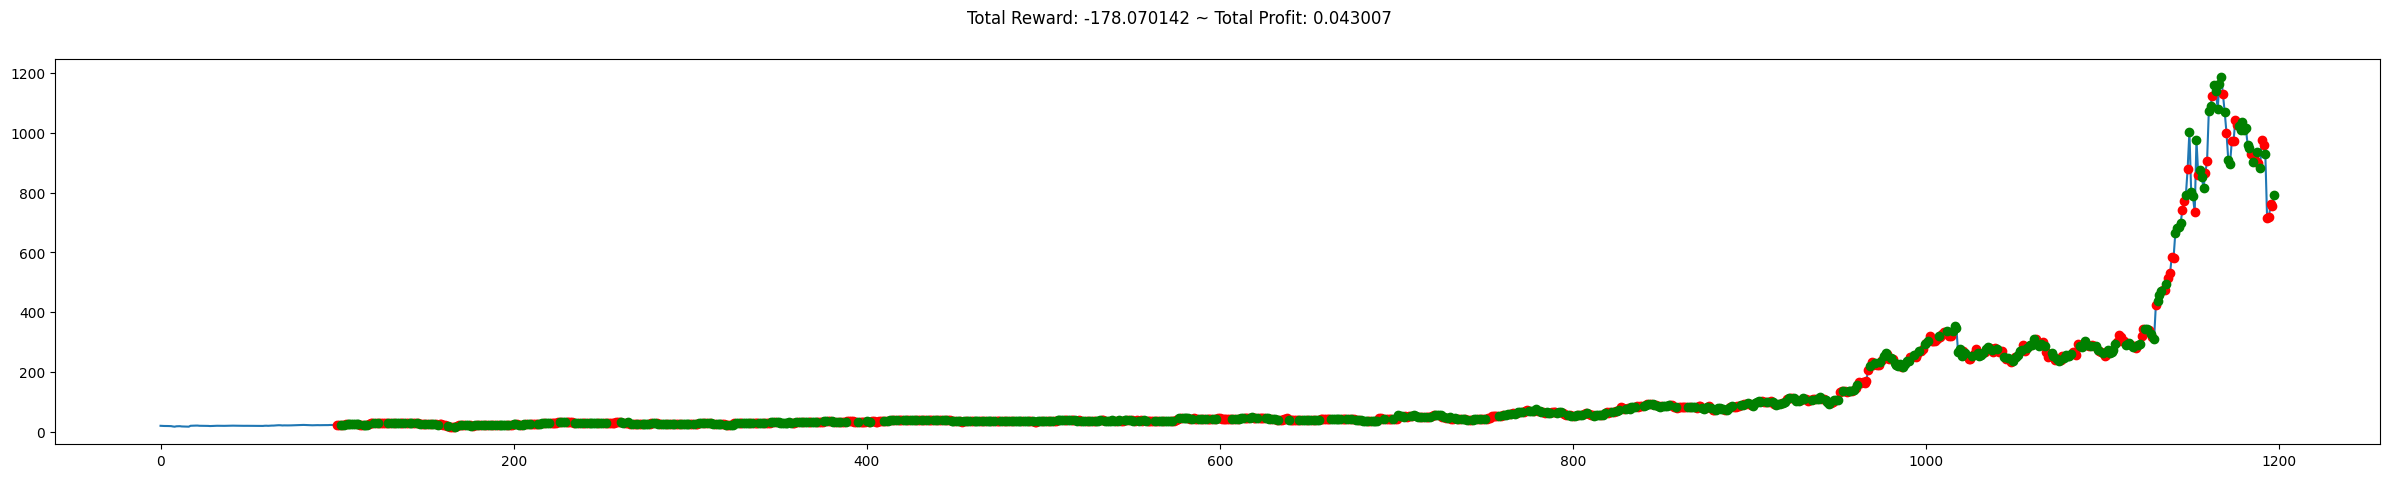

 40%|████      | 4/10 [01:27<02:11, 21.89s/it]

Total reward accumulated during the test: 531.379888


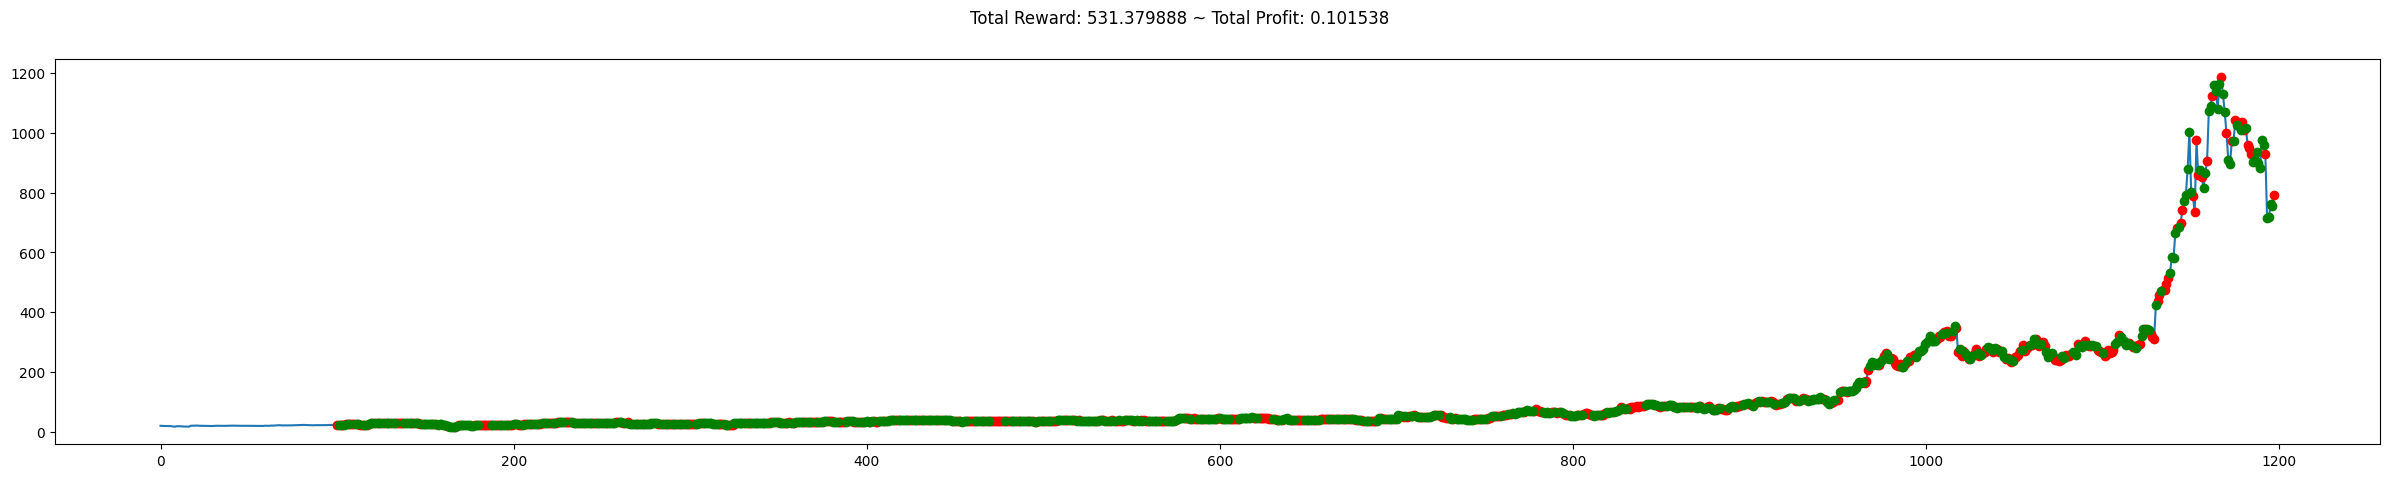

 50%|█████     | 5/10 [01:48<01:47, 21.55s/it]

Total reward accumulated during the test: -378.36018199999995


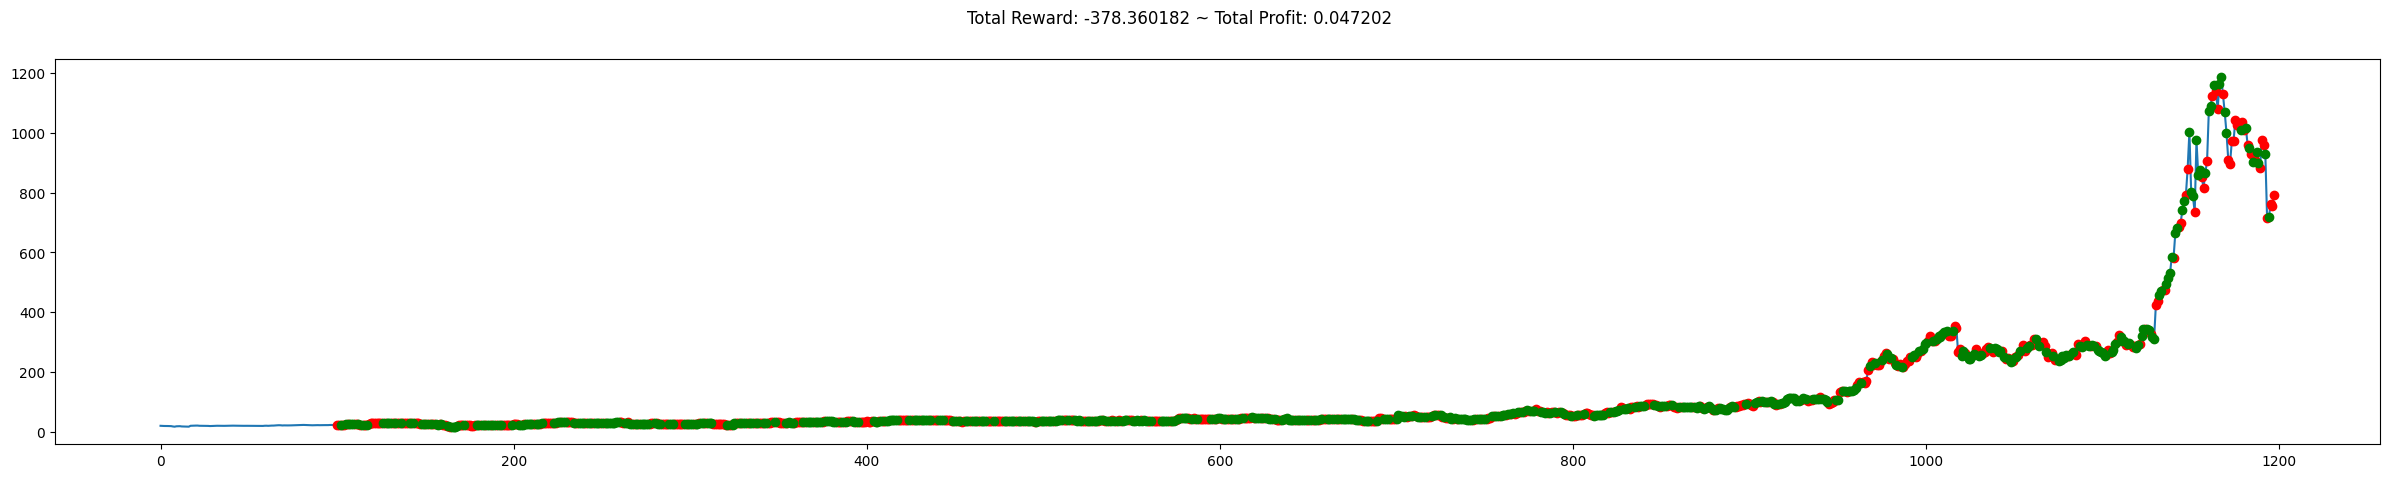

 60%|██████    | 6/10 [02:10<01:26, 21.67s/it]

Total reward accumulated during the test: 488.4199040000001


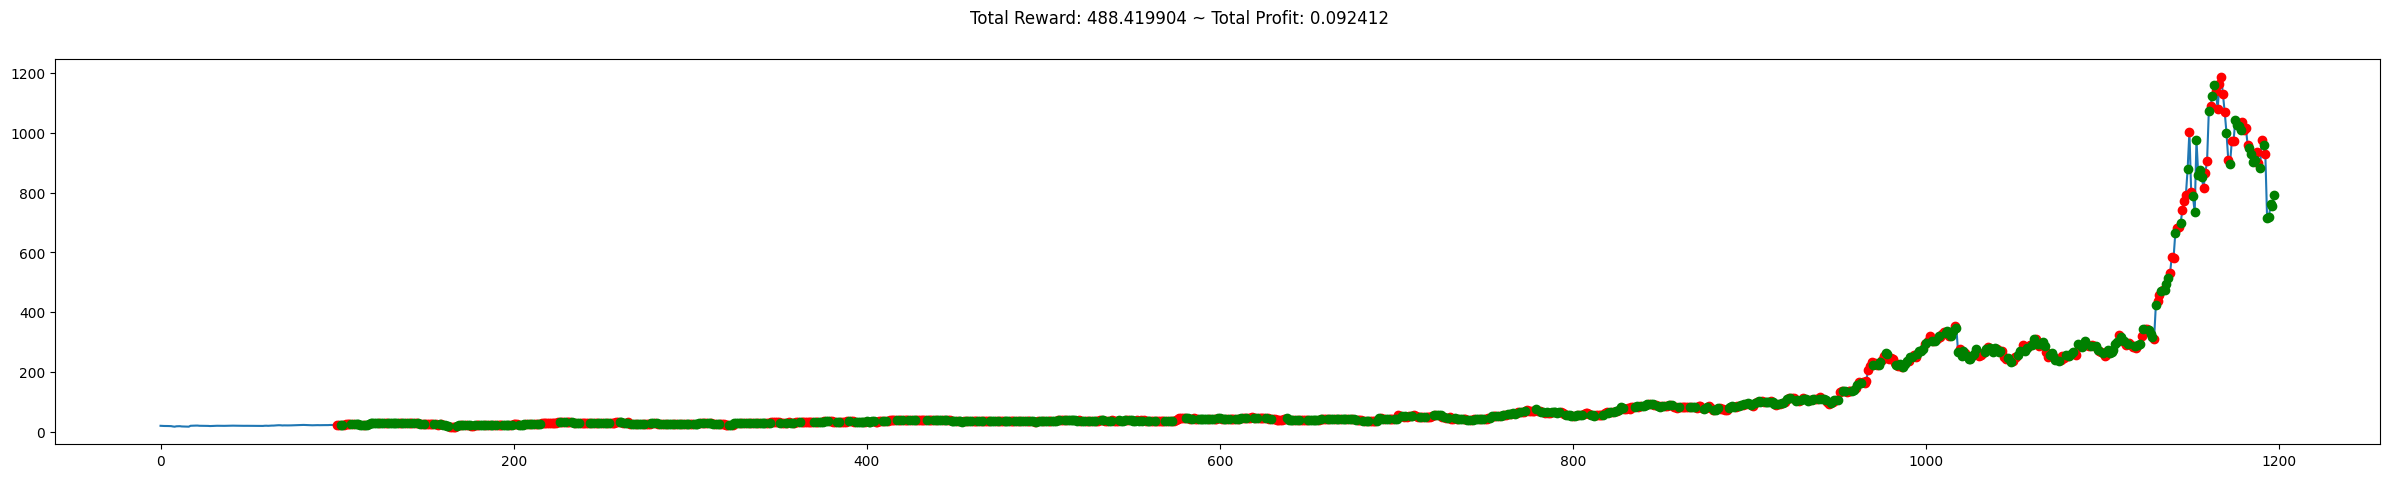

 70%|███████   | 7/10 [02:32<01:05, 21.71s/it]

Total reward accumulated during the test: 680.1698940000001


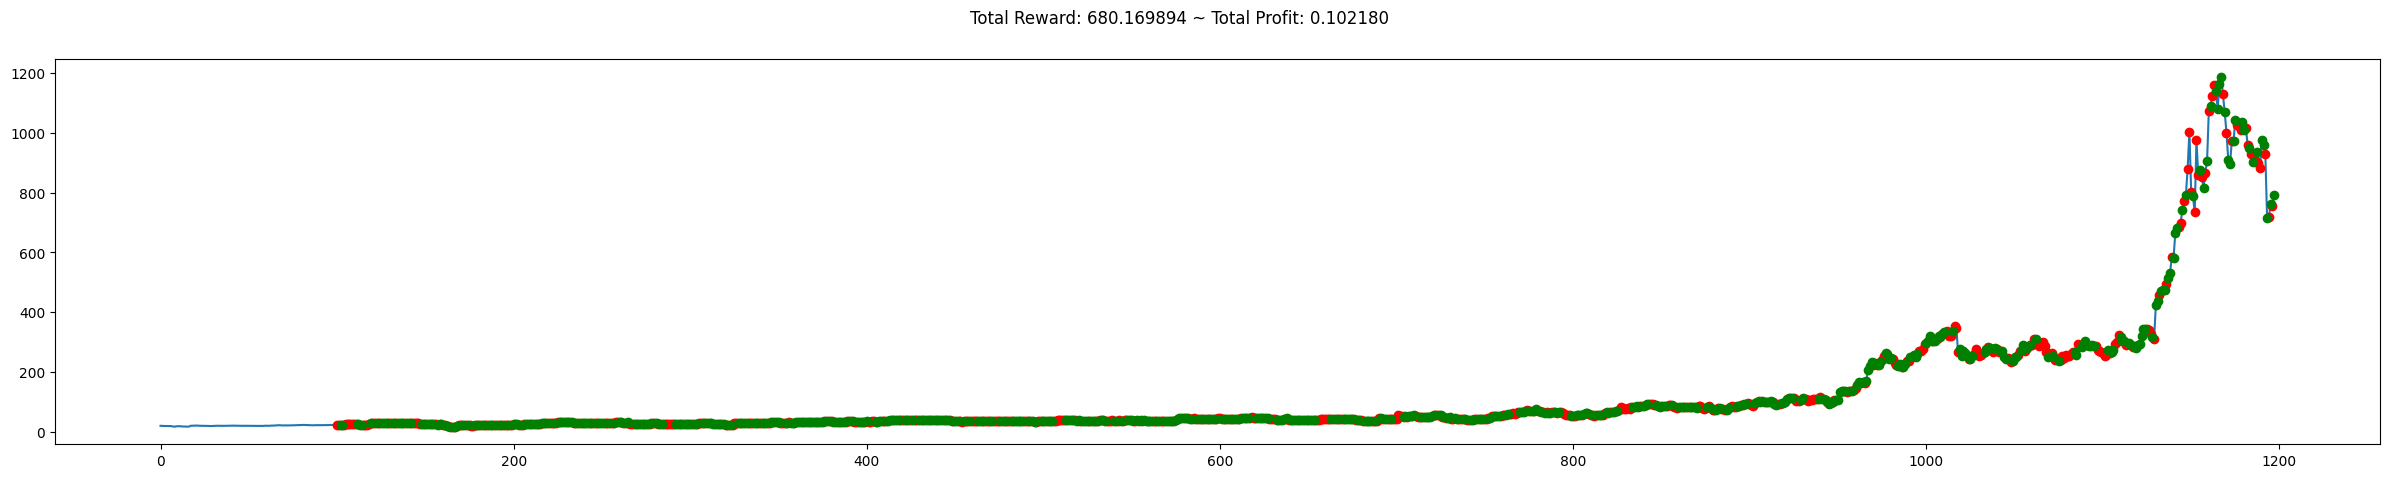

 80%|████████  | 8/10 [02:53<00:43, 21.51s/it]

Total reward accumulated during the test: 221.1299459999999


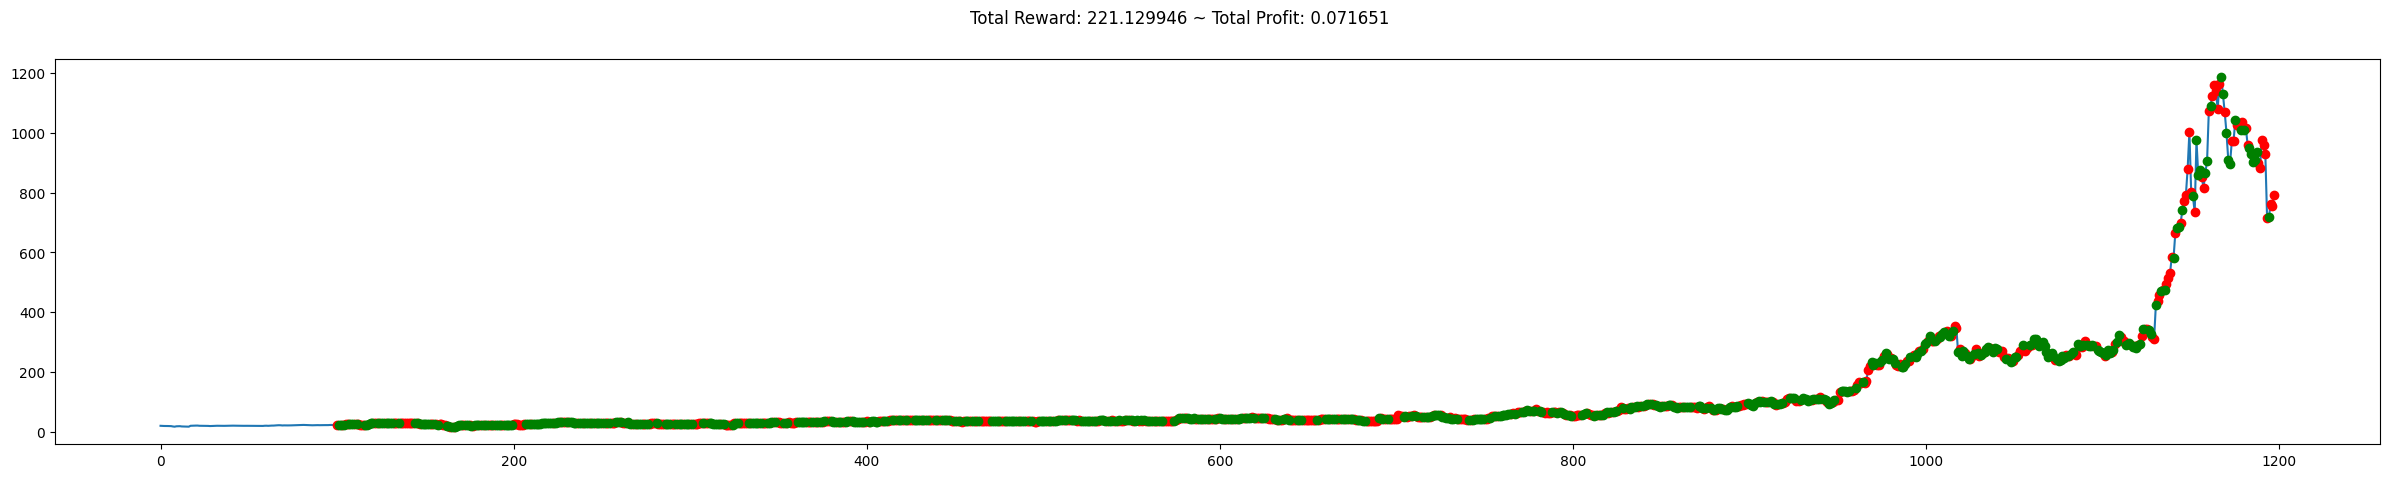

 90%|█████████ | 9/10 [03:15<00:21, 21.60s/it]

Total reward accumulated during the test: -295.65001500000017


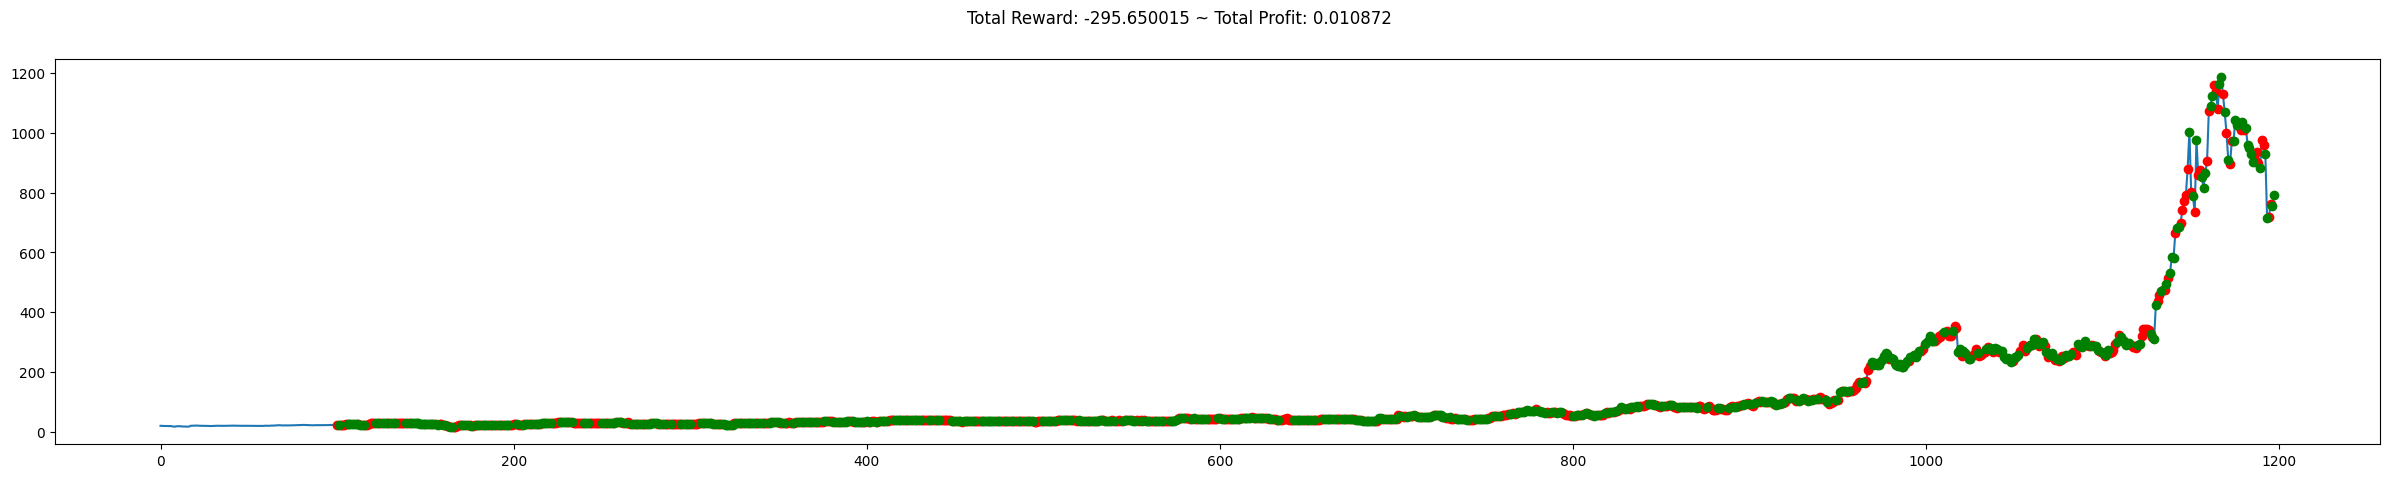

100%|██████████| 10/10 [03:37<00:00, 21.74s/it]


In [ ]:
evla_custom_model(env_test, actor)

## Training the model longer duration (epoch = 50)

### Defining Custom Model - longer training duration

In [ ]:
## Actor Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
logits = Dense(env_train.action_space.n, activation='sigmoid')(dense)
actor = Model(inputs=inputs, outputs=logits)

## Critic Network
inputs = Input(shape=(None, signal_features_train.shape[-1]))
lstm = LSTM(128, return_sequences=True)(inputs)
lstm = LSTM(256, return_sequences=True)(lstm)
dense = Dense(256, activation='relu')(lstm)
dense = Dense(128, activation='relu')(dense)
dense = Dense(128, activation='relu')(dense)
values = Dense(1, activation='sigmoid')(dense)
critic = Model(inputs=inputs, outputs=values)

## PPO Algorithm
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
huber_loss = tf.keras.losses.Huber()
entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

### Training Custom Model

In [ ]:
train_ppo(env_train, actor, critic, num_episodes=50)

  2%|▏         | 1/50 [02:13<1:49:00, 133.49s/it]

Episode: 0, Total Reward: 6.230018000000046, loss: 0.5090226531028748


  4%|▍         | 2/50 [04:29<1:47:47, 134.74s/it]

Episode: 1, Total Reward: 14.939992, loss: 0.45209211111068726


  6%|▌         | 3/50 [06:36<1:42:52, 131.32s/it]

Episode: 2, Total Reward: 15.149969000000027, loss: 0.4702702462673187


  8%|▊         | 4/50 [08:43<1:39:24, 129.66s/it]

Episode: 3, Total Reward: 32.690008999999975, loss: 0.3628659248352051


 10%|█         | 5/50 [10:50<1:36:38, 128.86s/it]

Episode: 4, Total Reward: -15.629998999999959, loss: 0.6350005269050598


 12%|█▏        | 6/50 [12:57<1:34:01, 128.22s/it]

Episode: 5, Total Reward: -6.959973999999976, loss: 0.6215029954910278


 14%|█▍        | 7/50 [15:06<1:31:54, 128.25s/it]

Episode: 6, Total Reward: 12.739983000000047, loss: 0.5749446153640747


 16%|█▌        | 8/50 [17:14<1:29:44, 128.20s/it]

Episode: 7, Total Reward: -4.200023999999985, loss: 0.5414052605628967


 18%|█▊        | 9/50 [19:23<1:27:51, 128.57s/it]

Episode: 8, Total Reward: 15.380013000000044, loss: 0.44978344440460205


 20%|██        | 10/50 [21:31<1:25:30, 128.27s/it]

Episode: 9, Total Reward: -4.020021000000018, loss: 0.5672178268432617


 22%|██▏       | 11/50 [23:40<1:23:31, 128.51s/it]

Episode: 10, Total Reward: -13.939974999999933, loss: 0.6636132001876831


 24%|██▍       | 12/50 [25:47<1:21:11, 128.19s/it]

Episode: 11, Total Reward: -4.499999996454562e-05, loss: 0.5625640153884888


 26%|██▌       | 13/50 [27:55<1:18:53, 127.92s/it]

Episode: 12, Total Reward: -9.789975000000082, loss: 0.6537502408027649


 28%|██▊       | 14/50 [30:02<1:16:44, 127.91s/it]

Episode: 13, Total Reward: 4.8999779999999955, loss: 0.5363800525665283


 30%|███       | 15/50 [32:08<1:14:13, 127.24s/it]

Episode: 14, Total Reward: 14.679990000000025, loss: 0.44405072927474976


 32%|███▏      | 16/50 [34:16<1:12:10, 127.35s/it]

Episode: 15, Total Reward: -1.540007999999995, loss: 0.6472961902618408


 34%|███▍      | 17/50 [36:22<1:09:54, 127.12s/it]

Episode: 16, Total Reward: 10.36003500000007, loss: 0.5327928066253662


 36%|███▌      | 18/50 [38:28<1:07:34, 126.69s/it]

Episode: 17, Total Reward: -29.97000399999998, loss: 0.7511396408081055


 38%|███▊      | 19/50 [40:33<1:05:06, 126.02s/it]

Episode: 18, Total Reward: -11.070019999999973, loss: 0.6254604458808899


 40%|████      | 20/50 [42:38<1:02:57, 125.90s/it]

Episode: 19, Total Reward: -10.879998000000047, loss: 0.662131667137146


 42%|████▏     | 21/50 [44:42<1:00:36, 125.39s/it]

Episode: 20, Total Reward: 19.609967000000005, loss: 0.38294124603271484


 44%|████▍     | 22/50 [46:48<58:31, 125.42s/it]  

Episode: 21, Total Reward: 11.999998999999965, loss: 0.5451666116714478


 46%|████▌     | 23/50 [48:51<56:06, 124.70s/it]

Episode: 22, Total Reward: 3.019960000000003, loss: 0.5185685157775879


 48%|████▊     | 24/50 [50:56<54:02, 124.71s/it]

Episode: 23, Total Reward: 6.689983000000026, loss: 0.5338910222053528


 50%|█████     | 25/50 [52:59<51:45, 124.23s/it]

Episode: 24, Total Reward: -4.18999800000001, loss: 0.45149388909339905


 52%|█████▏    | 26/50 [55:06<50:07, 125.30s/it]

Episode: 25, Total Reward: -26.690024999999952, loss: 0.756083607673645


 54%|█████▍    | 27/50 [57:11<47:55, 125.04s/it]

Episode: 26, Total Reward: 17.449996000000006, loss: 0.44327378273010254


 56%|█████▌    | 28/50 [59:14<45:40, 124.58s/it]

Episode: 27, Total Reward: 2.8700059999999894, loss: 0.5065507888793945


 58%|█████▊    | 29/50 [1:01:18<43:32, 124.41s/it]

Episode: 28, Total Reward: -13.16002, loss: 0.6486296653747559


 60%|██████    | 30/50 [1:03:22<41:22, 124.14s/it]

Episode: 29, Total Reward: -3.2500149999999692, loss: 0.576316237449646


 62%|██████▏   | 31/50 [1:05:26<39:16, 124.00s/it]

Episode: 30, Total Reward: -1.9099930000000054, loss: 0.44561582803726196


 64%|██████▍   | 32/50 [1:07:28<37:04, 123.61s/it]

Episode: 31, Total Reward: -0.539968000000016, loss: 0.4855648875236511


 66%|██████▌   | 33/50 [1:09:31<34:54, 123.20s/it]

Episode: 32, Total Reward: 1.6500159999999742, loss: 0.377910852432251


 68%|██████▊   | 34/50 [1:11:36<33:03, 123.94s/it]

Episode: 33, Total Reward: -22.64997299999999, loss: 0.6373211741447449


 70%|███████   | 35/50 [1:13:39<30:54, 123.60s/it]

Episode: 34, Total Reward: 0.2400250000000259, loss: 0.5510738492012024


 72%|███████▏  | 36/50 [1:15:44<28:57, 124.09s/it]

Episode: 35, Total Reward: 11.790004000000039, loss: 0.3436455726623535


 74%|███████▍  | 37/50 [1:17:52<27:05, 125.05s/it]

Episode: 36, Total Reward: 1.6300079999999664, loss: 0.41069018840789795


 76%|███████▌  | 38/50 [1:19:58<25:04, 125.37s/it]

Episode: 37, Total Reward: 7.530005999999988, loss: 0.3446123003959656


 78%|███████▊  | 39/50 [1:22:01<22:53, 124.83s/it]

Episode: 38, Total Reward: -23.659982000000007, loss: 0.6083873510360718


 80%|████████  | 40/50 [1:24:07<20:50, 125.03s/it]

Episode: 39, Total Reward: -10.17998000000006, loss: 0.5638905763626099


 82%|████████▏ | 41/50 [1:26:10<18:41, 124.62s/it]

Episode: 40, Total Reward: -6.070006000000033, loss: 0.4735691547393799


 84%|████████▍ | 42/50 [1:28:15<16:36, 124.59s/it]

Episode: 41, Total Reward: 7.200004000000012, loss: 0.382271945476532


 86%|████████▌ | 43/50 [1:30:19<14:31, 124.46s/it]

Episode: 42, Total Reward: -11.109988000000014, loss: 0.601643979549408


 88%|████████▊ | 44/50 [1:32:24<12:26, 124.45s/it]

Episode: 43, Total Reward: 18.680031999999947, loss: 0.325086772441864


 90%|█████████ | 45/50 [1:34:29<10:24, 124.80s/it]

Episode: 44, Total Reward: 8.12001400000001, loss: 0.42388221621513367


 92%|█████████▏| 46/50 [1:36:33<08:18, 124.51s/it]

Episode: 45, Total Reward: -6.820058999999931, loss: 0.5665828585624695


 94%|█████████▍| 47/50 [1:38:37<06:13, 124.43s/it]

Episode: 46, Total Reward: -5.720000999999975, loss: 0.4817872643470764


 96%|█████████▌| 48/50 [1:40:42<04:08, 124.50s/it]

Episode: 47, Total Reward: 16.98998599999993, loss: 0.3356190323829651


 98%|█████████▊| 49/50 [1:42:48<02:04, 124.94s/it]

Episode: 48, Total Reward: -7.950012999999979, loss: 0.4682340621948242


100%|██████████| 50/50 [1:44:53<00:00, 125.87s/it]

Episode: 49, Total Reward: 29.109955000000014, loss: 0.17779134213924408
total_reward:  [6.230018000000046, 14.939992, 15.149969000000027, 32.690008999999975, -15.629998999999959, -6.959973999999976, 12.739983000000047, -4.200023999999985, 15.380013000000044, -4.020021000000018, -13.939974999999933, -4.499999996454562e-05, -9.789975000000082, 4.8999779999999955, 14.679990000000025, -1.540007999999995, 10.36003500000007, -29.97000399999998, -11.070019999999973, -10.879998000000047, 19.609967000000005, 11.999998999999965, 3.019960000000003, 6.689983000000026, -4.18999800000001, -26.690024999999952, 17.449996000000006, 2.8700059999999894, -13.16002, -3.2500149999999692, -1.9099930000000054, -0.539968000000016, 1.6500159999999742, -22.64997299999999, 0.2400250000000259, 11.790004000000039, 1.6300079999999664, 7.530005999999988, -23.659982000000007, -10.17998000000006, -6.070006000000033, 7.200004000000012, -11.109988000000014, 18.680031999999947, 8.12001400000001, -6.820058999999931, -5.72

### Testing Custom Model

  0%|          | 0/10 [00:00<?, ?it/s]

Total reward accumulated during the test: 207.6095960000004


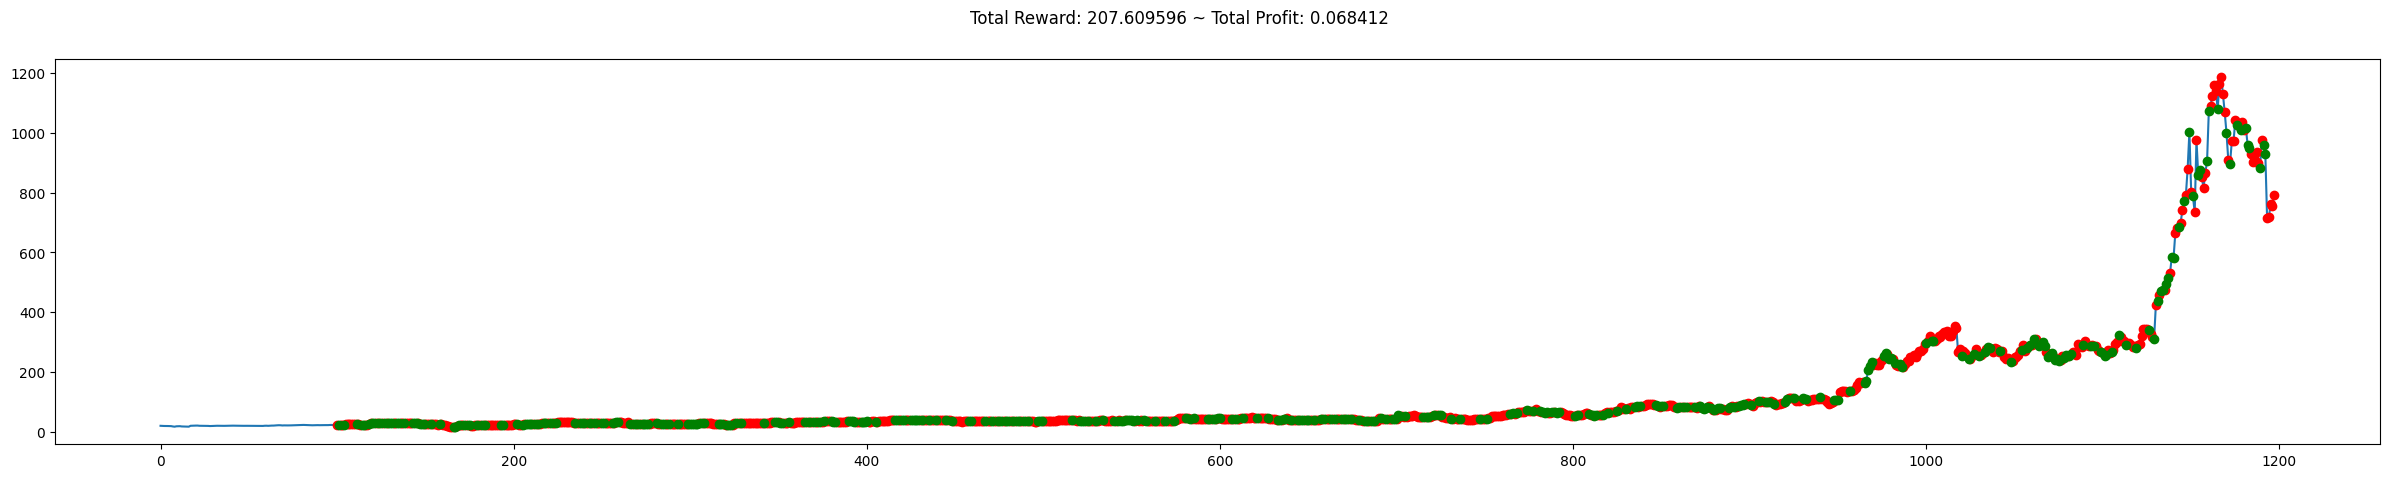

 10%|█         | 1/10 [00:21<03:10, 21.18s/it]

Total reward accumulated during the test: -43.180216999999914


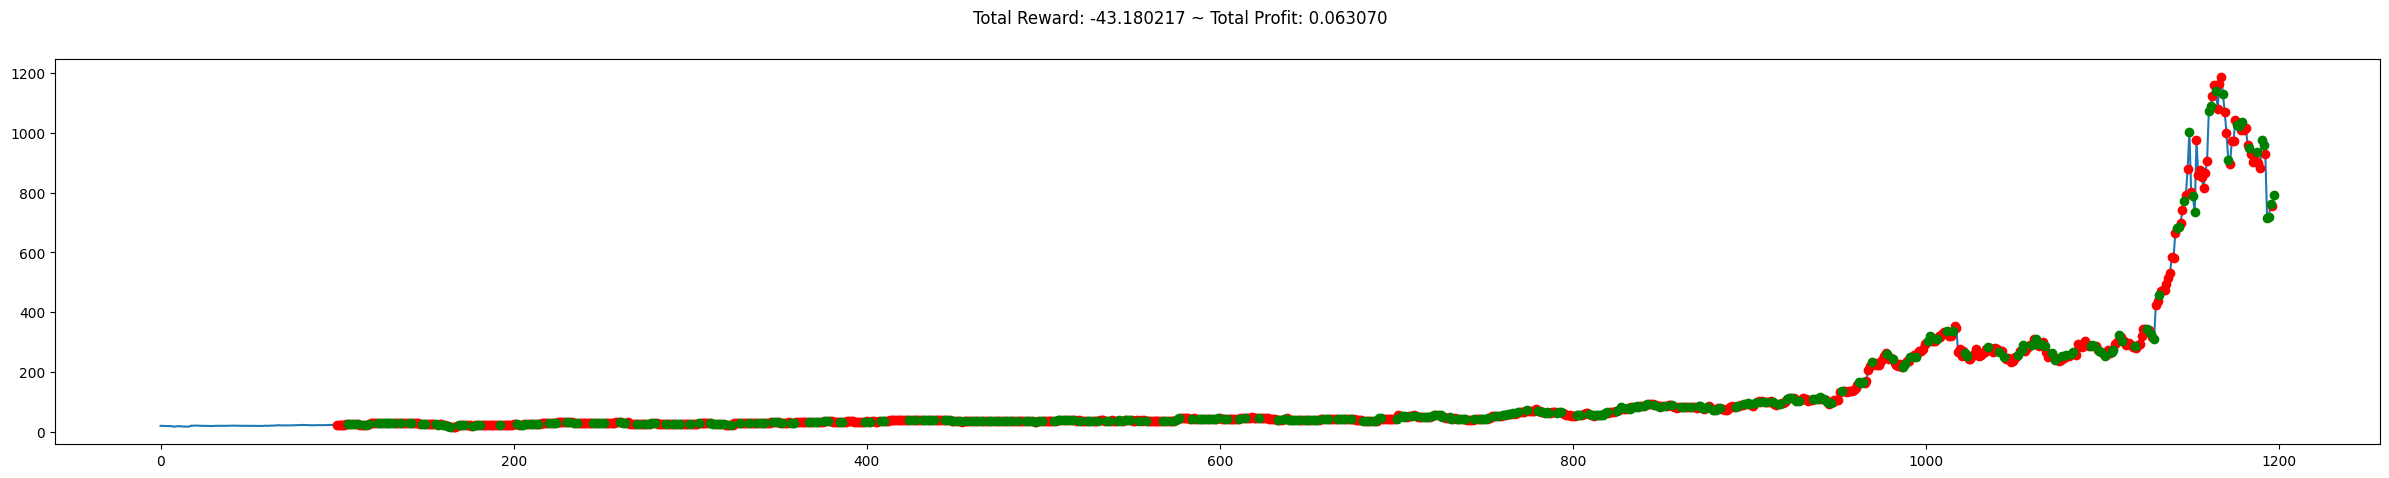

 20%|██        | 2/10 [00:42<02:50, 21.35s/it]

Total reward accumulated during the test: 217.24993599999982


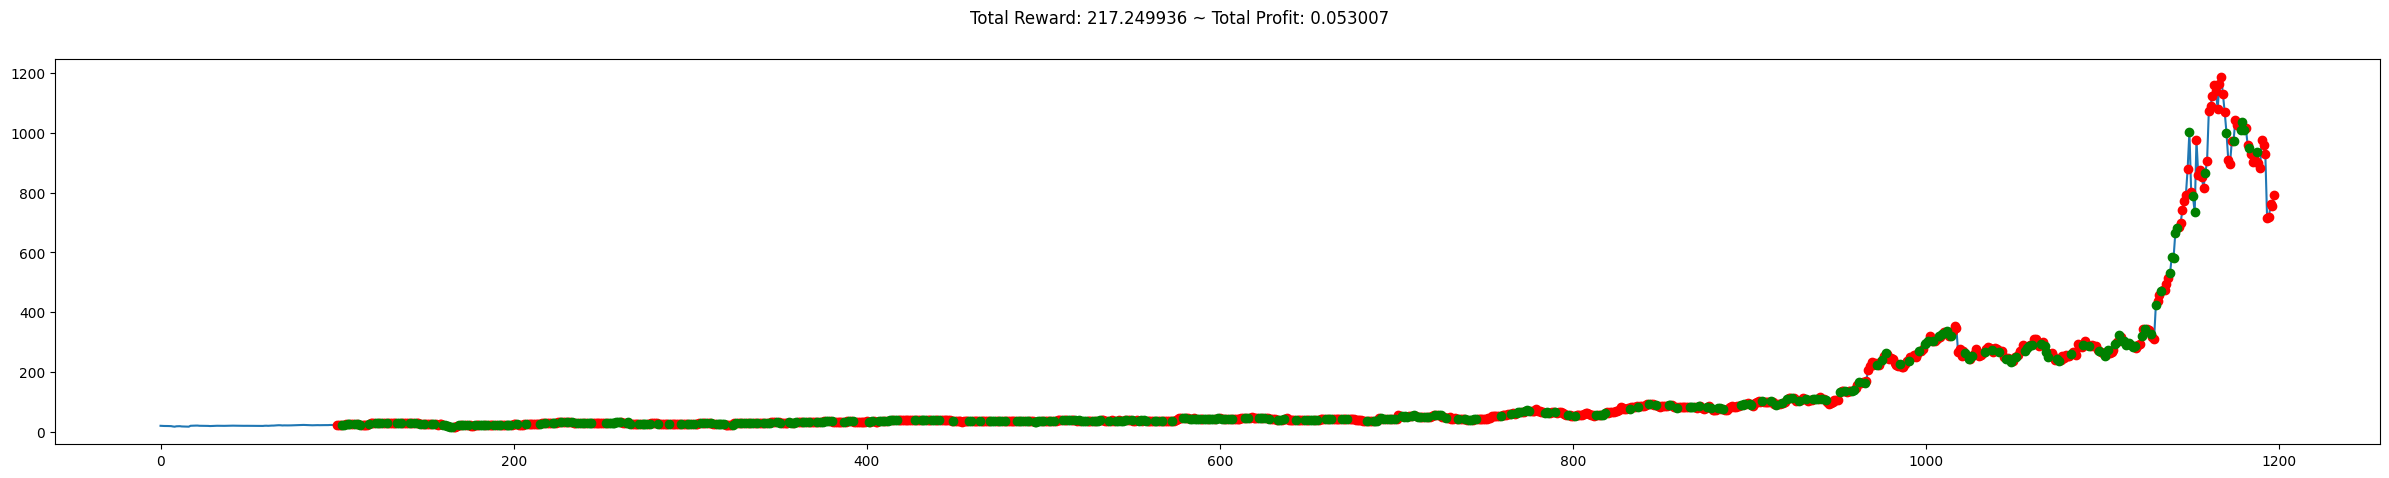

 30%|███       | 3/10 [01:05<02:34, 22.03s/it]

Total reward accumulated during the test: 429.17024400000014


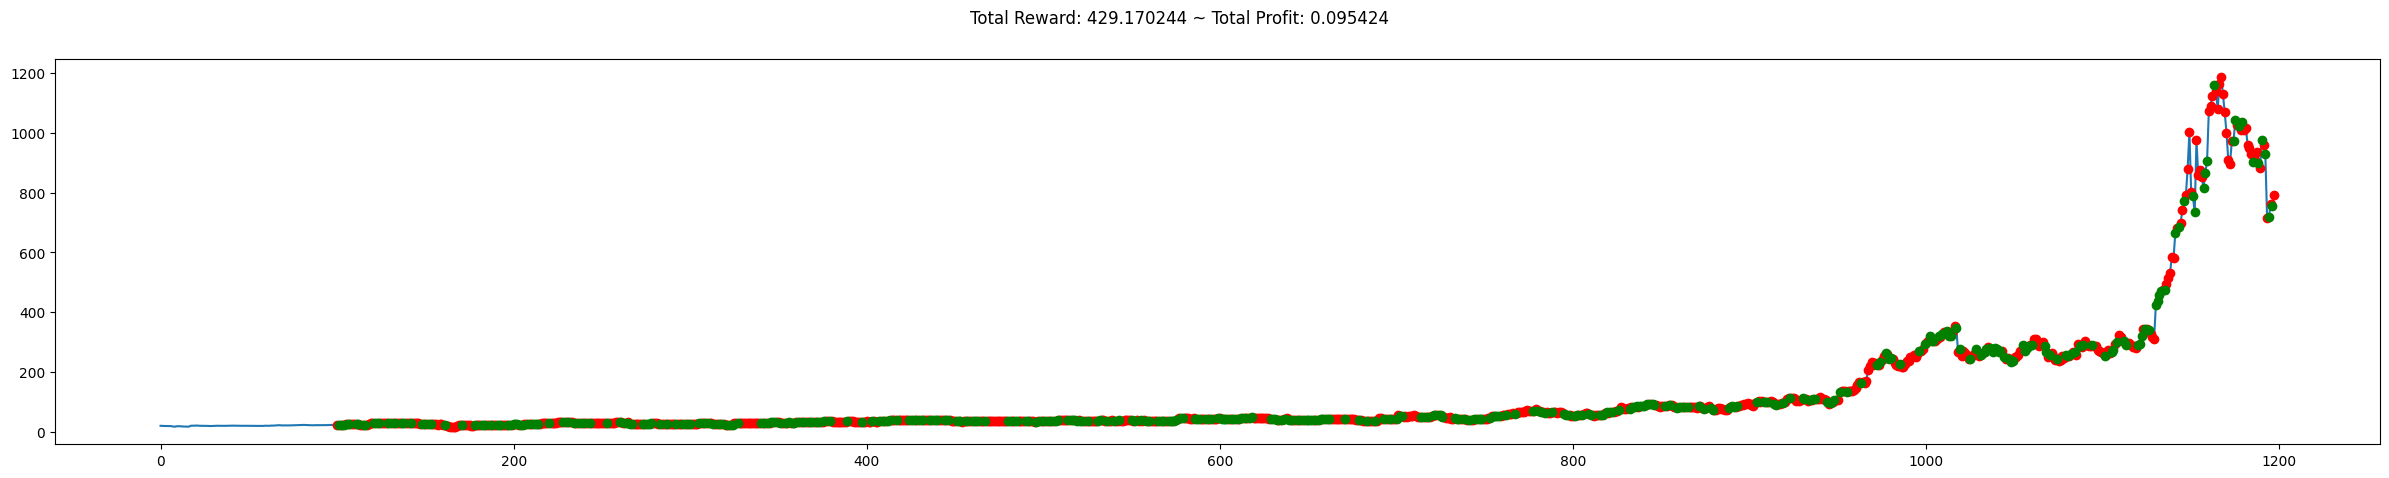

 40%|████      | 4/10 [01:26<02:10, 21.74s/it]

Total reward accumulated during the test: 588.1399239999998


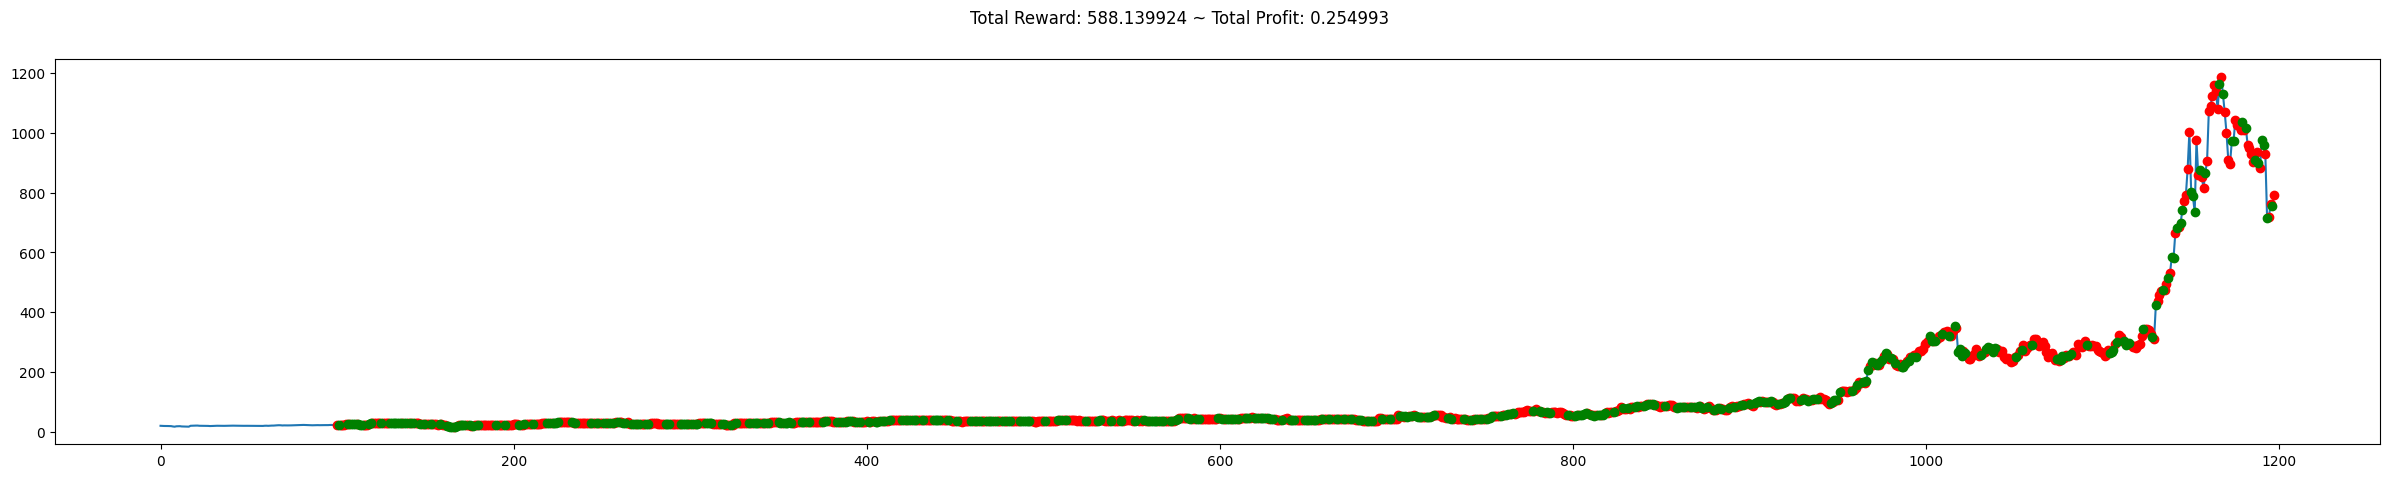

 50%|█████     | 5/10 [01:48<01:49, 21.88s/it]

Total reward accumulated during the test: 181.73983099999998


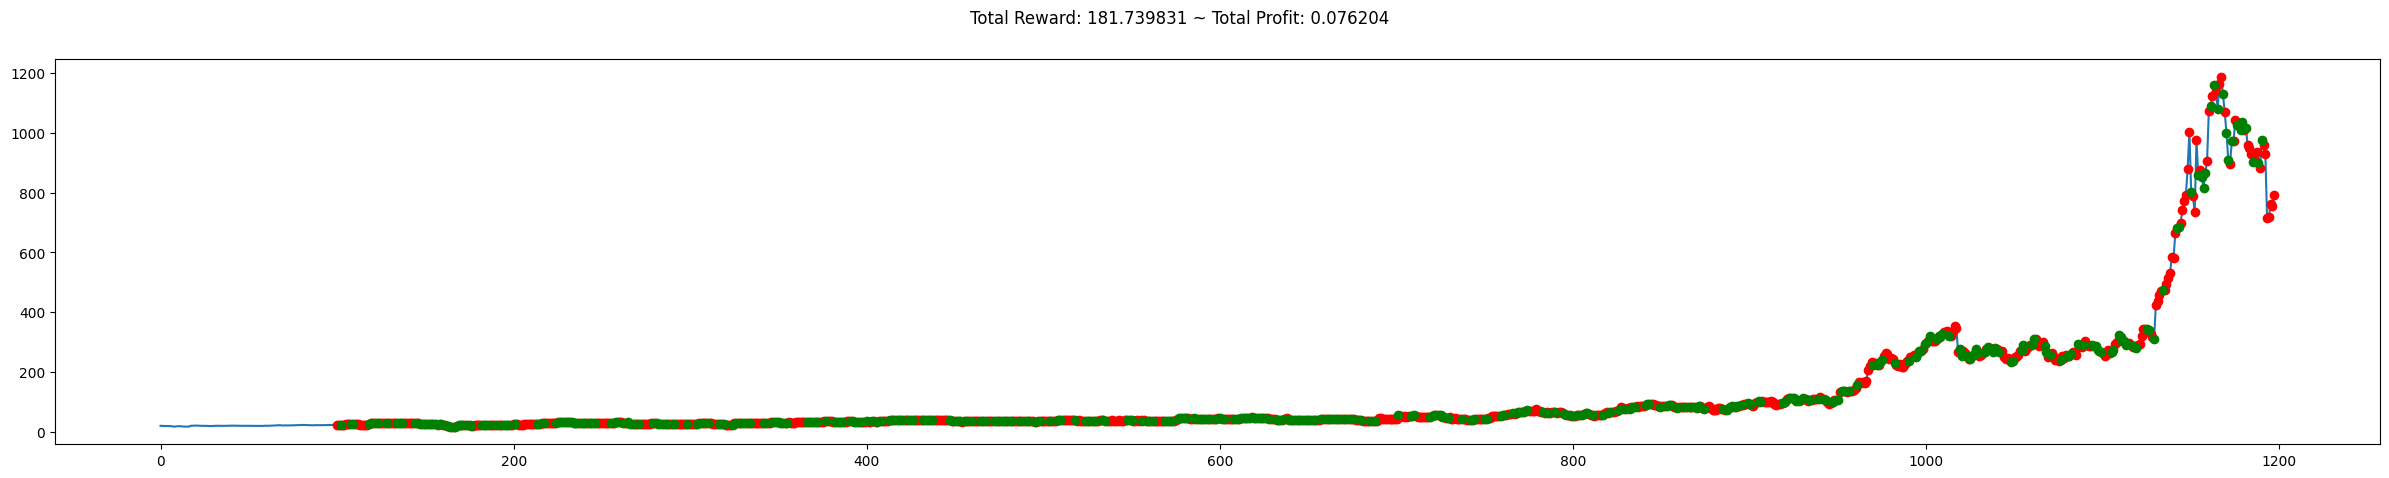

 60%|██████    | 6/10 [02:10<01:27, 21.79s/it]

Total reward accumulated during the test: 375.7398859999999


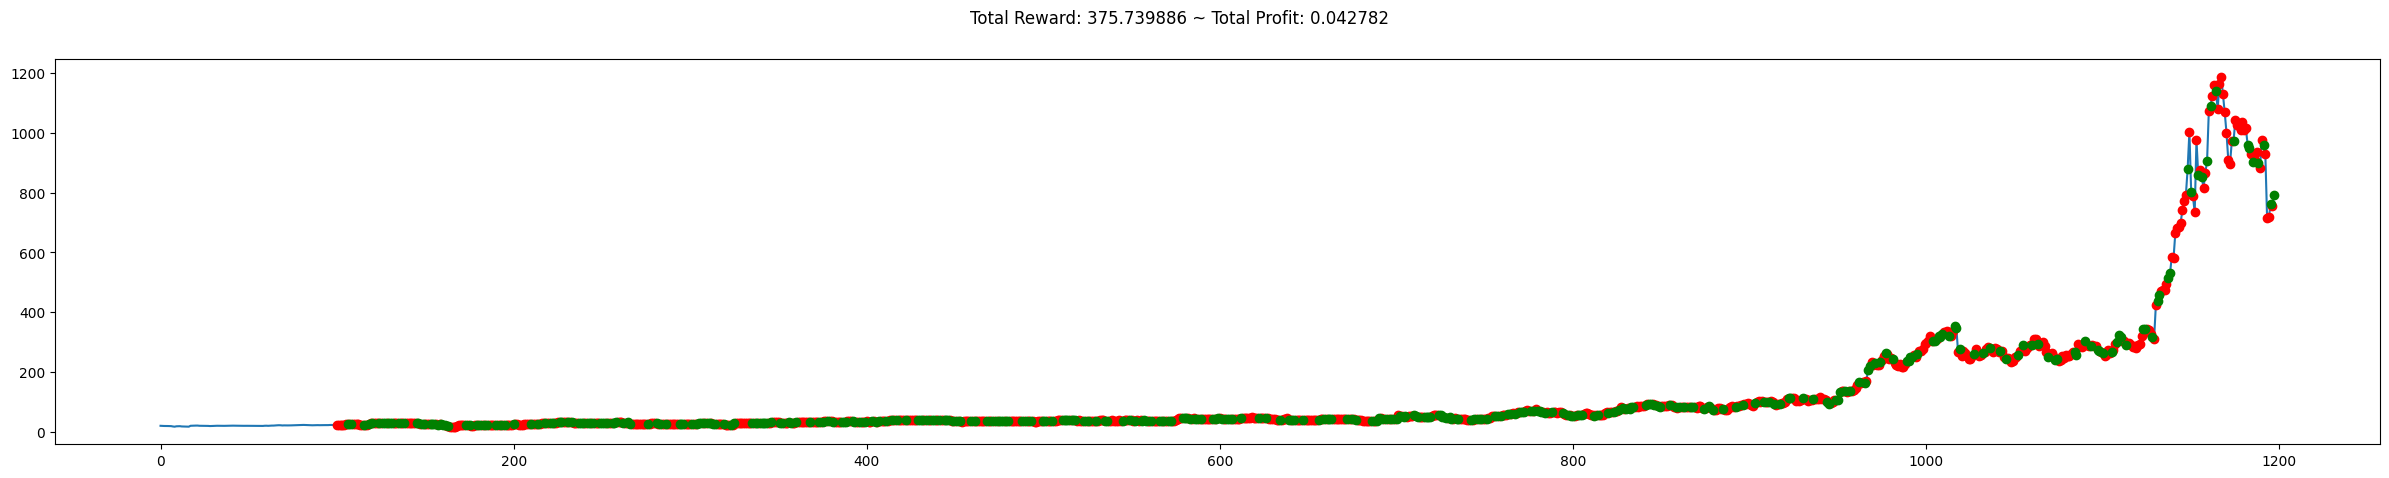

 70%|███████   | 7/10 [02:31<01:04, 21.47s/it]

Total reward accumulated during the test: 811.6700550000002


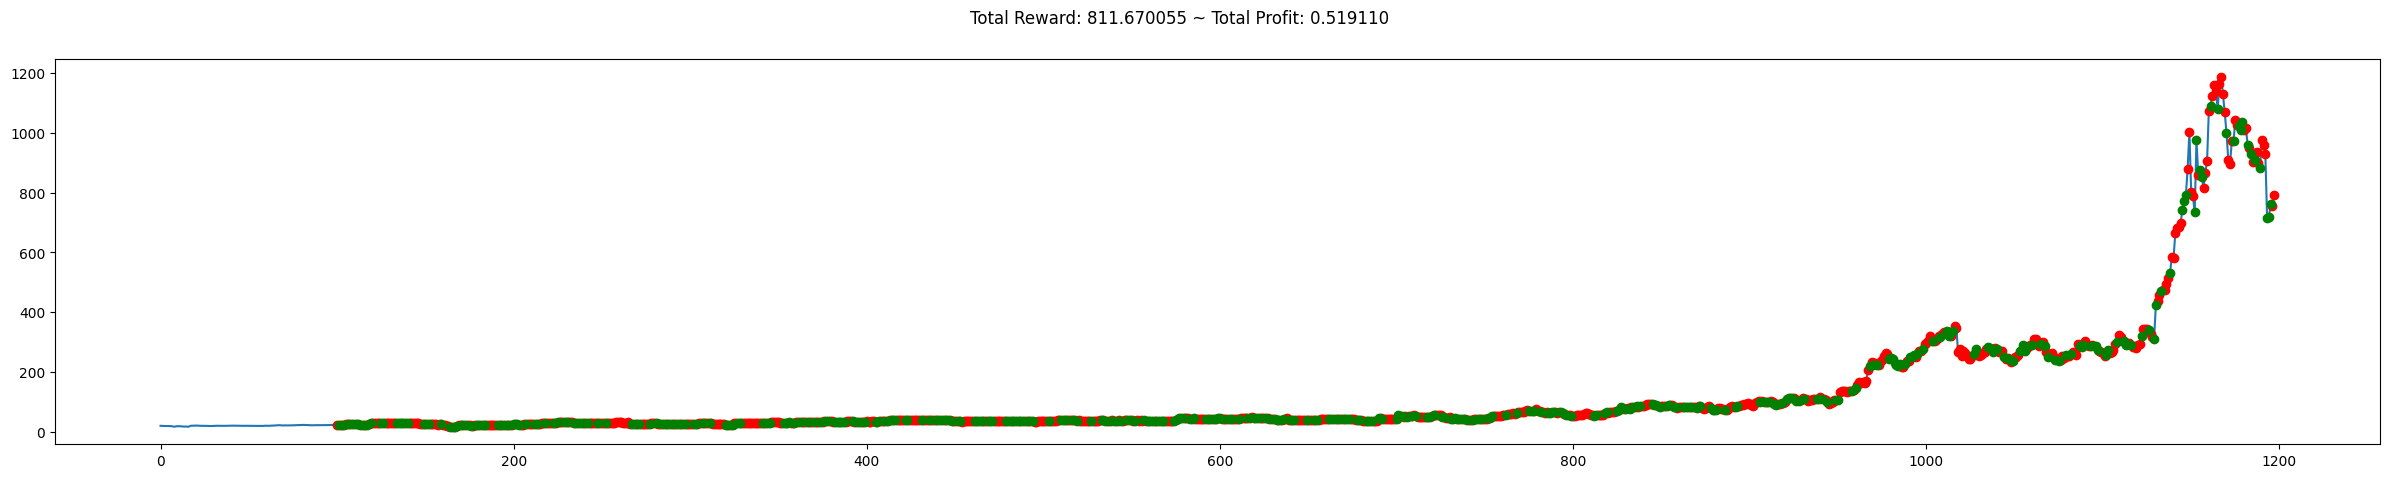

 80%|████████  | 8/10 [02:52<00:42, 21.50s/it]

Total reward accumulated during the test: 513.4801079999997


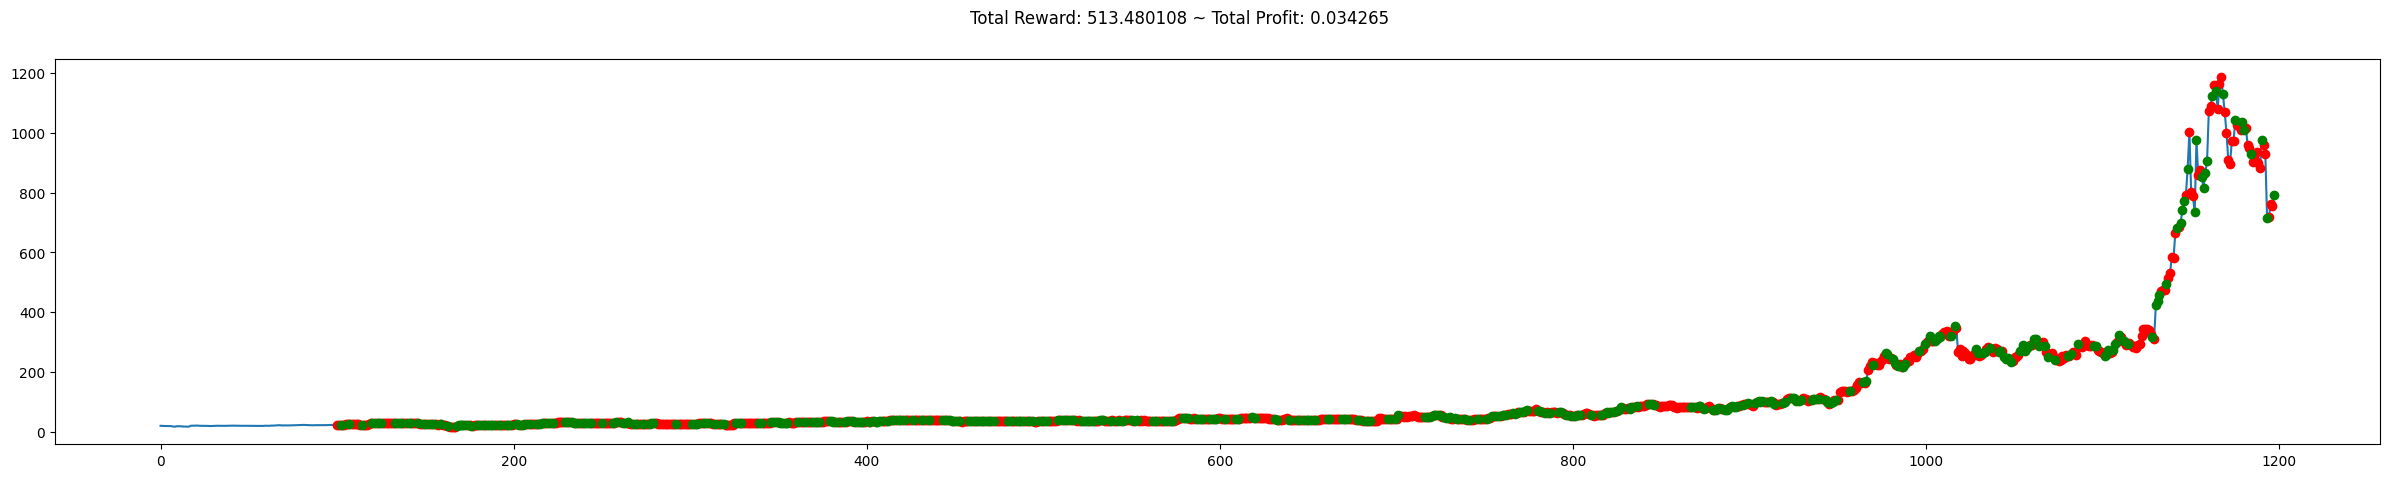

 90%|█████████ | 9/10 [03:15<00:21, 21.74s/it]

Total reward accumulated during the test: 112.75002699999993


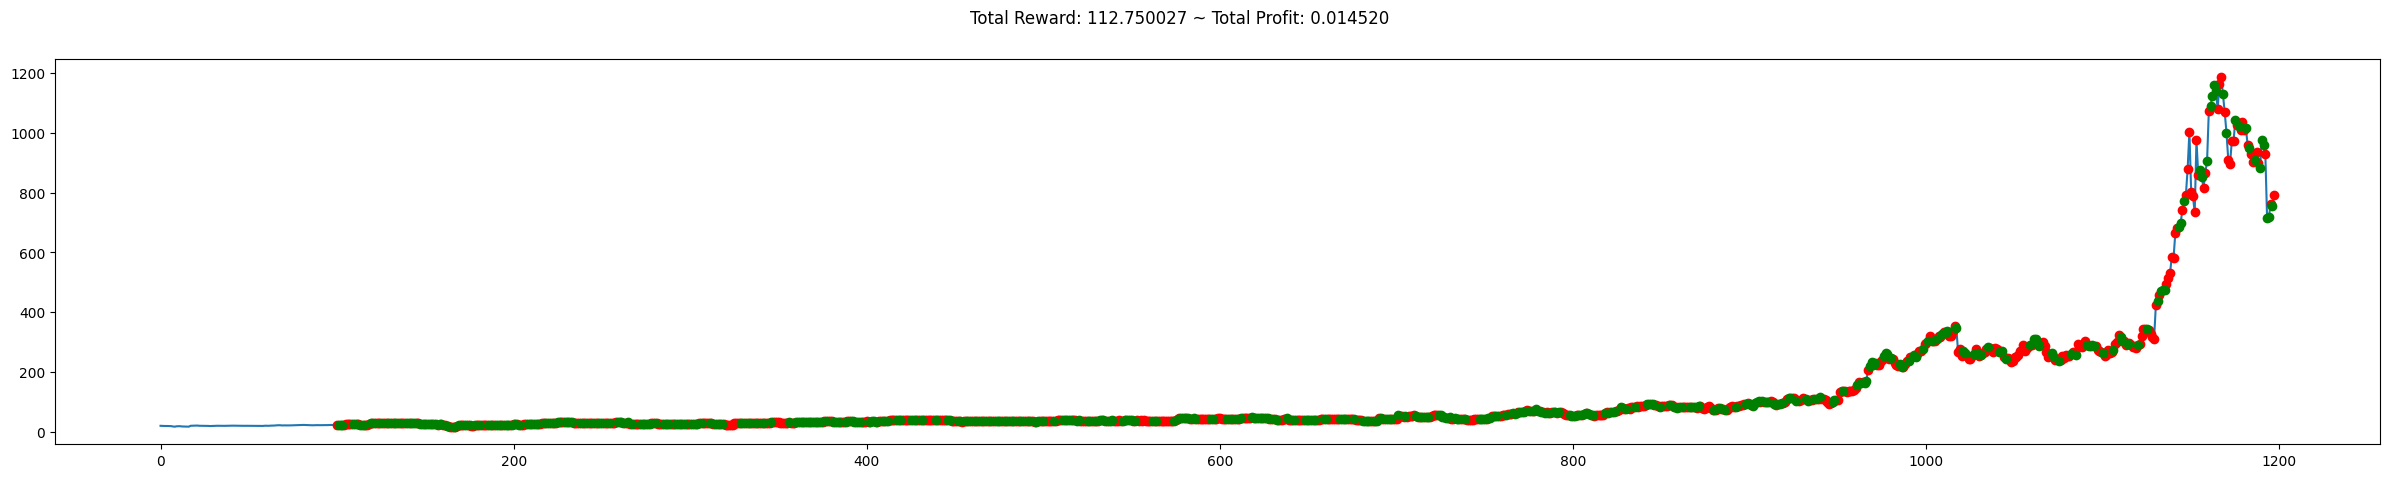

100%|██████████| 10/10 [03:36<00:00, 21.61s/it]


In [ ]:
evla_custom_model(env_test, actor)